In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-10 09:41:52,951: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# Loading our image in the Quantum State
test_image = Image.open('clock_test_image_8x8.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)
np_test_image = np_test_image.reshape((8,8))
print("Original Image Pixel values: ")
print(np_test_image)


Original Image Pixel values: 
[[0.734375   0.7890625  0.80859375 0.8203125  0.828125   0.81640625
  0.80859375 0.77734375]
 [0.79296875 0.859375   0.87109375 0.87890625 0.890625   0.90234375
  0.890625   0.859375  ]
 [0.84375    0.890625   0.89453125 0.90625    0.859375   0.6328125
  0.77734375 0.90234375]
 [0.86328125 0.8984375  0.8984375  0.91796875 0.7734375  0.31640625
  0.453125   0.94140625]
 [0.89453125 0.9375     0.91796875 0.91796875 0.8203125  0.26171875
  0.4375     0.96875   ]
 [0.68359375 0.51953125 0.6953125  0.953125   0.734375   0.3359375
  0.49609375 0.65625   ]
 [0.5625     0.5390625  0.52734375 0.99609375 0.4140625  0.16796875
  0.22265625 0.33203125]
 [0.61328125 0.6171875  0.71484375 0.90625    0.73046875 0.55859375
  0.5625     0.578125  ]]


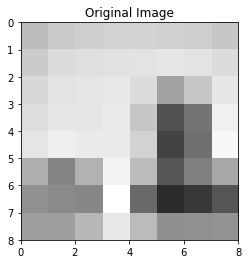

Normalized Image Pixel values: 
[[0.12184001 0.1309132  0.13415363 0.13609788 0.13739405 0.1354498
  0.13415363 0.12896894]
 [0.13156128 0.14257873 0.14452299 0.14581916 0.14776341 0.14970767
  0.14776341 0.14257873]
 [0.13998639 0.14776341 0.1484115  0.15035575 0.14257873 0.10498979
  0.12896894 0.14970767]
 [0.14322682 0.14905958 0.14905958 0.15230001 0.12832086 0.0524949
  0.07517788 0.15618852]
 [0.1484115  0.15554043 0.15230001 0.15230001 0.13609788 0.0434217
  0.07258554 0.16072512]
 [0.1134149  0.08619532 0.11535916 0.15813278 0.12184001 0.05573532
  0.08230681 0.1088783 ]
 [0.09332426 0.08943575 0.08749149 0.16526171 0.06869703 0.02786766
  0.03694085 0.05508724]
 [0.10174937 0.10239745 0.11859958 0.15035575 0.12119192 0.09267618
  0.09332426 0.0959166 ]]


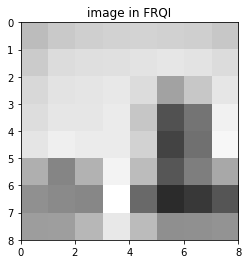

In [10]:
# Function to plot our image
def plot_image8x8(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image8x8(np_test_image, "Original Image")   

# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array
    
def plot_image8x8_denormalized(image, true_image, true_image_normalized, title: str):
    normalization_factor = 0.0
    for x in range(8):
        for y in range(8):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (8**2)
    
    image_plot = image / normalization_factor
    
    plt.title(title)
    plt.imshow(image_plot, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
    
def denormalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image    

np_test_image_normalized = normalize(np_test_image)
print("Normalized Image Pixel values: ")
print(np_test_image_normalized)

plot_image8x8_denormalized(np_test_image_normalized, np_test_image, np_test_image_normalized, 'image in FRQI')

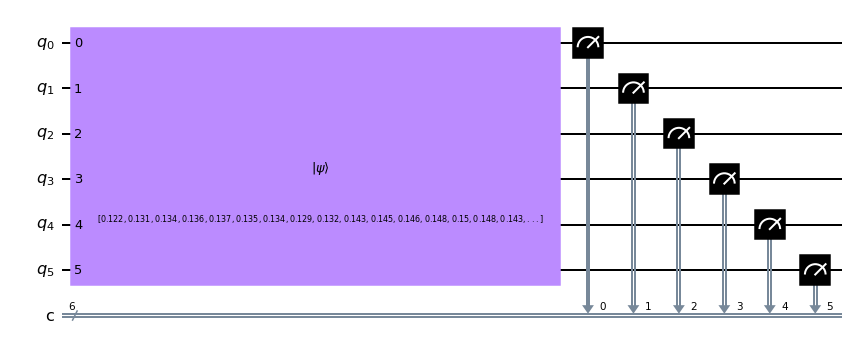

In [5]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(6,6)
qc_image.initialize(np_test_image_normalized.reshape(8**2))
qc_image.measure(range(6), range(6))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
#qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])

qc_image.draw()

In [6]:
#Firstly, let's run it on a simulator:
simulator = Aer.get_backend('aer_simulator')
qc_image_transpiled = transpile(qc_image, simulator)

result = simulator.run(qc_image_transpiled, shots=4096).result()
counts = result.get_counts()

print(counts)

{'101110': 30, '010100': 95, '010111': 106, '011111': 99, '011011': 85, '001110': 79, '110101': 5, '000010': 84, '001100': 92, '111101': 28, '001000': 58, '010110': 65, '101101': 21, '101011': 111, '111111': 33, '110110': 4, '100011': 99, '000011': 73, '101010': 60, '001111': 103, '101100': 59, '000111': 78, '010011': 79, '111000': 44, '100010': 106, '010010': 89, '111110': 43, '000110': 72, '010001': 86, '111100': 64, '110010': 22, '011100': 67, '100100': 65, '110100': 17, '111011': 102, '011000': 96, '001011': 73, '010000': 80, '100000': 90, '100110': 22, '001101': 85, '110001': 34, '101111': 48, '101001': 31, '000001': 66, '011010': 79, '011101': 13, '001001': 79, '101000': 56, '011001': 80, '011110': 24, '000000': 73, '110000': 35, '100111': 124, '000100': 80, '110011': 112, '000101': 76, '110111': 10, '100001': 83, '010101': 39, '111010': 40, '100101': 13, '111001': 42, '001010': 90}


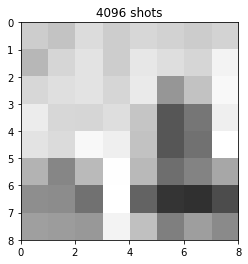

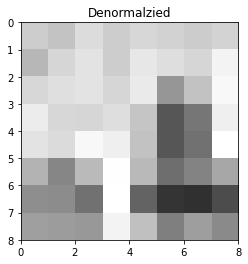

In [12]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

simulator_output = []
for i in range(64):
    if get_bin(i, 6) in counts:
        simulator_output.append(np.sqrt( ( counts.get(get_bin(i, 6)) / 4096 ) ) )
    else:
        simulator_output.append(0)
        
np_simulator_output = np.array(simulator_output).reshape((8,8))
np_simulator_output = normalize(np_simulator_output)

np_simulator_output_denormalized = denormalize(np_test_image, np_test_image_normalized, np_simulator_output, 8)

plot_image8x8_denormalized(np_simulator_output, np_test_image, np_test_image_normalized, '4096 shots')
plot_image8x8(np_simulator_output_denormalized, "Denormalzied")


In [13]:
#ERROR DEFINTIONS
def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

def mse_image_error(true_image, error_image, n):
    ms_error = 0.0
    for y in range(n):
        for x in range(n):
            ms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    return (ms_error / (n**2))

# SSIM is built into a library, we'll just use that
from skimage.metrics import structural_similarity as ssim

In [14]:
rmse_simulator = rmse_image_error(np_test_image, np_simulator_output_denormalized, 8)
print("RMSE Error: ", rmse_simulator)
mse_simulator = mse_image_error(np_test_image, np_simulator_output_denormalized, 8)
print("MSE Error: ", mse_simulator)
ssim_simulator = ssim(np_test_image, np_simulator_output_denormalized, data_range=np_simulator_output_denormalized.max() - np_simulator_output_denormalized.min())
print("SSIM: ", ssim_simulator)

RMSE Error:  0.005894944241654092
MSE Error:  0.002224023527181487
SSIM:  0.9780294967852101


{'101110': 30, '010100': 95, '010111': 106, '011111': 99, '011011': 85, '001110': 79, '110101': 5, '000010': 84, '001100': 92, '111101': 28, '001000': 58, '010110': 65, '101101': 21, '101011': 111, '111111': 33, '110110': 4, '100011': 99, '000011': 73, '101010': 60, '001111': 103, '101100': 59, '000111': 78, '010011': 79, '111000': 44, '100010': 106, '010010': 89, '111110': 43, '000110': 72, '010001': 86, '111100': 64, '110010': 22, '011100': 67, '100100': 65, '110100': 17, '111011': 102, '011000': 96, '001011': 73, '010000': 80, '100000': 90, '100110': 22, '001101': 85, '110001': 34, '101111': 48, '101001': 31, '000001': 66, '011010': 79, '011101': 13, '001001': 79, '101000': 56, '011001': 80, '011110': 24, '000000': 73, '110000': 35, '100111': 124, '000100': 80, '110011': 112, '000101': 76, '110111': 10, '100001': 83, '010101': 39, '111010': 40, '100101': 13, '111001': 42, '001010': 90}
Image recontructed from  500 Shots:


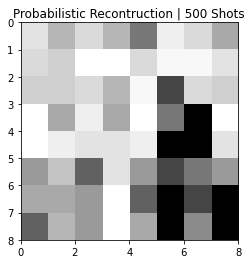

RMSE:  0.024713081761933136  | MSE:  0.039087130251007504  | SSIM:  0.7782252318148161
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  1000 Shots:


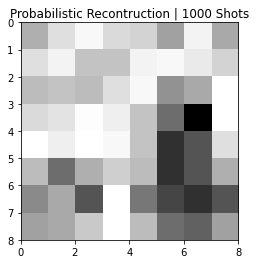

RMSE:  0.013674154368751136  | MSE:  0.011966879852827891  | SSIM:  0.8962534107449369
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  1500 Shots:


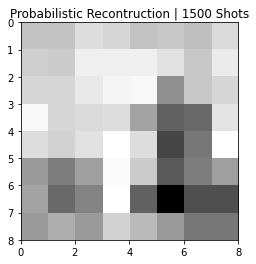

RMSE:  0.00928007922300231  | MSE:  0.005511671704652746  | SSIM:  0.946933643147304
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  2000 Shots:


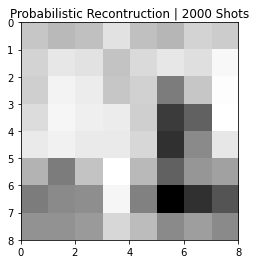

RMSE:  0.008097022639646704  | MSE:  0.004195953640124882  | SSIM:  0.960902572652219
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  2500 Shots:


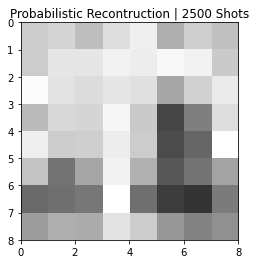

RMSE:  0.00793707059756621  | MSE:  0.004031813738928001  | SSIM:  0.9645375307497311
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  3000 Shots:


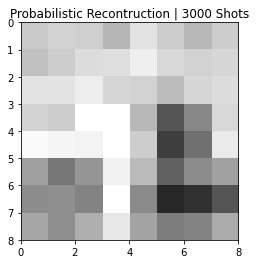

RMSE:  0.007536460038148296  | MSE:  0.003635086714022798  | SSIM:  0.962763657946283
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  3500 Shots:


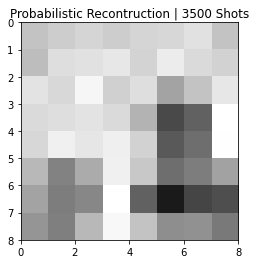

RMSE:  0.005824928535622886  | MSE:  0.0021715067164872824  | SSIM:  0.9788407131558976
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  4000 Shots:


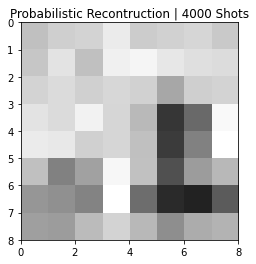

RMSE:  0.006814533101809005  | MSE:  0.0029720231293216422  | SSIM:  0.9698621062152266
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  4500 Shots:


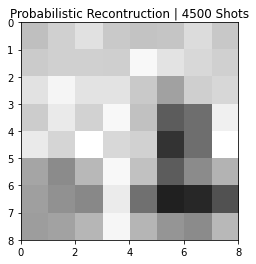

RMSE:  0.006041622108756508  | MSE:  0.0023360766531209877  | SSIM:  0.9769574365676705
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  5000 Shots:


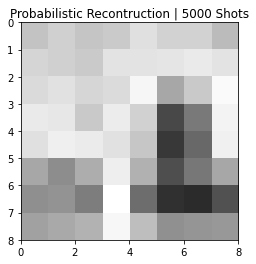

RMSE:  0.004674176334406551  | MSE:  0.0013982671619280809  | SSIM:  0.9854094958528457
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  5500 Shots:


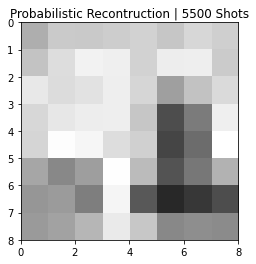

RMSE:  0.004590985993272005  | MSE:  0.0013489377529868633  | SSIM:  0.9868391729035528
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  6000 Shots:


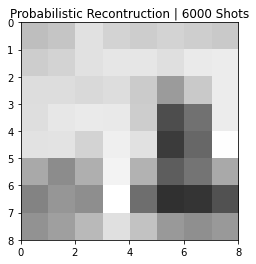

RMSE:  0.0038752497795637667  | MSE:  0.0009611238946565774  | SSIM:  0.9897395947097185
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  6500 Shots:


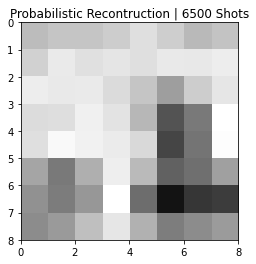

RMSE:  0.00507862552476456  | MSE:  0.0016507159821305664  | SSIM:  0.9849291294561002
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  7000 Shots:


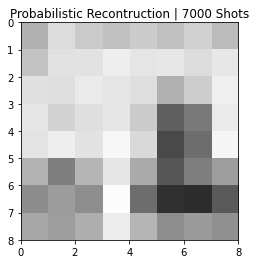

RMSE:  0.0043118174203815775  | MSE:  0.0011898732458691865  | SSIM:  0.9878742546712352
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  7500 Shots:


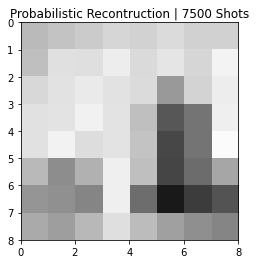

RMSE:  0.004251866876703245  | MSE:  0.001157015803981197  | SSIM:  0.9885211782382557
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  8000 Shots:


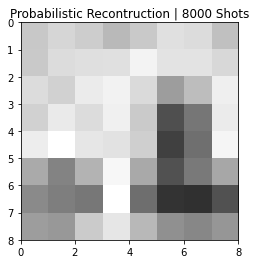

RMSE:  0.004209554730853048  | MSE:  0.001134102466051026  | SSIM:  0.9894063320312326
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  8500 Shots:


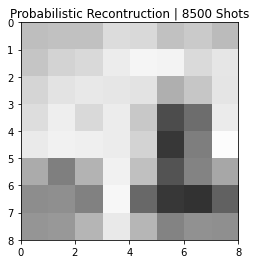

RMSE:  0.003663975070878583  | MSE:  0.0008591816524812618  | SSIM:  0.9912995380608844
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  9000 Shots:


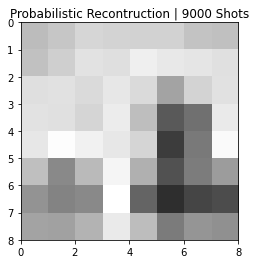

RMSE:  0.003571924102233014  | MSE:  0.0008165530746952398  | SSIM:  0.9917816076237495
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  9500 Shots:


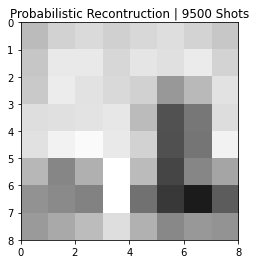

RMSE:  0.00450301428300591  | MSE:  0.0012977368085091347  | SSIM:  0.9859589353499372
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  10000 Shots:


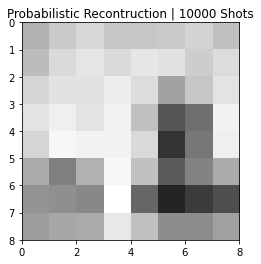

RMSE:  0.003697639796006407  | MSE:  0.0008750425639046593  | SSIM:  0.9915918545085155
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  10500 Shots:


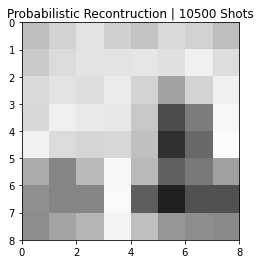

RMSE:  0.004595430700625721  | MSE:  0.0013515509327522179  | SSIM:  0.9858984637136777
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  11000 Shots:


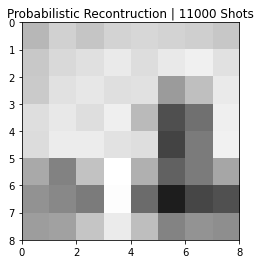

RMSE:  0.003534917587899569  | MSE:  0.0007997211106074692  | SSIM:  0.9911543364199691
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  11500 Shots:


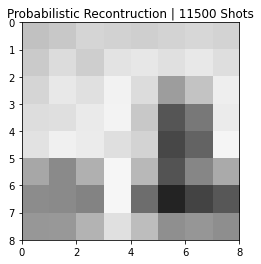

RMSE:  0.002824946175706305  | MSE:  0.0005107405373208114  | SSIM:  0.9946059263149593
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  12000 Shots:


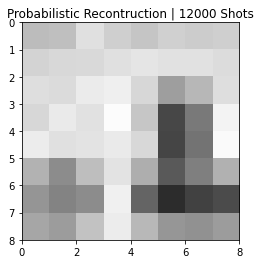

RMSE:  0.0038817933551992378  | MSE:  0.0009643724577580133  | SSIM:  0.9899167845600194
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  12500 Shots:


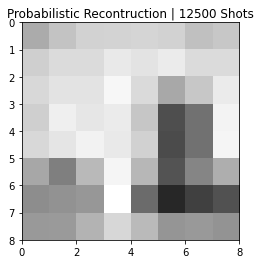

RMSE:  0.0032873600375671248  | MSE:  0.0006916311050619731  | SSIM:  0.9934985412615386
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  13000 Shots:


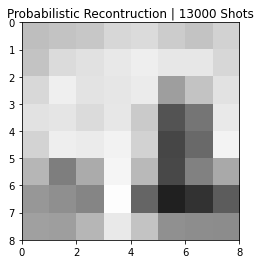

RMSE:  0.0031004033611474763  | MSE:  0.0006152000641161324  | SSIM:  0.9942587327999881
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  13500 Shots:


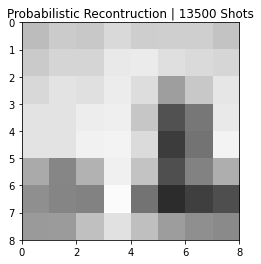

RMSE:  0.002808229319733918  | MSE:  0.0005047137223816463  | SSIM:  0.9947966974059619
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  14000 Shots:


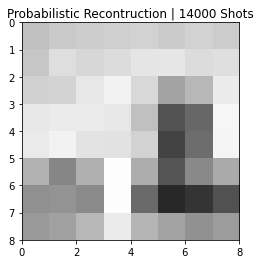

RMSE:  0.0031744714523721795  | MSE:  0.0006449452161232598  | SSIM:  0.9931784786391434
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  14500 Shots:


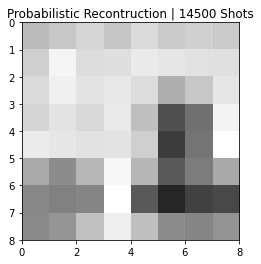

RMSE:  0.0036422508026613017  | MSE:  0.0008490234182071614  | SSIM:  0.991677619316448
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  15000 Shots:


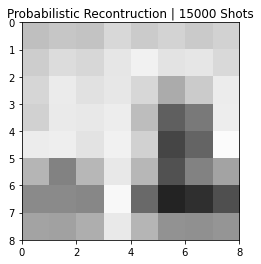

RMSE:  0.0029940793674016444  | MSE:  0.0005737287205312148  | SSIM:  0.9941384360197674
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  15500 Shots:


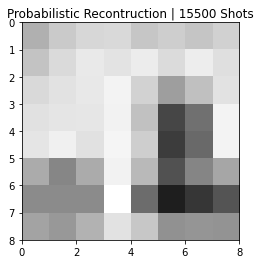

RMSE:  0.003107263155296339  | MSE:  0.0006179253962407783  | SSIM:  0.9941099135171882
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  16000 Shots:


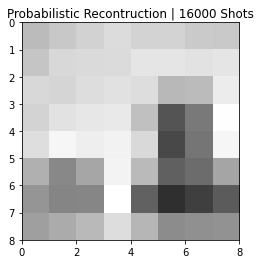

RMSE:  0.0034278820418604124  | MSE:  0.0007520240187461831  | SSIM:  0.9916230889221531
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  16500 Shots:


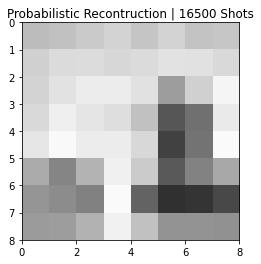

RMSE:  0.003002034441982014  | MSE:  0.0005767814906141608  | SSIM:  0.9942836700730628
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  17000 Shots:


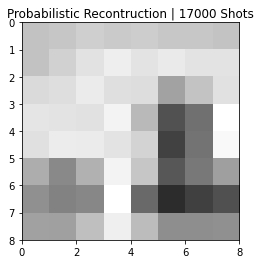

RMSE:  0.0029322399743205788  | MSE:  0.0005502740010882271  | SSIM:  0.9946452366960634
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  17500 Shots:


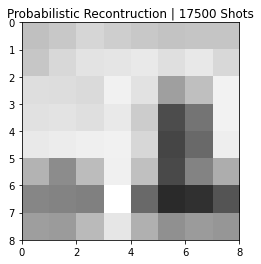

RMSE:  0.0030533851541330015  | MSE:  0.0005966822975667081  | SSIM:  0.9942668049452721
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  18000 Shots:


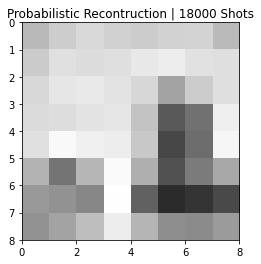

RMSE:  0.0029212803530915135  | MSE:  0.0005461682496869425  | SSIM:  0.9947748817379746
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  18500 Shots:


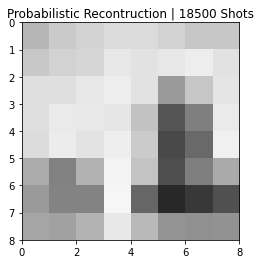

RMSE:  0.0026965012488959048  | MSE:  0.00046535161505901915  | SSIM:  0.9952630214471518
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  19000 Shots:


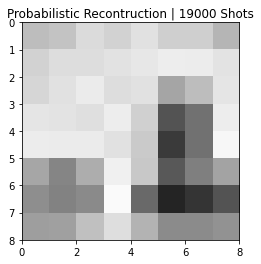

RMSE:  0.0030814422880933038  | MSE:  0.0006076983407903806  | SSIM:  0.9944752840243324
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  19500 Shots:


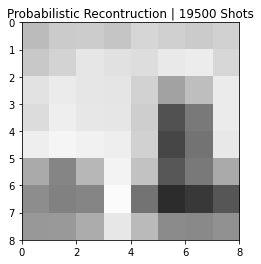

RMSE:  0.002784584353465615  | MSE:  0.000496250241380193  | SSIM:  0.9952651758236812
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  20000 Shots:


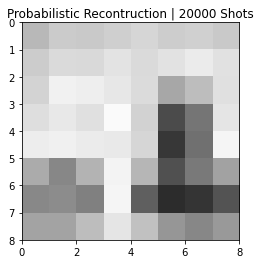

RMSE:  0.0029923229040141434  | MSE:  0.0005730557671608088  | SSIM:  0.9940354583053603
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  20500 Shots:


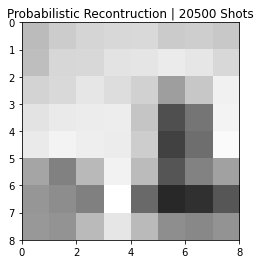

RMSE:  0.0025566106468694703  | MSE:  0.00041832051197992516  | SSIM:  0.9960962747753965
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  21000 Shots:


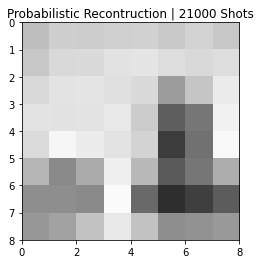

RMSE:  0.002520724477218824  | MSE:  0.0004066593209632073  | SSIM:  0.9957080459232688
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  21500 Shots:


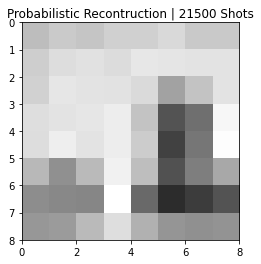

RMSE:  0.0023543124402211346  | MSE:  0.0003547383722355196  | SSIM:  0.9967335409763438
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  22000 Shots:


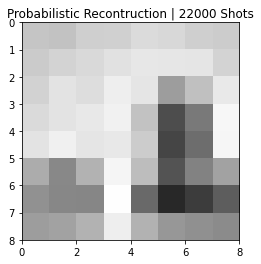

RMSE:  0.002328112482101318  | MSE:  0.00034688689467622137  | SSIM:  0.9969210071264589
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  22500 Shots:


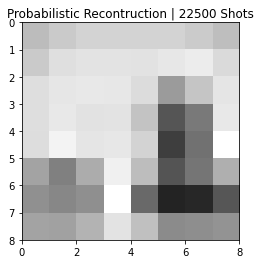

RMSE:  0.002509214929292605  | MSE:  0.0004029542119286332  | SSIM:  0.9960237346027171
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  23000 Shots:


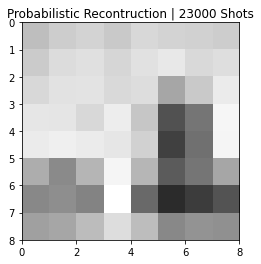

RMSE:  0.0025479429736309815  | MSE:  0.0004154888574000313  | SSIM:  0.9957514972664065
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  23500 Shots:


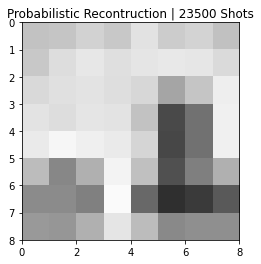

RMSE:  0.002601161093018784  | MSE:  0.0004330264980374191  | SSIM:  0.9961727182467217
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  24000 Shots:


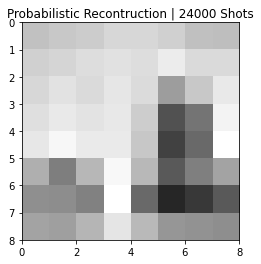

RMSE:  0.002473437865030873  | MSE:  0.000391545271818783  | SSIM:  0.9961054582424489
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  24500 Shots:


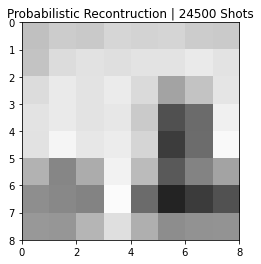

RMSE:  0.0021073822852496612  | MSE:  0.0002842278461557814  | SSIM:  0.9974126950614627
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  25000 Shots:


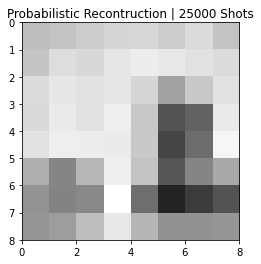

RMSE:  0.002367593807306969  | MSE:  0.0003587520279294918  | SSIM:  0.9962493161155551
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  25500 Shots:


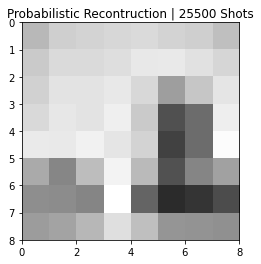

RMSE:  0.0021880529759858804  | MSE:  0.00030640485284612275  | SSIM:  0.9971483559838448
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  26000 Shots:


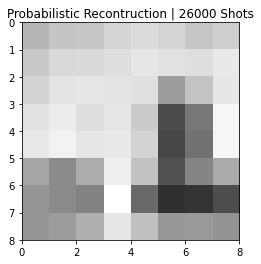

RMSE:  0.002544151305483058  | MSE:  0.00041425317537223345  | SSIM:  0.9963539589948925
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  26500 Shots:


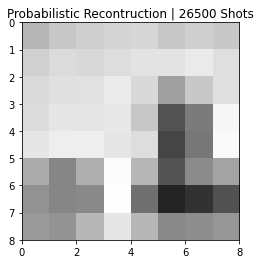

RMSE:  0.0022286642971561872  | MSE:  0.00031788445116279565  | SSIM:  0.9965833882590596
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  27000 Shots:


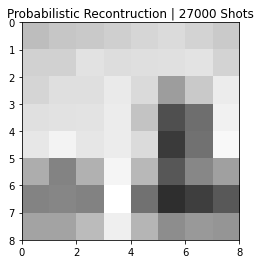

RMSE:  0.002488762723955365  | MSE:  0.0003964121533535826  | SSIM:  0.9961676527603602
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  27500 Shots:


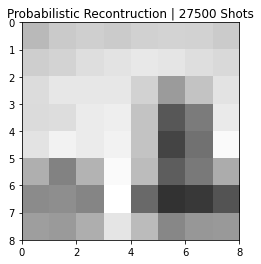

RMSE:  0.002329505613812236  | MSE:  0.0003473021699060942  | SSIM:  0.9961871621601126
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  28000 Shots:


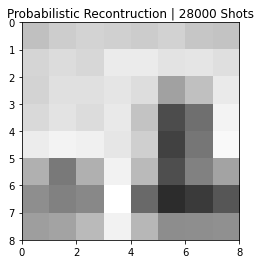

RMSE:  0.0023829164019704705  | MSE:  0.00036341059704191313  | SSIM:  0.9963664939327438
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  28500 Shots:


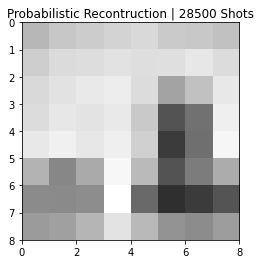

RMSE:  0.0018937428678608087  | MSE:  0.00022952077117271557  | SSIM:  0.9977520018640453
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  29000 Shots:


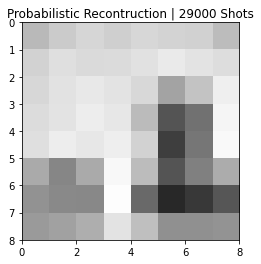

RMSE:  0.00199191370007167  | MSE:  0.00025393409206612554  | SSIM:  0.9976540621834032
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  29500 Shots:


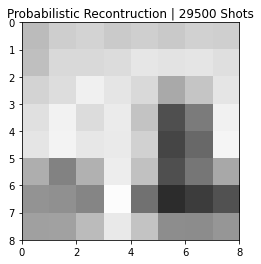

RMSE:  0.0024841408437105716  | MSE:  0.00039494116680902845  | SSIM:  0.9957741185360346
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  30000 Shots:


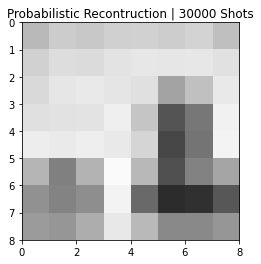

RMSE:  0.0022004724277673534  | MSE:  0.00030989304994331847  | SSIM:  0.9969753182829252
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  30500 Shots:


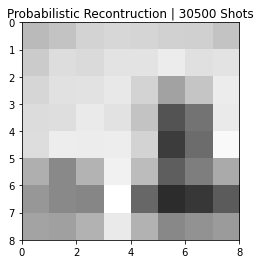

RMSE:  0.0020924566657359797  | MSE:  0.0002802159934709077  | SSIM:  0.9974123390244405
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  31000 Shots:


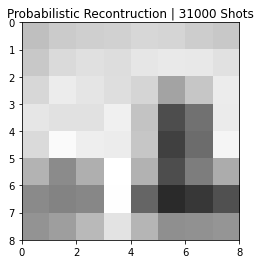

RMSE:  0.0024918034278589747  | MSE:  0.0003973813966777431  | SSIM:  0.995896421944542
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  31500 Shots:


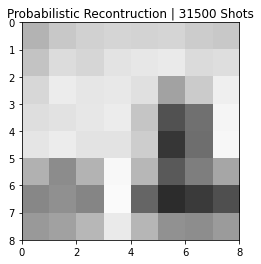

RMSE:  0.002209071220936191  | MSE:  0.00031231972218678496  | SSIM:  0.9967997007811609
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  32000 Shots:


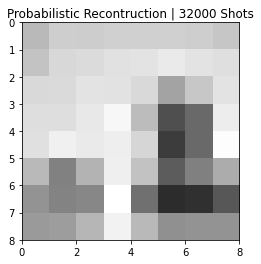

RMSE:  0.002303049844987256  | MSE:  0.0003394584696637328  | SSIM:  0.996333260979916
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  32500 Shots:


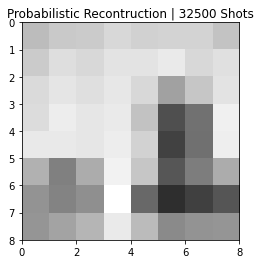

RMSE:  0.0020920373464970578  | MSE:  0.0002801036965848609  | SSIM:  0.9970041912748533
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  33000 Shots:


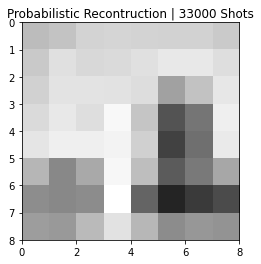

RMSE:  0.002353222942401308  | MSE:  0.0003544101258652076  | SSIM:  0.9964204582024037
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  33500 Shots:


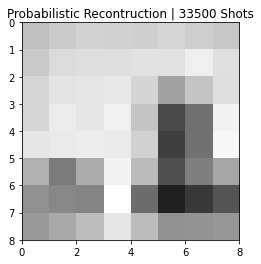

RMSE:  0.0020850545860354075  | MSE:  0.0002782369681118262  | SSIM:  0.9972503797755783
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  34000 Shots:


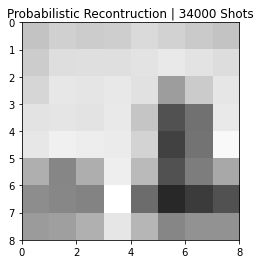

RMSE:  0.0016457527532004446  | MSE:  0.000173344135978678  | SSIM:  0.998559972568638
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  34500 Shots:


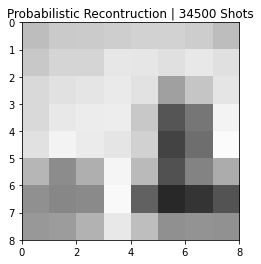

RMSE:  0.001956727717699328  | MSE:  0.0002450421351176206  | SSIM:  0.997441572252699
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  35000 Shots:


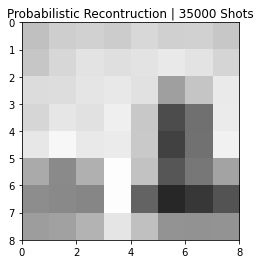

RMSE:  0.0020167352725549014  | MSE:  0.00026030215421229394  | SSIM:  0.9973485167486844
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  35500 Shots:


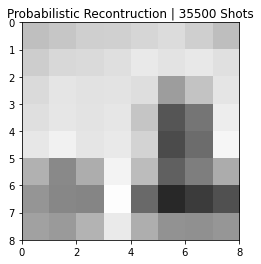

RMSE:  0.002019387419134429  | MSE:  0.0002609872351077383  | SSIM:  0.99756216378287
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  36000 Shots:


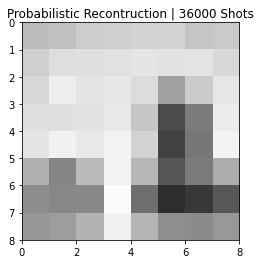

RMSE:  0.0020234633117122243  | MSE:  0.00026204184152610576  | SSIM:  0.9974010372894089
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  36500 Shots:


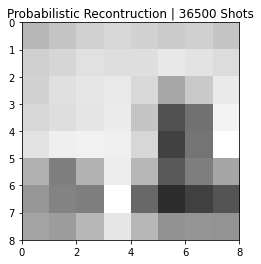

RMSE:  0.001901627933531868  | MSE:  0.00023143608304567568  | SSIM:  0.997619314890616
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  37000 Shots:


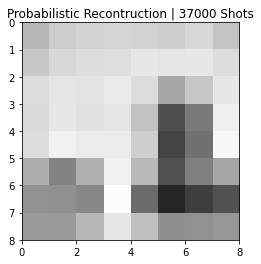

RMSE:  0.0015966792144914137  | MSE:  0.00016316060889529074  | SSIM:  0.998415256219009
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  37500 Shots:


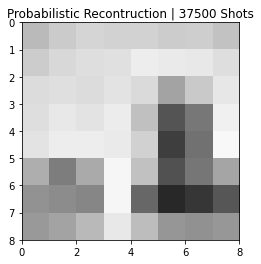

RMSE:  0.0019448298270126185  | MSE:  0.00024207123558642762  | SSIM:  0.9973859913942915
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  38000 Shots:


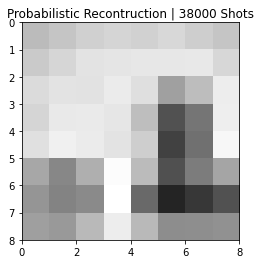

RMSE:  0.0020248403034158124  | MSE:  0.00026239860827757057  | SSIM:  0.9972999500583928
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  38500 Shots:


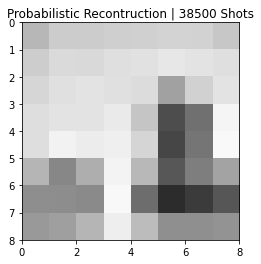

RMSE:  0.0016808983186985466  | MSE:  0.00018082682609943046  | SSIM:  0.9980795048365934
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  39000 Shots:


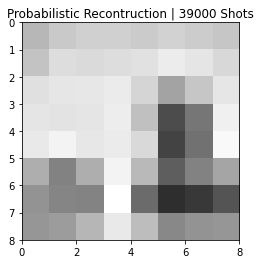

RMSE:  0.001875756019459521  | MSE:  0.00022518148125047212  | SSIM:  0.9978117874329309
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  39500 Shots:


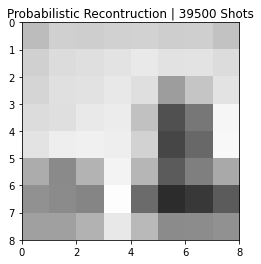

RMSE:  0.0016171329409590655  | MSE:  0.00016736761271903463  | SSIM:  0.9982583388098436
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  40000 Shots:


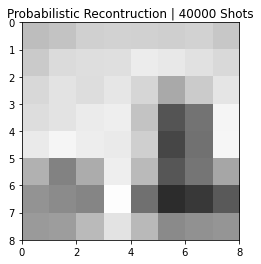

RMSE:  0.0017342705267576345  | MSE:  0.000192492432638733  | SSIM:  0.9978228633160448
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  40500 Shots:


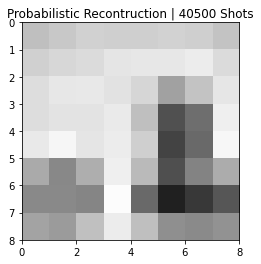

RMSE:  0.0020474620001458095  | MSE:  0.000268294441090629  | SSIM:  0.9973317437895755
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  41000 Shots:


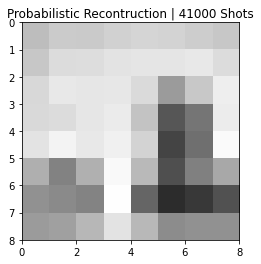

RMSE:  0.0015198067768539267  | MSE:  0.00014782800889415177  | SSIM:  0.9984029050054168
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  41500 Shots:


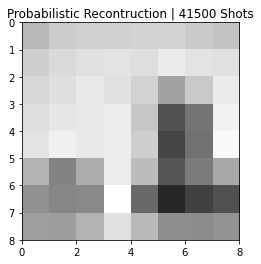

RMSE:  0.001749312378129709  | MSE:  0.00019584600296178038  | SSIM:  0.9978731934316782
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  42000 Shots:


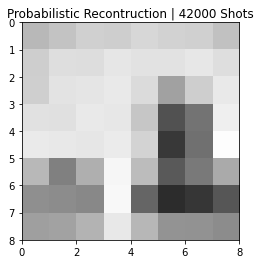

RMSE:  0.001932307618231807  | MSE:  0.00023896401481450746  | SSIM:  0.99775955548253
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  42500 Shots:


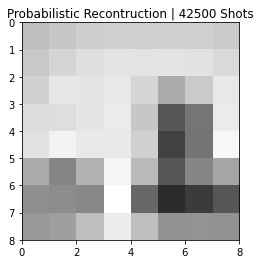

RMSE:  0.001651925814271821  | MSE:  0.0001746469693348876  | SSIM:  0.998253807777496
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  43000 Shots:


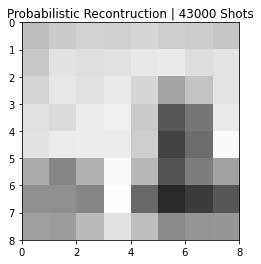

RMSE:  0.0018777219204668576  | MSE:  0.0002256537350785116  | SSIM:  0.9976809047630455
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  43500 Shots:


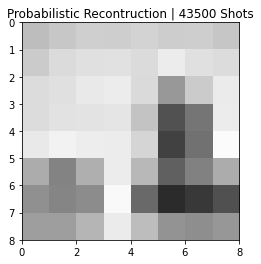

RMSE:  0.0018200845125756332  | MSE:  0.00021201328850673154  | SSIM:  0.9975764363133743
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  44000 Shots:


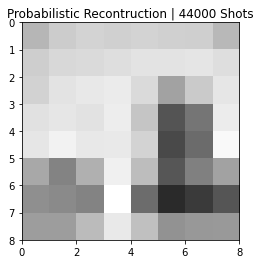

RMSE:  0.001784917445254649  | MSE:  0.0002038995383279605  | SSIM:  0.9984758581837676
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  44500 Shots:


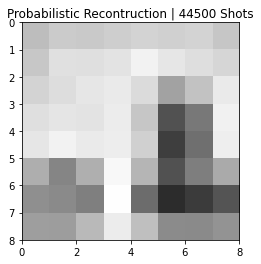

RMSE:  0.0018098055408806207  | MSE:  0.00020962535013134055  | SSIM:  0.9977960979901634
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  45000 Shots:


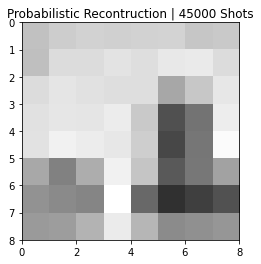

RMSE:  0.0020868542122290707  | MSE:  0.0002787174721982858  | SSIM:  0.9971371534224878
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  45500 Shots:


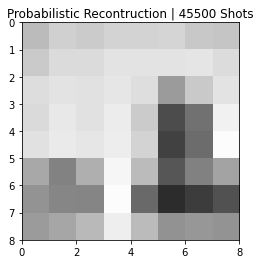

RMSE:  0.001703698265488448  | MSE:  0.0001857656179090142  | SSIM:  0.9982970880448975
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  46000 Shots:


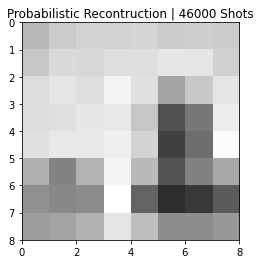

RMSE:  0.0018689566167531834  | MSE:  0.00022355192545955236  | SSIM:  0.9977617569166449
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  46500 Shots:


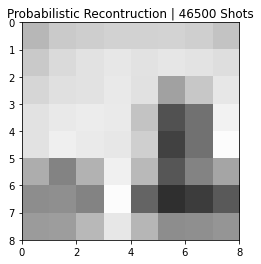

RMSE:  0.0014460796503980218  | MSE:  0.00013383336673889696  | SSIM:  0.9985553824684422
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  47000 Shots:


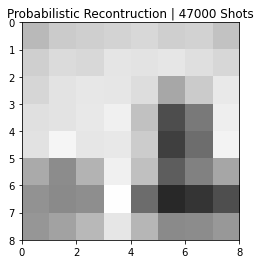

RMSE:  0.001891841636850386  | MSE:  0.00022906014585092788  | SSIM:  0.997623233432177
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  47500 Shots:


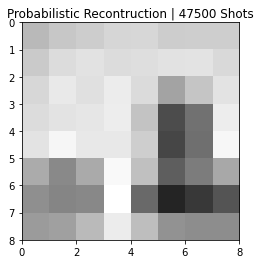

RMSE:  0.0017863267755920036  | MSE:  0.00020422165434860317  | SSIM:  0.9978829374127949
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  48000 Shots:


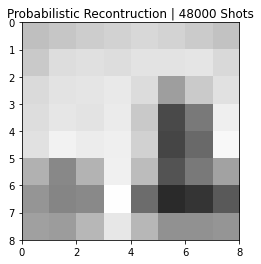

RMSE:  0.0014758593108646861  | MSE:  0.0001394022851498231  | SSIM:  0.9986274108694456
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  48500 Shots:


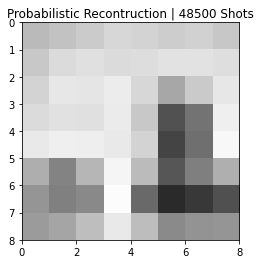

RMSE:  0.0017712507082783687  | MSE:  0.00020078906058090386  | SSIM:  0.9980384915361034
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  49000 Shots:


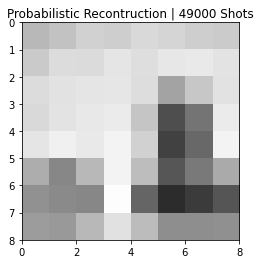

RMSE:  0.0016676065838008287  | MSE:  0.0001779783499734957  | SSIM:  0.9983157546486189
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  49500 Shots:


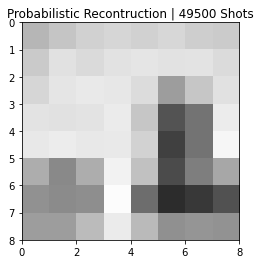

RMSE:  0.0017045312641719495  | MSE:  0.00018594731715453595  | SSIM:  0.9981091021593966
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  50000 Shots:


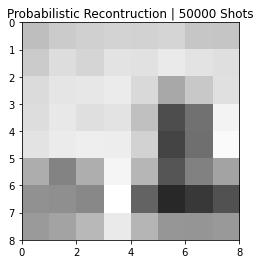

RMSE:  0.0018278105763386838  | MSE:  0.00021381705619043532  | SSIM:  0.9978773929856727
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  50500 Shots:


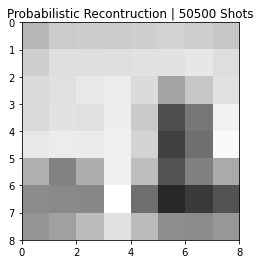

RMSE:  0.0016053096124622657  | MSE:  0.00016492921291928  | SSIM:  0.9984695899807962
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  51000 Shots:


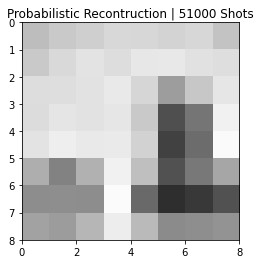

RMSE:  0.0015713352563043147  | MSE:  0.00015802204721311657  | SSIM:  0.9984096197878711
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  51500 Shots:


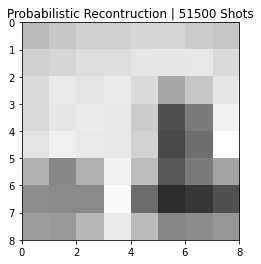

RMSE:  0.0016290733781431095  | MSE:  0.00016984832456797455  | SSIM:  0.9982343499790975
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  52000 Shots:


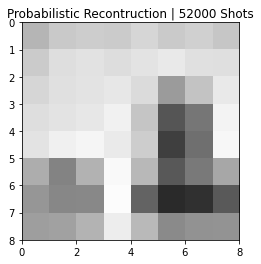

RMSE:  0.0017432718307433654  | MSE:  0.00019449578725525278  | SSIM:  0.9980035676222029
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  52500 Shots:


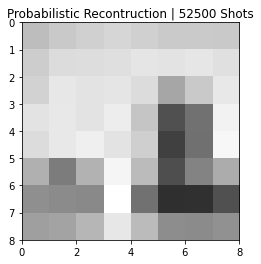

RMSE:  0.0018676276529383485  | MSE:  0.00022323411520128026  | SSIM:  0.9977376766788917
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  53000 Shots:


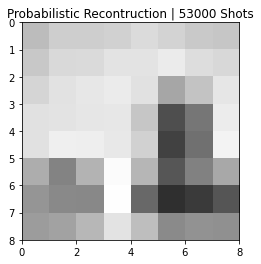

RMSE:  0.0016316186002426258  | MSE:  0.00017037947242609316  | SSIM:  0.998305963311264
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  53500 Shots:


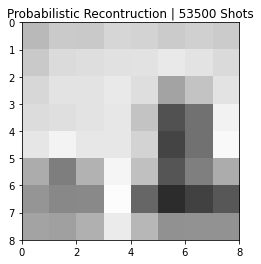

RMSE:  0.001538923555941525  | MSE:  0.00015157028550602931  | SSIM:  0.998591582224513
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  54000 Shots:


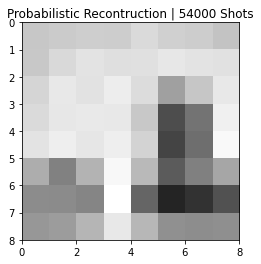

RMSE:  0.0016326803828681188  | MSE:  0.00017060129488655277  | SSIM:  0.9985201407859916
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  54500 Shots:


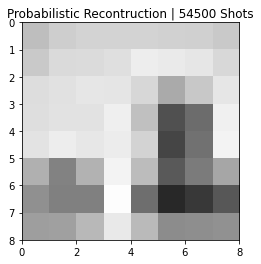

RMSE:  0.0016814004249750985  | MSE:  0.0001809348729028123  | SSIM:  0.9979343567315764
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  55000 Shots:


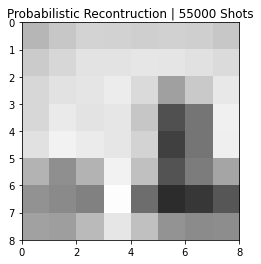

RMSE:  0.0017599302956184957  | MSE:  0.00019823069730789155  | SSIM:  0.9981010688954257
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  55500 Shots:


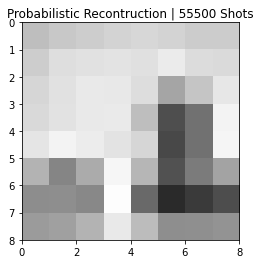

RMSE:  0.0016159846322924198  | MSE:  0.00016713000523553708  | SSIM:  0.9981938517216411
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  56000 Shots:


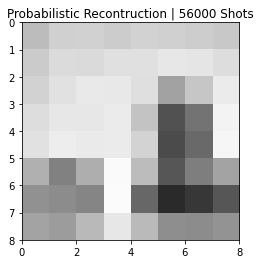

RMSE:  0.0014111150049263338  | MSE:  0.0001274397156562078  | SSIM:  0.9987771555072418
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  56500 Shots:


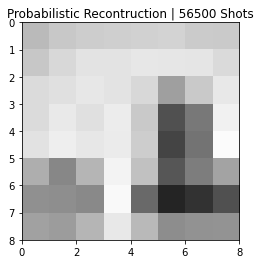

RMSE:  0.001492472731061616  | MSE:  0.00014255839058960123  | SSIM:  0.998426923951544
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  57000 Shots:


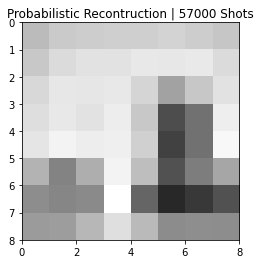

RMSE:  0.0015054722279678578  | MSE:  0.00014505258426768036  | SSIM:  0.9985505031544922
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  57500 Shots:


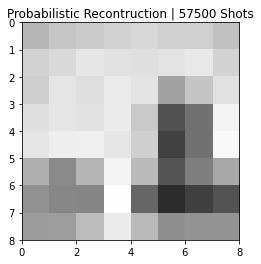

RMSE:  0.0017646699349932223  | MSE:  0.00019929983868601493  | SSIM:  0.9980299355975011
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  58000 Shots:


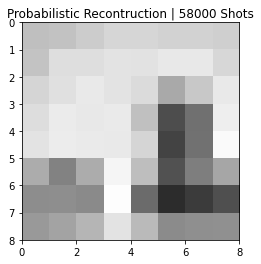

RMSE:  0.0017213610695340734  | MSE:  0.0001896373716292793  | SSIM:  0.9982272496885575
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  58500 Shots:


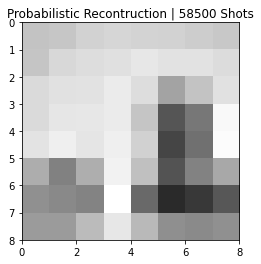

RMSE:  0.0015066583205707701  | MSE:  0.00014528123487648855  | SSIM:  0.9986874276138399
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  59000 Shots:


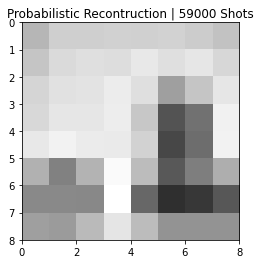

RMSE:  0.0016156878089952046  | MSE:  0.0001670686141526864  | SSIM:  0.9984722364323119
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  59500 Shots:


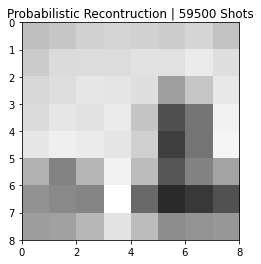

RMSE:  0.0013977427079803174  | MSE:  0.00012503581937357765  | SSIM:  0.9987510986179561
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  60000 Shots:


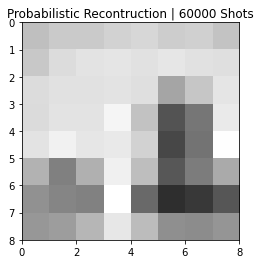

RMSE:  0.0015660673780742095  | MSE:  0.00015696429009076667  | SSIM:  0.998356837260118
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  60500 Shots:


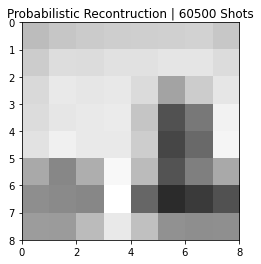

RMSE:  0.001313114971343817  | MSE:  0.0001103533393899055  | SSIM:  0.9989040057234991
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  61000 Shots:


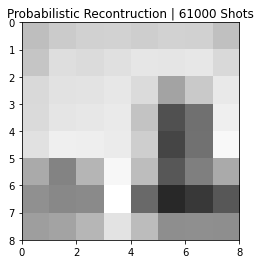

RMSE:  0.001239305650140392  | MSE:  9.829622364607358e-05  | SSIM:  0.9991801469951154
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  61500 Shots:


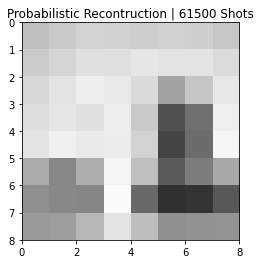

RMSE:  0.0013348516207001295  | MSE:  0.0001140370463542888  | SSIM:  0.998709456464453
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  62000 Shots:


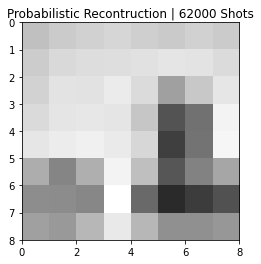

RMSE:  0.0013277441340417005  | MSE:  0.0001128258870708573  | SSIM:  0.9989372856984909
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  62500 Shots:


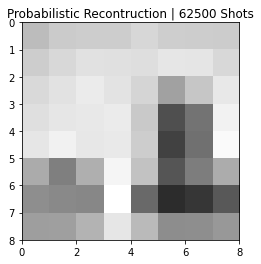

RMSE:  0.0014009108619991435  | MSE:  0.00012560327956909973  | SSIM:  0.9987139641406931
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  63000 Shots:


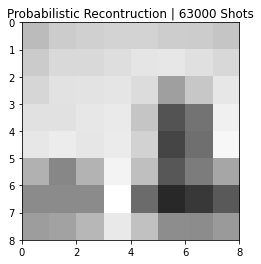

RMSE:  0.0012976071575244164  | MSE:  0.00010776219745655011  | SSIM:  0.9989945105331316
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  63500 Shots:


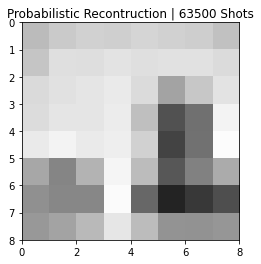

RMSE:  0.0015460329190229351  | MSE:  0.00015297393834896495  | SSIM:  0.9986083102411722
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  64000 Shots:


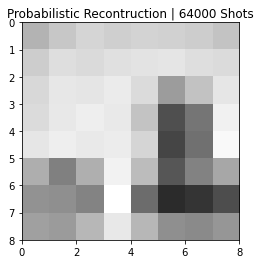

RMSE:  0.001542165730274497  | MSE:  0.00015220960893651665  | SSIM:  0.9985032273740251
-X-X-X-X-X-X-X-X-X-X-
RMSE Error Values:
[0.024713081761933136, 0.013674154368751136, 0.00928007922300231, 0.008097022639646704, 0.00793707059756621, 0.007536460038148296, 0.005824928535622886, 0.006814533101809005, 0.006041622108756508, 0.004674176334406551, 0.004590985993272005, 0.0038752497795637667, 0.00507862552476456, 0.0043118174203815775, 0.004251866876703245, 0.004209554730853048, 0.003663975070878583, 0.003571924102233014, 0.00450301428300591, 0.003697639796006407, 0.004595430700625721, 0.003534917587899569, 0.002824946175706305, 0.0038817933551992378, 0.0032873600375671248, 0.0031004033611474763, 0.002808229319733918, 0.0031744714523721795, 0.0036422508026613017, 0.0029940793674016444, 0.003107263155296339, 0.0034278820418604124, 0.003002034441982014, 0.0029322399743205788, 0.0030533851541330015, 0.0029212803530915135, 0.0026965012488959048, 0.0030814422880933038, 0.002784584353465615, 0

In [18]:
# Now we will see how changing the nuymebrof shots affects these errors:
simulator = Aer.get_backend('aer_simulator')
qc_image_transpiled = transpile(qc_image, simulator)

print(counts)

shots = np.arange(500, 64001, 500)
rmse_error = []
mse_error = []
ssim_error = []
images = []
for shots_value in shots:
    # Running Quantum Circuit
    result = simulator.run(qc_image_transpiled, shots=shots_value).result()
    counts = result.get_counts()
    
    # Recreating the Image from circuit output
    simulator_output = []
    for i in range(64):
        if get_bin(i, 6) in counts:
            simulator_output.append(np.sqrt( ( counts.get(get_bin(i, 6)) / shots_value ) ) )
        else:
            simulator_output.append(0)
        
    np_simulator_output = np.array(simulator_output).reshape((8,8))
    np_simulator_output = normalize(np_simulator_output)
    np_simulator_output_denormalized = denormalize(np_test_image, np_test_image_normalized, np_simulator_output, 8)

    images.append(np_simulator_output_denormalized)
    
    #Display Image:
    print("Image recontructed from ", shots_value, "Shots:")
    title_string = "Probabilistic Recontruction | {} Shots".format(shots_value)
    plot_image8x8(np_simulator_output_denormalized, title_string)
    
    #Calculate Errors:
    rmse_simulator = rmse_image_error(np_test_image, np_simulator_output_denormalized, 8)
    mse_simulator = mse_image_error(np_test_image, np_simulator_output_denormalized, 8)
    ssim_simulator = ssim(np_test_image, np_simulator_output_denormalized, data_range=np_simulator_output_denormalized.max() - np_simulator_output_denormalized.min())

    rmse_error.append(rmse_simulator)
    mse_error.append(mse_simulator)
    ssim_error.append(ssim_simulator)
    print("RMSE: ", rmse_simulator, " | MSE: ", mse_simulator, " | SSIM: ", ssim_simulator)
    print("-X-X-X-X-X-X-X-X-X-X-")
    
    
print("RMSE Error Values:")
print(rmse_error)
print("MSE Error Values:")
print(mse_error)
print("SSIM Values:")
print(ssim_error)


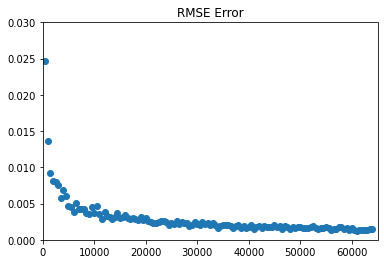

In [21]:
# RMSE Graph
plt.title("RMSE Error")
plt.xlim([0, 65000])
plt.ylim([0,0.03])
plt.scatter(shots, rmse_error)

plt.show()

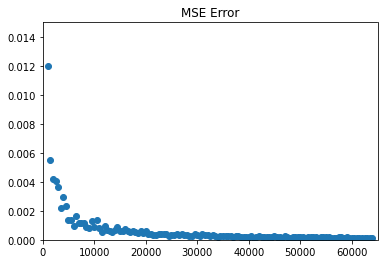

In [23]:
# MSE Graph
plt.title("MSE Error")
plt.xlim([0, 65000])
plt.ylim([0,0.015])
plt.scatter(shots, mse_error)

plt.show()

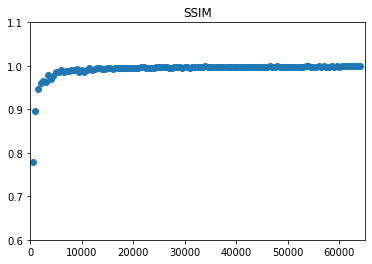

In [25]:
# SSIM Graph
plt.title("SSIM")
plt.xlim([0, 65000])
plt.ylim([0.6,1.1])
plt.scatter(shots, ssim_error)

plt.show()

In [32]:
# Let's do the same thing for a larger image; we want to find a relationship between num of shots and nxn image
# Loading our image in the Quantum State
test_image_16x16 = Image.open('test_image_16x16.tif')
np_test_image_16x16 = np.array(test_image_16x16)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_16x16_final = []
for row in np_test_image_16x16:
    for pixel in row:
        test_image_16x16_final.append( pixel[0] / 256)

np_test_image_16x16 = np.array(test_image_16x16_final)
np_test_image_16x16 = np_test_image_16x16.reshape((16,16))

np_test_image_16x16_normalized = normalize(np_test_image_16x16)
print(np_test_image_16x16_normalized)

[[0.05782764 0.06235047 0.06331965 0.06428883 0.06558107 0.06590413
  0.06719637 0.06655025 0.06719637 0.06751943 0.06719637 0.06622719
  0.06558107 0.06558107 0.06461189 0.06105824]
 [0.06105824 0.06525801 0.06622719 0.06784249 0.0684886  0.06881166
  0.06945778 0.06881166 0.06978084 0.07042696 0.06978084 0.0684886
  0.06881166 0.06881166 0.06913472 0.06590413]
 [0.06202742 0.06751943 0.0684886  0.07042696 0.07075002 0.07107308
  0.0717192  0.07139614 0.0717192  0.07204226 0.07204226 0.07139614
  0.07139614 0.07139614 0.07139614 0.06913472]
 [0.06461189 0.06913472 0.07075002 0.07236532 0.07236532 0.07268838
  0.0733345  0.07301144 0.0733345  0.07398061 0.07494979 0.0733345
  0.07365756 0.07268838 0.07301144 0.07075002]
 [0.06687331 0.07107308 0.07236532 0.0733345  0.07365756 0.07365756
  0.07398061 0.07398061 0.07462673 0.07398061 0.05588929 0.06558107
  0.06687331 0.07591897 0.07365756 0.07204226]
 [0.0684886  0.07268838 0.07301144 0.07430367 0.07398061 0.07398061
  0.07430367 0.0743

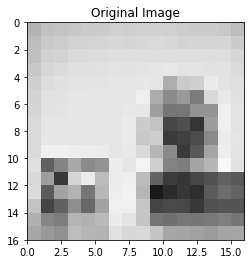

In [30]:
def plot_image16x16(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 16, 16, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image16x16(np_test_image_16x16, "Original Image")   

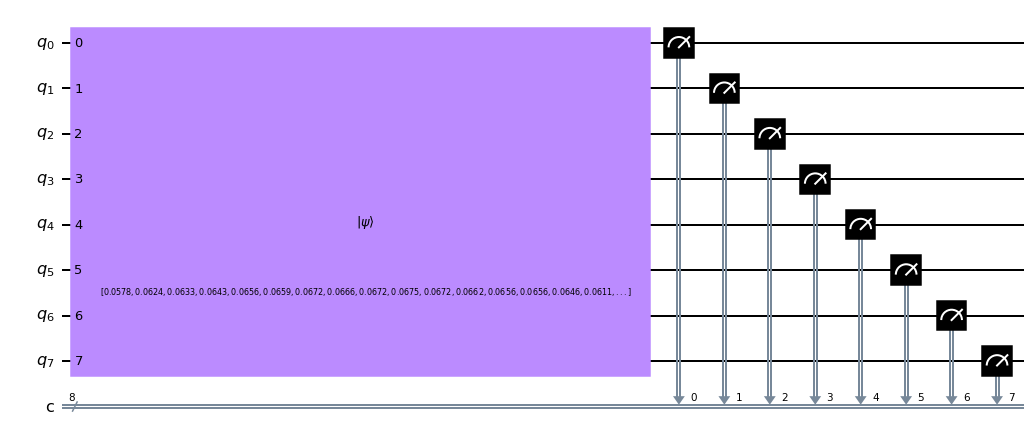

In [34]:
# Our Quantum Circuit that initializes the FRQI image
qc_image_16 = QuantumCircuit(8,8)
qc_image_16.initialize(np_test_image_16x16_normalized.reshape(16**2))
qc_image_16.measure(range(8), range(8))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
#qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])

qc_image_16.draw()

Image recontructed from  500 Shots:


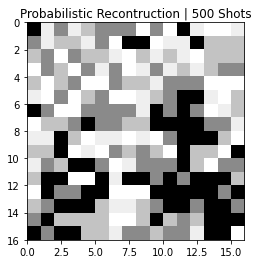

RMSE:  0.02188603578502105  | MSE:  0.12262363197010483  | SSIM:  0.39022700799559984
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  1000 Shots:


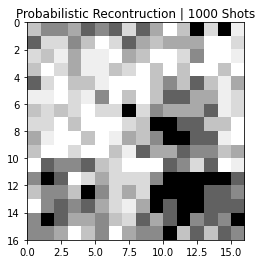

RMSE:  0.014150221425452242  | MSE:  0.05125856419566789  | SSIM:  0.548721992850458
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  1500 Shots:


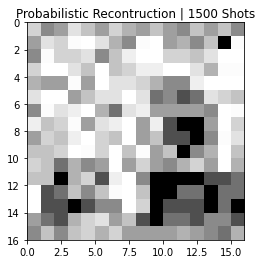

RMSE:  0.011325647029365202  | MSE:  0.032837191842244824  | SSIM:  0.6325708734064132
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  2000 Shots:


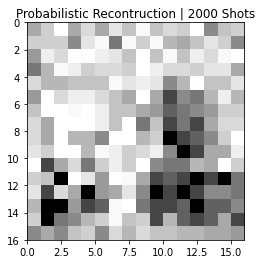

RMSE:  0.00924071740232112  | MSE:  0.021860059676047455  | SSIM:  0.6971317396696216
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  2500 Shots:


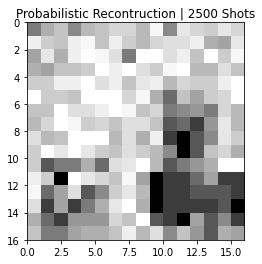

RMSE:  0.00801783169263792  | MSE:  0.016457120013176077  | SSIM:  0.7452710940107811
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  3000 Shots:


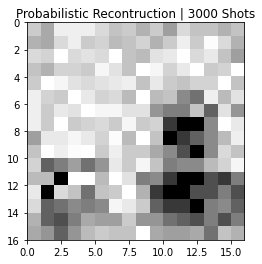

RMSE:  0.0073271753374667715  | MSE:  0.013743999597051212  | SSIM:  0.7624258506432534
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  3500 Shots:


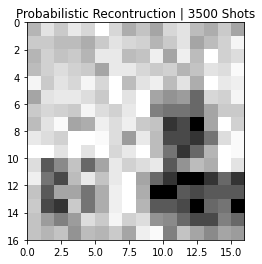

RMSE:  0.006410445031544842  | MSE:  0.010520014208629237  | SSIM:  0.7924696902854056
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  4000 Shots:


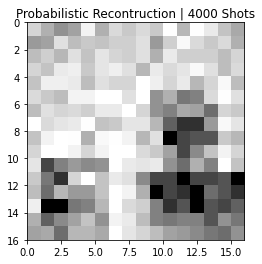

RMSE:  0.006506288440787298  | MSE:  0.010836938054328936  | SSIM:  0.8038607432414946
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  4500 Shots:


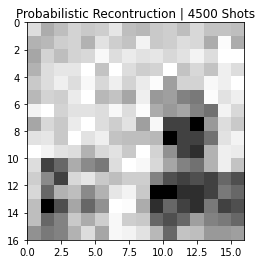

RMSE:  0.005741438674954907  | MSE:  0.008438814222916598  | SSIM:  0.7877565517578975
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  5000 Shots:


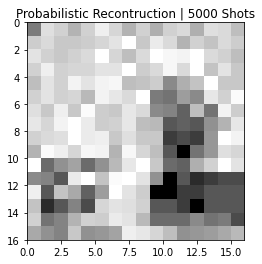

RMSE:  0.005716123873962828  | MSE:  0.00836456246847688  | SSIM:  0.8084946911080954
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  5500 Shots:


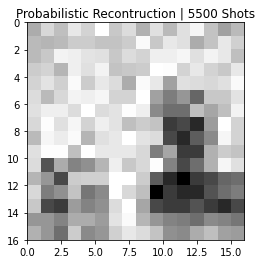

RMSE:  0.005288358010087628  | MSE:  0.007159482993371641  | SSIM:  0.8195488718677475
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  6000 Shots:


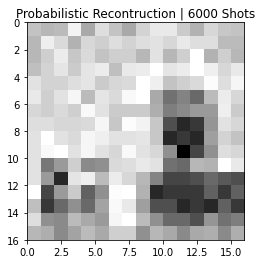

RMSE:  0.004901936088111587  | MSE:  0.006151418217454266  | SSIM:  0.8332905488875773
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  6500 Shots:


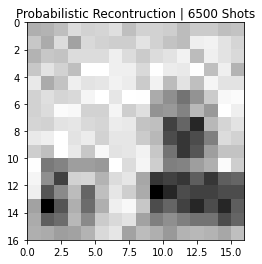

RMSE:  0.004839064746250657  | MSE:  0.005994636190311921  | SSIM:  0.8536413959004799
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  7000 Shots:


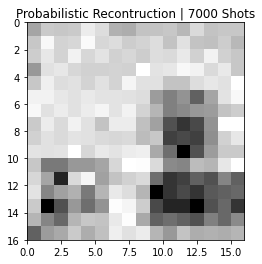

RMSE:  0.00465526289977967  | MSE:  0.005547897002512646  | SSIM:  0.8656265201117723
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  7500 Shots:


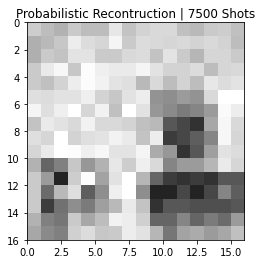

RMSE:  0.004121169910656955  | MSE:  0.0043479146067210905  | SSIM:  0.8551847751509389
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  8000 Shots:


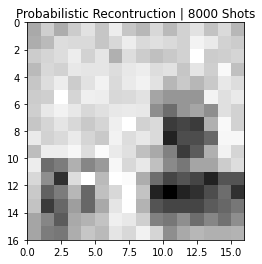

RMSE:  0.0040086600078122194  | MSE:  0.004113754894907664  | SSIM:  0.8752846915248879
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  8500 Shots:


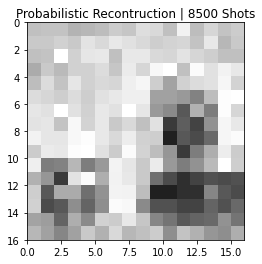

RMSE:  0.0043007748483211445  | MSE:  0.004735146059763652  | SSIM:  0.8616821196934886
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  9000 Shots:


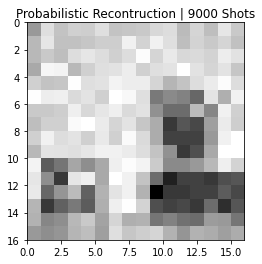

RMSE:  0.0041587253648736194  | MSE:  0.004427519145073463  | SSIM:  0.867125897673083
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  9500 Shots:


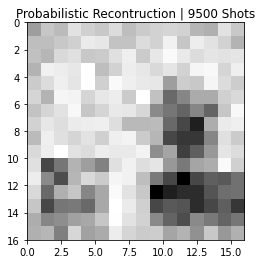

RMSE:  0.004342092249654368  | MSE:  0.004826563866754185  | SSIM:  0.8526910520405531
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  10000 Shots:


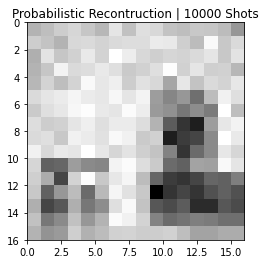

RMSE:  0.00371992364022713  | MSE:  0.003542484963614889  | SSIM:  0.8972839442132963
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  10500 Shots:


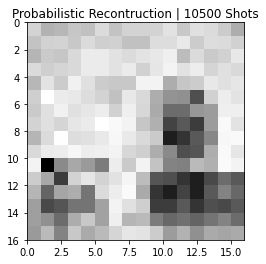

RMSE:  0.0037747110490435123  | MSE:  0.0036476015369654204  | SSIM:  0.882962641390673
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  11000 Shots:


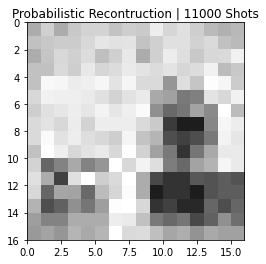

RMSE:  0.0035681388619082295  | MSE:  0.0032592934240920973  | SSIM:  0.8989720066064574
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  11500 Shots:


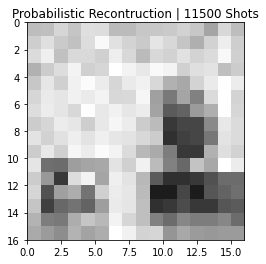

RMSE:  0.0035231571190646894  | MSE:  0.0031776348379177477  | SSIM:  0.8911230695469926
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  12000 Shots:


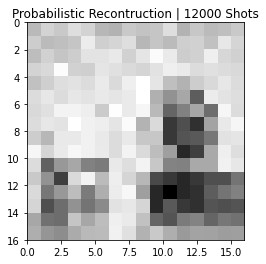

RMSE:  0.003476639243733454  | MSE:  0.0030942772303532862  | SSIM:  0.9002014939933328
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  12500 Shots:


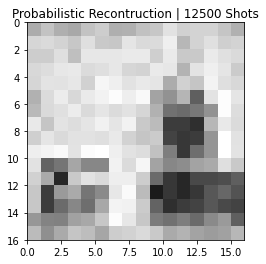

RMSE:  0.003447483370780114  | MSE:  0.003042596247502187  | SSIM:  0.9030226312189457
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  13000 Shots:


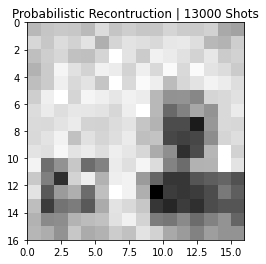

RMSE:  0.0034956187330035227  | MSE:  0.0031281536835904393  | SSIM:  0.8849350856194989
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  13500 Shots:


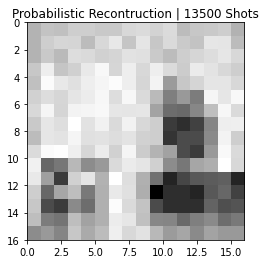

RMSE:  0.0034025681264938158  | MSE:  0.0029638322829904987  | SSIM:  0.9015396027617593
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  14000 Shots:


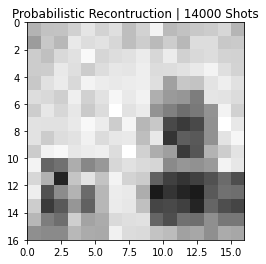

RMSE:  0.00329133643187265  | MSE:  0.0027732212499896798  | SSIM:  0.8940179745496768
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  14500 Shots:


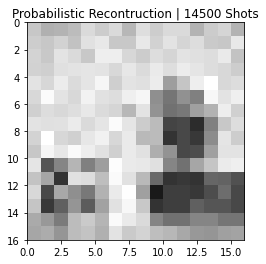

RMSE:  0.0032614461219102452  | MSE:  0.0027230798863675846  | SSIM:  0.8950042616768286
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  15000 Shots:


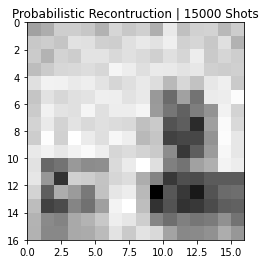

RMSE:  0.0031547346764908358  | MSE:  0.002547801825037757  | SSIM:  0.9181321270658978
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  15500 Shots:


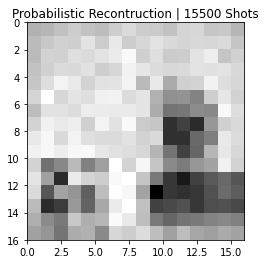

RMSE:  0.0030375750202764414  | MSE:  0.0023620766729747006  | SSIM:  0.9116745073595055
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  16000 Shots:


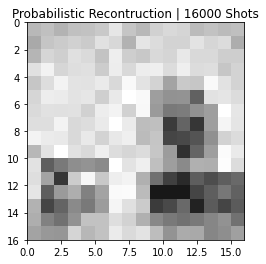

RMSE:  0.003206758982856756  | MSE:  0.0026325256125779195  | SSIM:  0.900782277084233
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  16500 Shots:


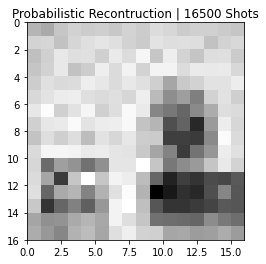

RMSE:  0.002968973567399098  | MSE:  0.0022565898352421188  | SSIM:  0.9043671405606232
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  17000 Shots:


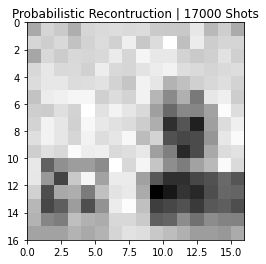

RMSE:  0.0031443108383906403  | MSE:  0.002530992805995738  | SSIM:  0.895805392542865
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  17500 Shots:


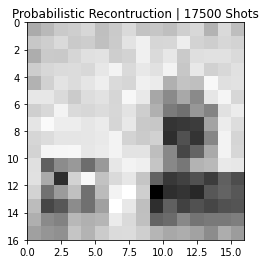

RMSE:  0.0027587875697571832  | MSE:  0.0019483926668919665  | SSIM:  0.9168321665168038
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  18000 Shots:


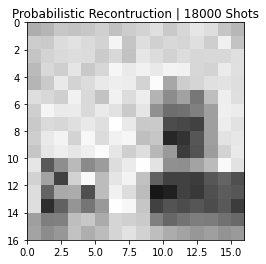

RMSE:  0.0029301215819669984  | MSE:  0.002197916796187849  | SSIM:  0.901325506603373
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  18500 Shots:


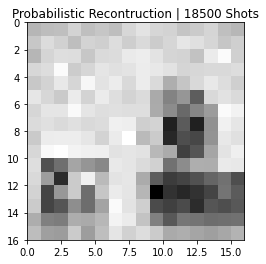

RMSE:  0.0028394580961600318  | MSE:  0.0020640057036412805  | SSIM:  0.9129196482965019
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  19000 Shots:


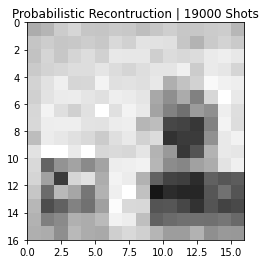

RMSE:  0.0027114203995583365  | MSE:  0.0018820609492841186  | SSIM:  0.9232557549138821
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  19500 Shots:


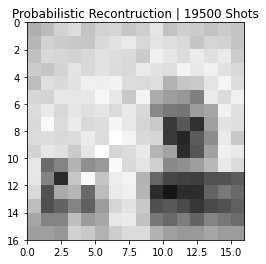

RMSE:  0.0027159507969678654  | MSE:  0.001888355515276898  | SSIM:  0.9161634124340157
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  20000 Shots:


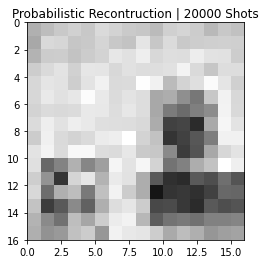

RMSE:  0.002747961130561203  | MSE:  0.0019331303360192527  | SSIM:  0.9188888062211431
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  20500 Shots:


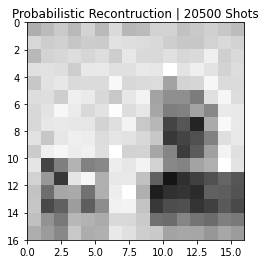

RMSE:  0.002560377673623984  | MSE:  0.001678216660887594  | SSIM:  0.916086365832225
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  21000 Shots:


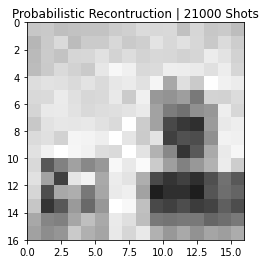

RMSE:  0.002624686746346216  | MSE:  0.001763579012210044  | SSIM:  0.9244605585188643
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  21500 Shots:


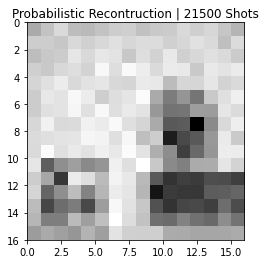

RMSE:  0.002909320007924923  | MSE:  0.002166820584579142  | SSIM:  0.92232776105212
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  22000 Shots:


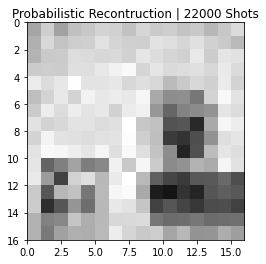

RMSE:  0.00279156185860537  | MSE:  0.0019949613082675885  | SSIM:  0.9281914800254957
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  22500 Shots:


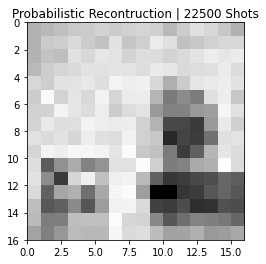

RMSE:  0.002621750736839205  | MSE:  0.0017596356930859299  | SSIM:  0.934658708508994
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  23000 Shots:


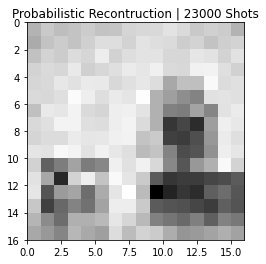

RMSE:  0.002538501300230913  | MSE:  0.0016496611459261533  | SSIM:  0.9367297666136524
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  23500 Shots:


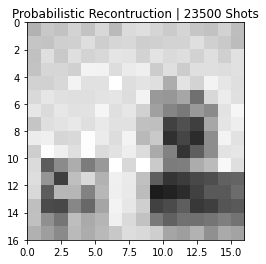

RMSE:  0.002466158516001548  | MSE:  0.0015569760834680208  | SSIM:  0.9280410235413926
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  24000 Shots:


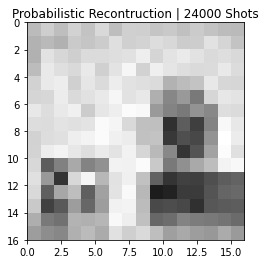

RMSE:  0.0023687959467805202  | MSE:  0.0014364657247958581  | SSIM:  0.9254820230728513
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  24500 Shots:


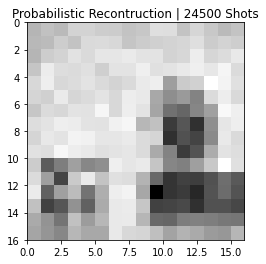

RMSE:  0.0022879604933098885  | MSE:  0.0013400993840503878  | SSIM:  0.9370475712918005
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  25000 Shots:


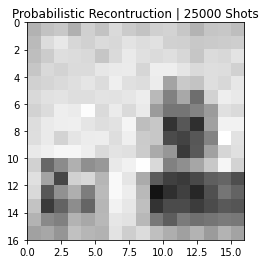

RMSE:  0.002212408119232852  | MSE:  0.0012530559196281457  | SSIM:  0.9424129519600681
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  25500 Shots:


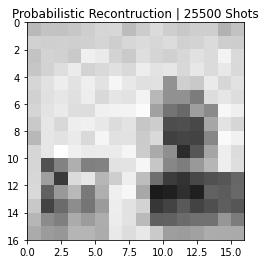

RMSE:  0.002303378434606235  | MSE:  0.001358221366530322  | SSIM:  0.9371767989680109
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  26000 Shots:


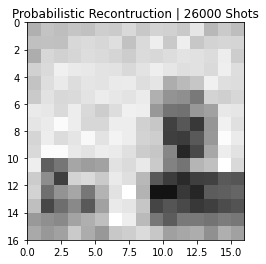

RMSE:  0.0024819306657060405  | MSE:  0.0015769548363192395  | SSIM:  0.9351253588820676
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  26500 Shots:


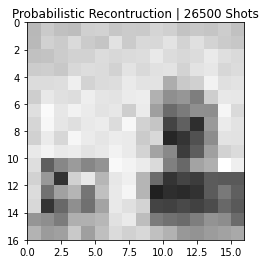

RMSE:  0.002186621725869907  | MSE:  0.0012240165304438504  | SSIM:  0.9439056164655508
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  27000 Shots:


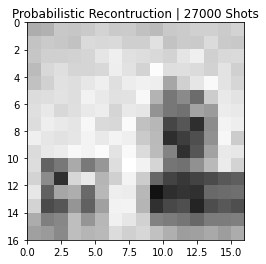

RMSE:  0.002407060197557548  | MSE:  0.00148324833143444  | SSIM:  0.9410802572784971
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  27500 Shots:


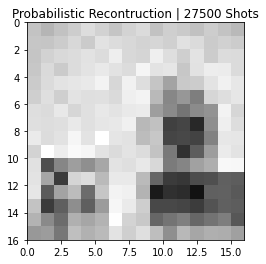

RMSE:  0.0023473611706468357  | MSE:  0.0014105867431578839  | SSIM:  0.9377675656430202
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  28000 Shots:


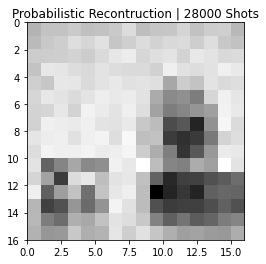

RMSE:  0.002218554103274637  | MSE:  0.0012600274711441226  | SSIM:  0.9506651729340995
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  28500 Shots:


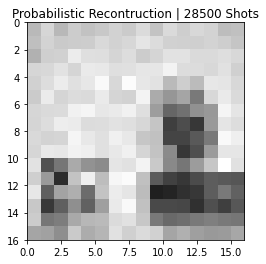

RMSE:  0.0021094291028185656  | MSE:  0.0011391209317933924  | SSIM:  0.9330040021118264
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  29000 Shots:


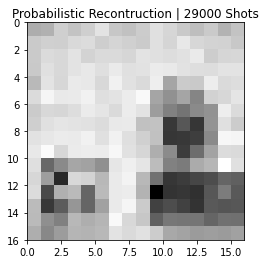

RMSE:  0.002213554382164621  | MSE:  0.0012543546887168508  | SSIM:  0.947836473863006
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  29500 Shots:


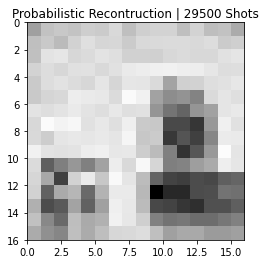

RMSE:  0.002222136953905805  | MSE:  0.0012641005163299252  | SSIM:  0.9459540269335556
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  30000 Shots:


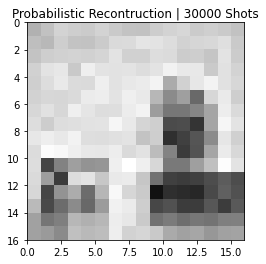

RMSE:  0.0022626208988445243  | MSE:  0.0013105800529633288  | SSIM:  0.9392478605887501
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  30500 Shots:


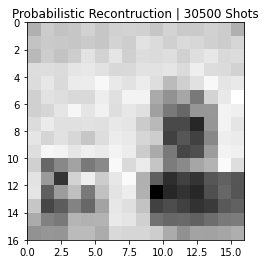

RMSE:  0.002245412243365888  | MSE:  0.001290720292520302  | SSIM:  0.9410443362648396
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  31000 Shots:


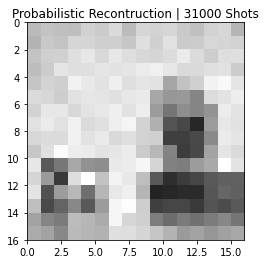

RMSE:  0.0019961211331673296  | MSE:  0.0010200318920389694  | SSIM:  0.9494063899423483
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  31500 Shots:


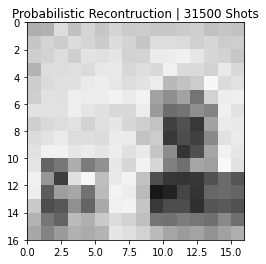

RMSE:  0.00213196205908581  | MSE:  0.0011635871286736399  | SSIM:  0.9451774648825603
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  32000 Shots:


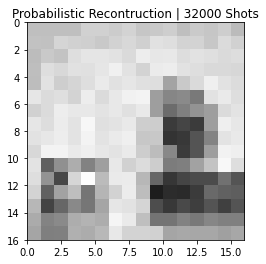

RMSE:  0.0020687786635279247  | MSE:  0.0010956403606191068  | SSIM:  0.9510120447652841
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  32500 Shots:


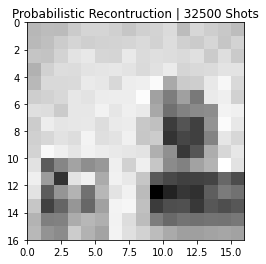

RMSE:  0.002096045110956525  | MSE:  0.0011247117074341766  | SSIM:  0.9567365799138792
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  33000 Shots:


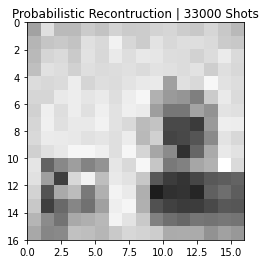

RMSE:  0.0020744946182267516  | MSE:  0.0011017031477892493  | SSIM:  0.9476261871690178
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  33500 Shots:


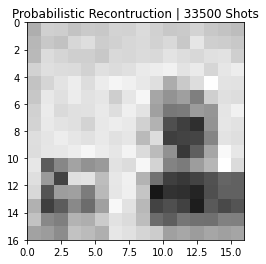

RMSE:  0.0019697403988935876  | MSE:  0.0009932485731925685  | SSIM:  0.9493910799361994
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  34000 Shots:


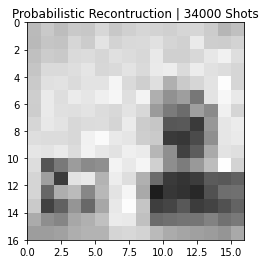

RMSE:  0.0020875053003257447  | MSE:  0.0011155656649953479  | SSIM:  0.9435726343908867
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  34500 Shots:


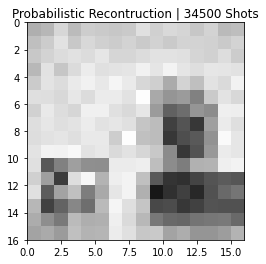

RMSE:  0.002171370722622069  | MSE:  0.0012070018086554335  | SSIM:  0.9391733982451929
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  35000 Shots:


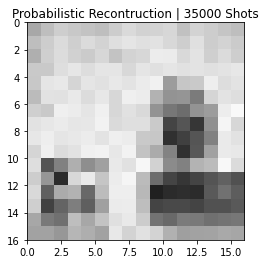

RMSE:  0.0020155243947076198  | MSE:  0.0010399586779293484  | SSIM:  0.9377540151358096
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  35500 Shots:


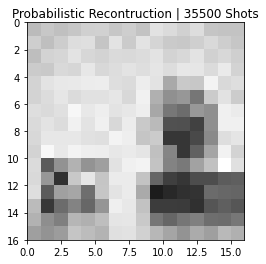

RMSE:  0.0019482489900620264  | MSE:  0.0009716925765830927  | SSIM:  0.9541744404677988
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  36000 Shots:


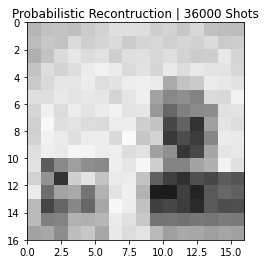

RMSE:  0.0019015803334141968  | MSE:  0.0009256979876934779  | SSIM:  0.9529561135991442
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  36500 Shots:


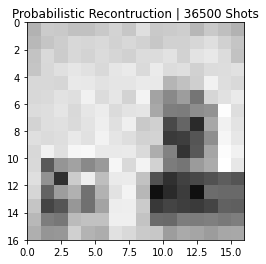

RMSE:  0.001967310883183862  | MSE:  0.0009907999004399785  | SSIM:  0.9574663869179499
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  37000 Shots:


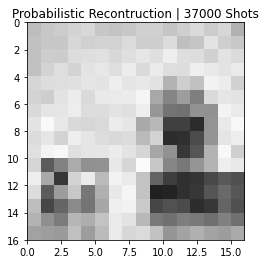

RMSE:  0.0021454172667020144  | MSE:  0.0011783207035553646  | SSIM:  0.9499240135302531
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  37500 Shots:


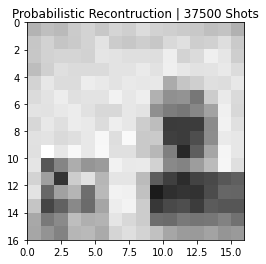

RMSE:  0.0018514944689434132  | MSE:  0.0008775761327431813  | SSIM:  0.95646988365342
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  38000 Shots:


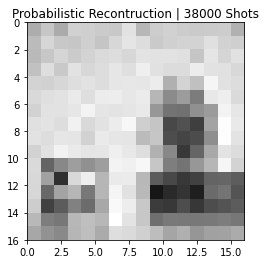

RMSE:  0.0019804696660876346  | MSE:  0.0010040985851630763  | SSIM:  0.9573393942223144
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  38500 Shots:


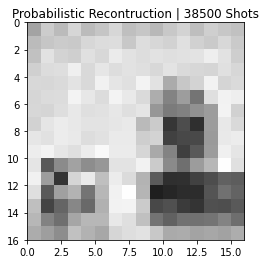

RMSE:  0.0019410783588282487  | MSE:  0.00096455300994851  | SSIM:  0.9514949740414619
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  39000 Shots:


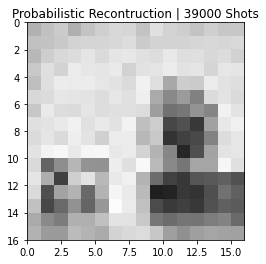

RMSE:  0.0018045067720163814  | MSE:  0.0008335986407047631  | SSIM:  0.9552222770118617
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  39500 Shots:


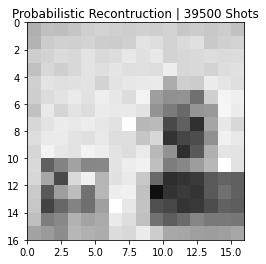

RMSE:  0.001882720766953262  | MSE:  0.0009074271964971723  | SSIM:  0.9606299722141814
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  40000 Shots:


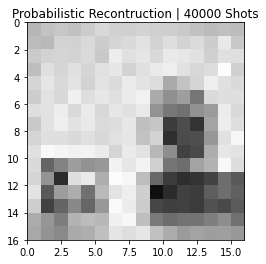

RMSE:  0.002004804019621007  | MSE:  0.001028925224214668  | SSIM:  0.9519638512496772
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  40500 Shots:


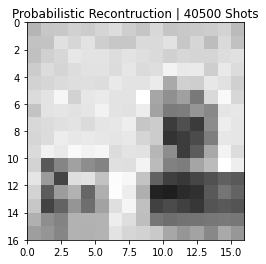

RMSE:  0.0019067817256823015  | MSE:  0.0009307690366453699  | SSIM:  0.9516694676250578
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  41000 Shots:


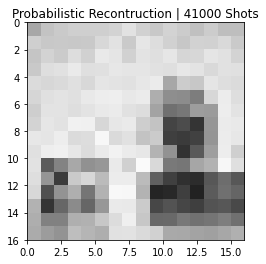

RMSE:  0.001813860214861435  | MSE:  0.0008422627530386359  | SSIM:  0.9532105991906792
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  41500 Shots:


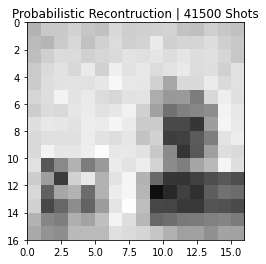

RMSE:  0.0018145980893187496  | MSE:  0.0008429481537943696  | SSIM:  0.9501476334028319
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  42000 Shots:


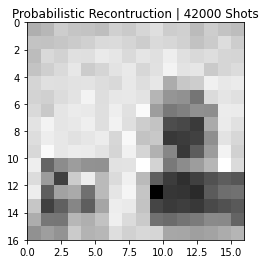

RMSE:  0.002014865543022419  | MSE:  0.0010392788880535108  | SSIM:  0.9490426106577966
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  42500 Shots:


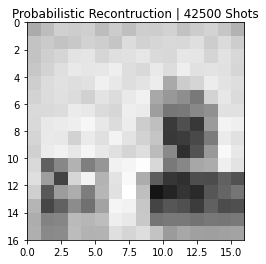

RMSE:  0.0017898817774932825  | MSE:  0.0008201412550150432  | SSIM:  0.949665451743913
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  43000 Shots:


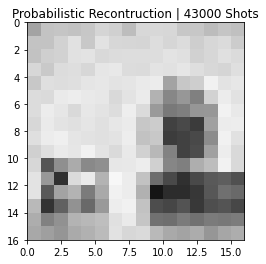

RMSE:  0.0016384722587145788  | MSE:  0.0006872553836997769  | SSIM:  0.9661597995193688
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  43500 Shots:


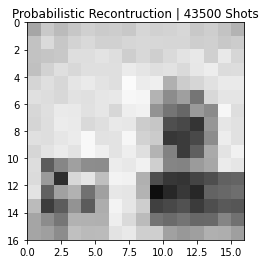

RMSE:  0.0018392347896822813  | MSE:  0.0008659928605638721  | SSIM:  0.9571546964984863
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  44000 Shots:


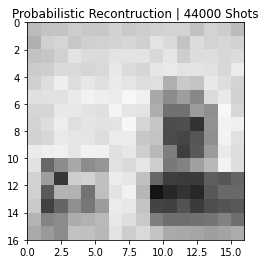

RMSE:  0.001741901374933687  | MSE:  0.0007767604223989426  | SSIM:  0.9596773011751383
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  44500 Shots:


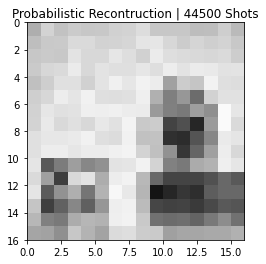

RMSE:  0.0018032096771660254  | MSE:  0.0008324006757952515  | SSIM:  0.9567244785144434
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  45000 Shots:


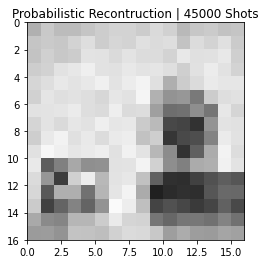

RMSE:  0.001793476908143837  | MSE:  0.0008234392115315653  | SSIM:  0.9589922778809852
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  45500 Shots:


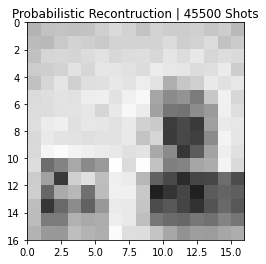

RMSE:  0.0017707968866342537  | MSE:  0.0008027447331106728  | SSIM:  0.965028346598645
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  46000 Shots:


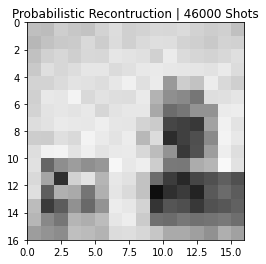

RMSE:  0.0017798702250728883  | MSE:  0.0008109921326338596  | SSIM:  0.9585940207225101
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  46500 Shots:


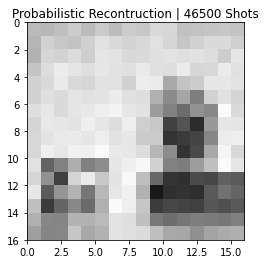

RMSE:  0.0017490117025118035  | MSE:  0.0007831147354939488  | SSIM:  0.9565035134149413
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  47000 Shots:


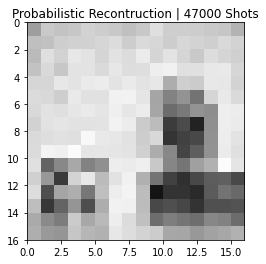

RMSE:  0.0017912159277488943  | MSE:  0.0008213643519542611  | SSIM:  0.9591811072445148
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  47500 Shots:


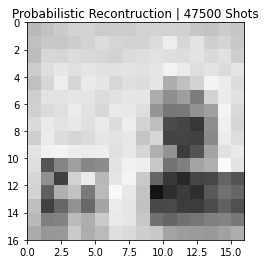

RMSE:  0.001642033020902303  | MSE:  0.000690245745083787  | SSIM:  0.9635762679144274
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  48000 Shots:


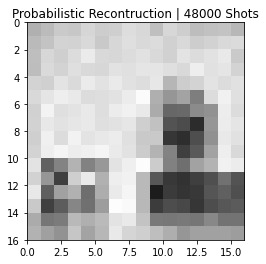

RMSE:  0.001835695033485404  | MSE:  0.0008626627215265224  | SSIM:  0.9603333657381661
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  48500 Shots:


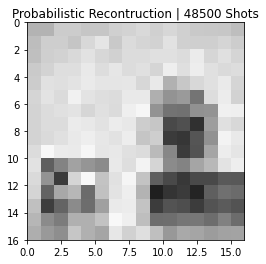

RMSE:  0.0016324099609575987  | MSE:  0.0006821791438421988  | SSIM:  0.9618838281164952
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  49000 Shots:


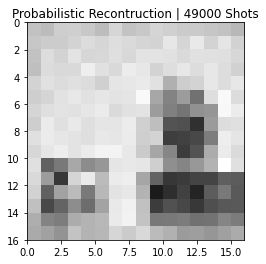

RMSE:  0.0016944559284927739  | MSE:  0.0007350223087627029  | SSIM:  0.9612996229737224
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  49500 Shots:


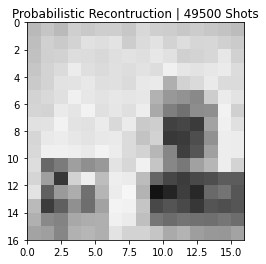

RMSE:  0.0015726416191416729  | MSE:  0.000633139625537675  | SSIM:  0.9657935797455791
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  50000 Shots:


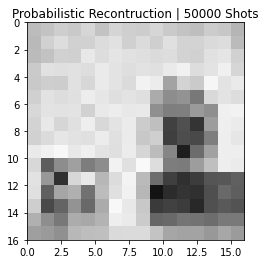

RMSE:  0.0018395568133075574  | MSE:  0.0008662961329628814  | SSIM:  0.9526735969306023
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  50500 Shots:


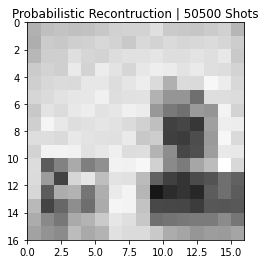

RMSE:  0.0016251282402819094  | MSE:  0.0006761067001246144  | SSIM:  0.9637437509342012
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  51000 Shots:


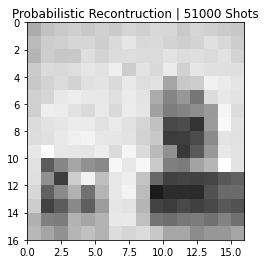

RMSE:  0.0017364781360694544  | MSE:  0.0007719312171640951  | SSIM:  0.9543559074654699
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  51500 Shots:


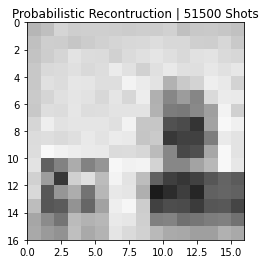

RMSE:  0.0016109677752215745  | MSE:  0.0006643755962374014  | SSIM:  0.9654746465057893
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  52000 Shots:


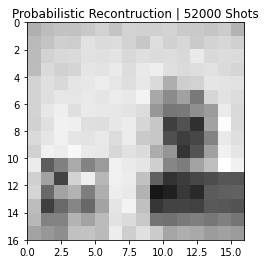

RMSE:  0.0015746733257996535  | MSE:  0.0006347765972441451  | SSIM:  0.9681206971967973
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  52500 Shots:


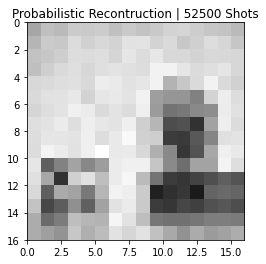

RMSE:  0.001760614615389767  | MSE:  0.0007935395389245585  | SSIM:  0.9621956580213129
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  53000 Shots:


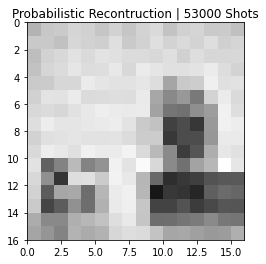

RMSE:  0.0015938403896531039  | MSE:  0.0006503237600485268  | SSIM:  0.9648446020873526
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  53500 Shots:


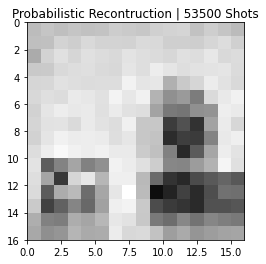

RMSE:  0.001694002670760246  | MSE:  0.0007346291324269686  | SSIM:  0.967292586351027
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  54000 Shots:


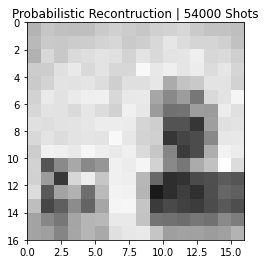

RMSE:  0.001752971741300548  | MSE:  0.0007866649410043585  | SSIM:  0.9513888102271199
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  54500 Shots:


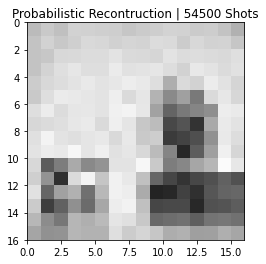

RMSE:  0.0015601595059671046  | MSE:  0.0006231290071192371  | SSIM:  0.9686379699237648
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  55000 Shots:


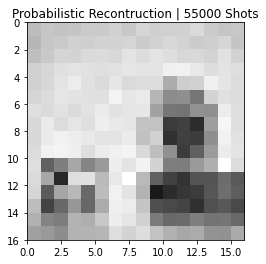

RMSE:  0.0015455431336120966  | MSE:  0.0006115081159310077  | SSIM:  0.9697369254556638
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  55500 Shots:


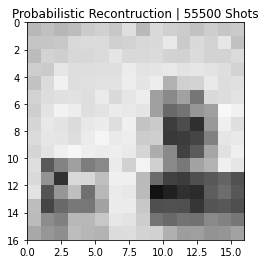

RMSE:  0.0017692165892032865  | MSE:  0.0008013125989151003  | SSIM:  0.9638611018702474
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  56000 Shots:


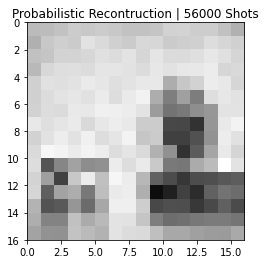

RMSE:  0.0015528376946995703  | MSE:  0.0006172940559564481  | SSIM:  0.9737832293247886
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  56500 Shots:


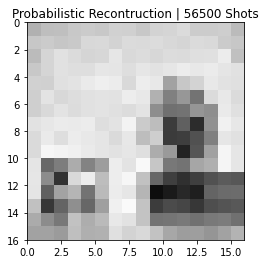

RMSE:  0.0016230929777372076  | MSE:  0.000674414288481238  | SSIM:  0.9669747523182576
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  57000 Shots:


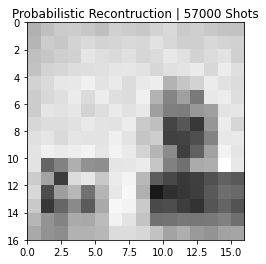

RMSE:  0.001549326456559347  | MSE:  0.0006145055920626539  | SSIM:  0.9673697609015971
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  57500 Shots:


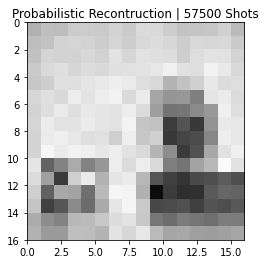

RMSE:  0.0015648787918726029  | MSE:  0.0006269044821126802  | SSIM:  0.966672867145085
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  58000 Shots:


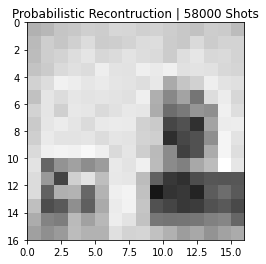

RMSE:  0.0016233212113433025  | MSE:  0.0006746039693304543  | SSIM:  0.9631786301965328
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  58500 Shots:


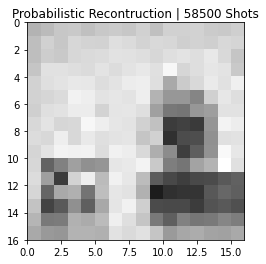

RMSE:  0.0016939583738309972  | MSE:  0.0007345907129016721  | SSIM:  0.9595953325823965
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  59000 Shots:


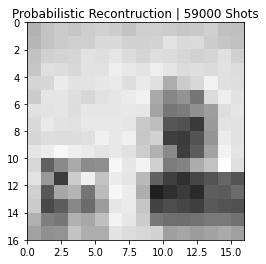

RMSE:  0.001463867570005209  | MSE:  0.0005485845152033166  | SSIM:  0.9716185773151704
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  59500 Shots:


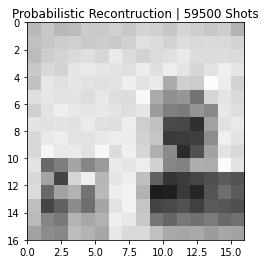

RMSE:  0.0015571695239904643  | MSE:  0.0006207428931698405  | SSIM:  0.9692361733251085
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  60000 Shots:


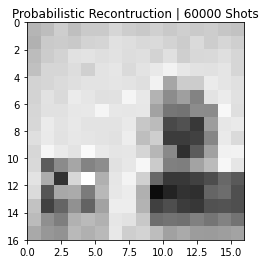

RMSE:  0.0015059065221705626  | MSE:  0.0005805451401000548  | SSIM:  0.972373172080272
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  60500 Shots:


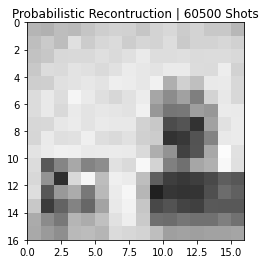

RMSE:  0.0015349194716797801  | MSE:  0.0006031303128426842  | SSIM:  0.964544222505246
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  61000 Shots:


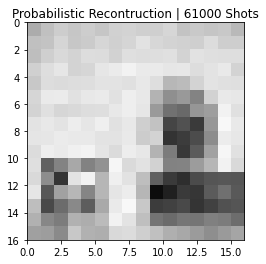

RMSE:  0.0015936343098717533  | MSE:  0.0006501556002817073  | SSIM:  0.9612643224212511
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  61500 Shots:


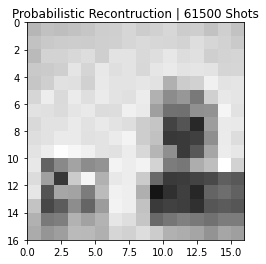

RMSE:  0.001521081662677317  | MSE:  0.0005923044926804969  | SSIM:  0.9674454232013839
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  62000 Shots:


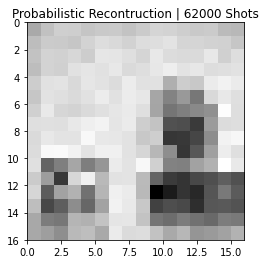

RMSE:  0.0016603080371160876  | MSE:  0.0007056954311967426  | SSIM:  0.9616038948278134
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  62500 Shots:


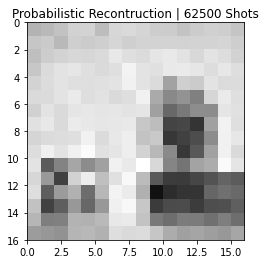

RMSE:  0.001463236231535426  | MSE:  0.0005481114289351667  | SSIM:  0.9672812227415669
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  63000 Shots:


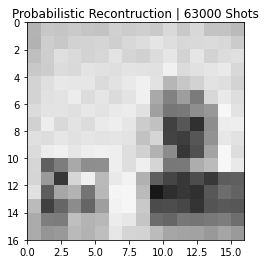

RMSE:  0.0014259087683117595  | MSE:  0.0005205032487803799  | SSIM:  0.9726212344029661
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  63500 Shots:


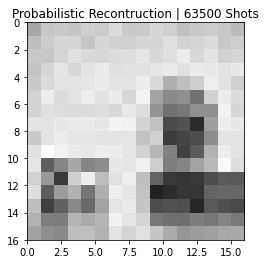

RMSE:  0.0015272369005454205  | MSE:  0.0005971078528992212  | SSIM:  0.9664699616527215
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  64000 Shots:


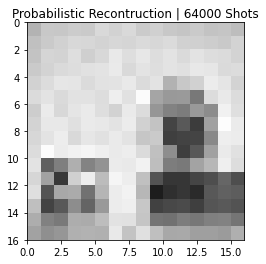

RMSE:  0.0014600032542951642  | MSE:  0.0005456920326534323  | SSIM:  0.9649395961413068
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  64500 Shots:


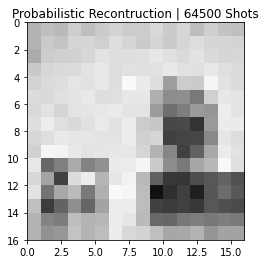

RMSE:  0.001526742901305756  | MSE:  0.0005967216349920043  | SSIM:  0.9712411737608542
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  65000 Shots:


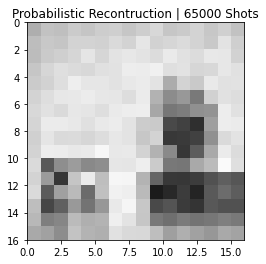

RMSE:  0.0014815755289079178  | MSE:  0.0005619369082518467  | SSIM:  0.9691030252046758
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  65500 Shots:


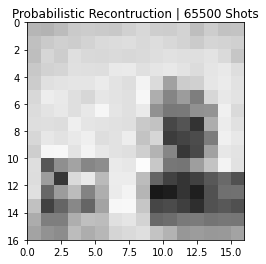

RMSE:  0.0015646885825795413  | MSE:  0.0006267520922764221  | SSIM:  0.9669421484829744
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  66000 Shots:


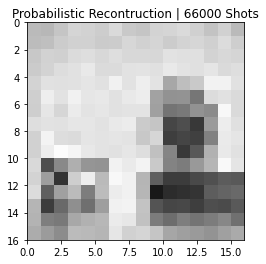

RMSE:  0.0014817910271186087  | MSE:  0.0005621003899006006  | SSIM:  0.9714749375562773
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  66500 Shots:


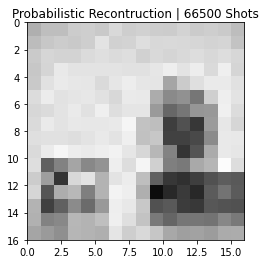

RMSE:  0.0013944781977105283  | MSE:  0.0004978097776358408  | SSIM:  0.9718882169619057
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  67000 Shots:


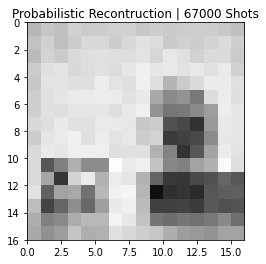

RMSE:  0.001427988762919879  | MSE:  0.0005220228881985143  | SSIM:  0.9713132462098514
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  67500 Shots:


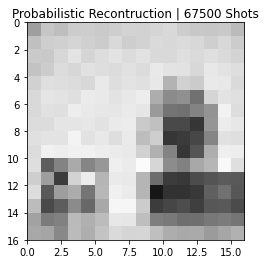

RMSE:  0.0013613063119264324  | MSE:  0.0004744076479720309  | SSIM:  0.9772834544312743
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  68000 Shots:


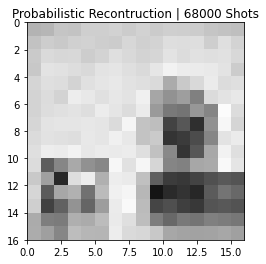

RMSE:  0.0014927568335303854  | MSE:  0.0005704506787972256  | SSIM:  0.9682066009016173
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  68500 Shots:


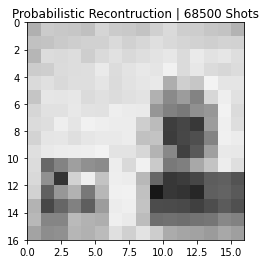

RMSE:  0.001523663243090458  | MSE:  0.0005943167176563028  | SSIM:  0.9702611418273002
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  69000 Shots:


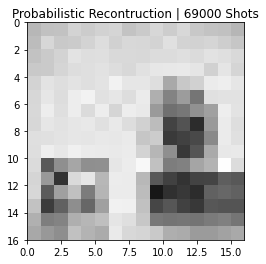

RMSE:  0.0013216835457095857  | MSE:  0.00044719293311986237  | SSIM:  0.9678754225702582
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  69500 Shots:


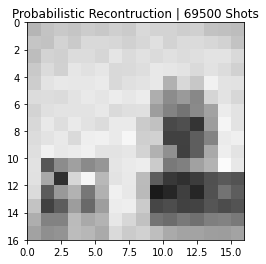

RMSE:  0.0014355204243991207  | MSE:  0.0005275440355499601  | SSIM:  0.9693124596609767
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  70000 Shots:


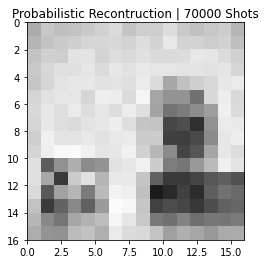

RMSE:  0.001534156199759428  | MSE:  0.0006025306227866343  | SSIM:  0.9690979206034699
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  70500 Shots:


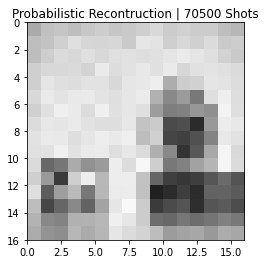

RMSE:  0.0014741792897101315  | MSE:  0.0005563403720218286  | SSIM:  0.9665385361707896
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  71000 Shots:


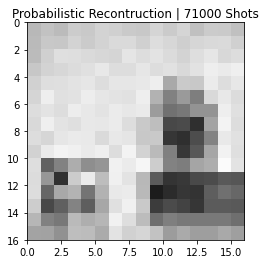

RMSE:  0.0013872879595482554  | MSE:  0.0004926893779731358  | SSIM:  0.9739932931251599
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  71500 Shots:


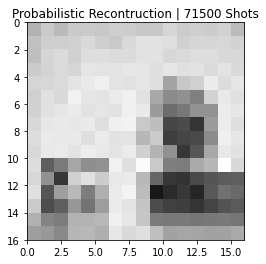

RMSE:  0.0013399300577958374  | MSE:  0.0004596256153048976  | SSIM:  0.9723107149885294
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  72000 Shots:


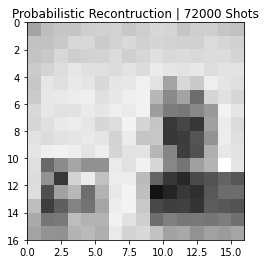

RMSE:  0.0015612565970480438  | MSE:  0.0006240056734274657  | SSIM:  0.964621794301258
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  72500 Shots:


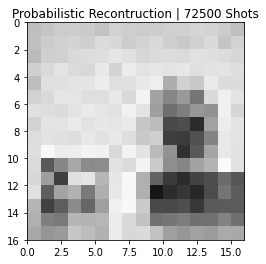

RMSE:  0.0014396848412658353  | MSE:  0.0005306092651956822  | SSIM:  0.9695855246602789
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  73000 Shots:


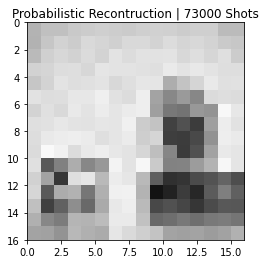

RMSE:  0.001299926791620123  | MSE:  0.00043259127387437746  | SSIM:  0.9750361029735986
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  73500 Shots:


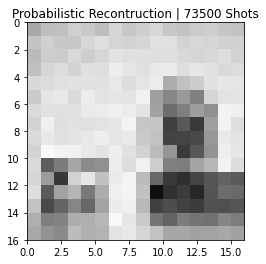

RMSE:  0.001406644668323662  | MSE:  0.0005065342010683865  | SSIM:  0.9721768380115556
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  74000 Shots:


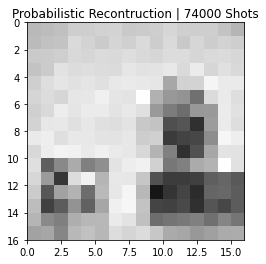

RMSE:  0.00149331037117852  | MSE:  0.0005708738213553484  | SSIM:  0.9740739187005125
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  74500 Shots:


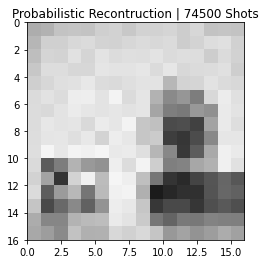

RMSE:  0.0014914986330904444  | MSE:  0.00056948945216273  | SSIM:  0.9655115718307803
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  75000 Shots:


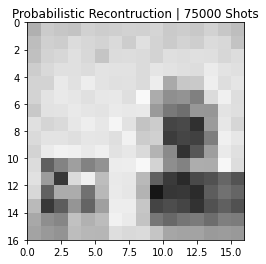

RMSE:  0.0014112543826611172  | MSE:  0.000509859566740534  | SSIM:  0.9694982310696711
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  75500 Shots:


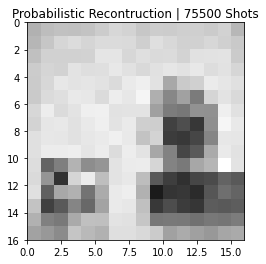

RMSE:  0.0013628245285237357  | MSE:  0.00047546641805976125  | SSIM:  0.9710190438928286
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  76000 Shots:


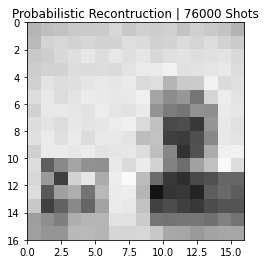

RMSE:  0.0013985190621241897  | MSE:  0.0005006990251839291  | SSIM:  0.9718724675153274
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  76500 Shots:


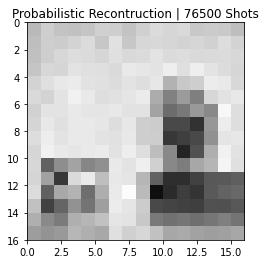

RMSE:  0.00135164019657828  | MSE:  0.0004676943925775799  | SSIM:  0.9744192322281547
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  77000 Shots:


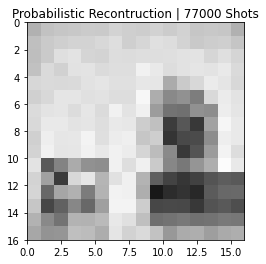

RMSE:  0.0013389618713513924  | MSE:  0.0004589616365908025  | SSIM:  0.9703368554903798
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  77500 Shots:


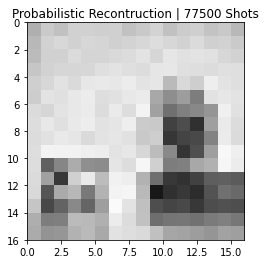

RMSE:  0.001336990076868039  | MSE:  0.00045761087120476285  | SSIM:  0.9744442142383629
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  78000 Shots:


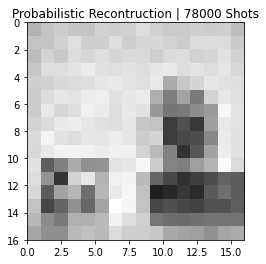

RMSE:  0.0014013273365271058  | MSE:  0.000502711885849127  | SSIM:  0.9682217119968941
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  78500 Shots:


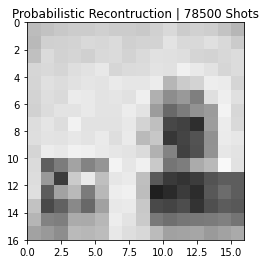

RMSE:  0.001328129870505262  | MSE:  0.000451565811949651  | SSIM:  0.9759755095702175
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  79000 Shots:


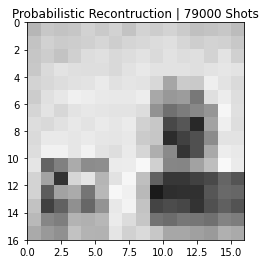

RMSE:  0.001262327451739883  | MSE:  0.0004079284724265234  | SSIM:  0.9767430195577301
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  79500 Shots:


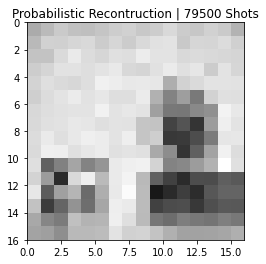

RMSE:  0.001433903573586246  | MSE:  0.0005263563413359122  | SSIM:  0.9672196368684913
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  80000 Shots:


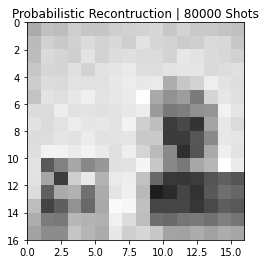

RMSE:  0.0013422402148174162  | MSE:  0.00046121185133391455  | SSIM:  0.9753126618892438
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  80500 Shots:


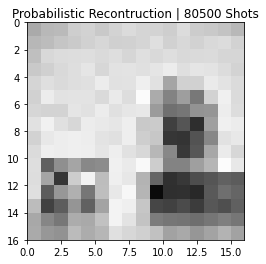

RMSE:  0.0014312991479912076  | MSE:  0.0005244460162663314  | SSIM:  0.9693109218462745
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  81000 Shots:


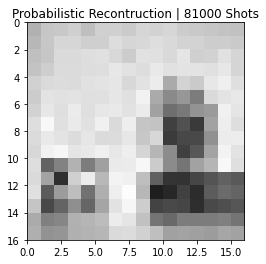

RMSE:  0.0013420779132427179  | MSE:  0.00046110032005476566  | SSIM:  0.9721903300703941
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  81500 Shots:


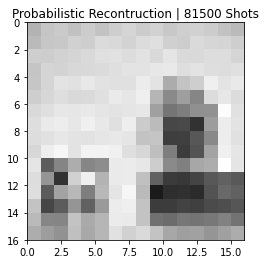

RMSE:  0.0012671560203171065  | MSE:  0.0004110552012354271  | SSIM:  0.9777314108109256
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  82000 Shots:


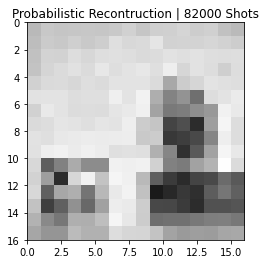

RMSE:  0.0012886076109597793  | MSE:  0.00042509045120600836  | SSIM:  0.9746468589994017
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  82500 Shots:


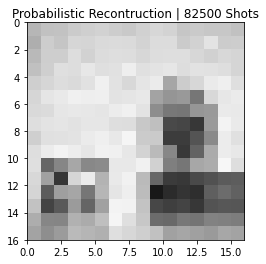

RMSE:  0.0013309042834842143  | MSE:  0.0004534543902199372  | SSIM:  0.9704974806988352
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  83000 Shots:


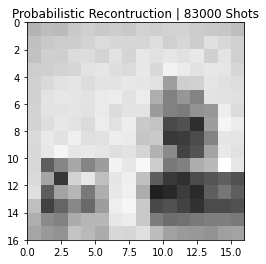

RMSE:  0.0013104084045636485  | MSE:  0.00043959556780826794  | SSIM:  0.9770058448898297
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  83500 Shots:


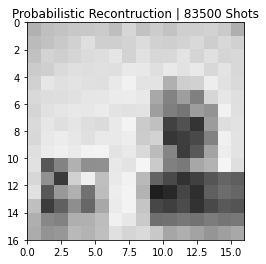

RMSE:  0.0012735524431637566  | MSE:  0.0004152155713250236  | SSIM:  0.9771878037110237
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  84000 Shots:


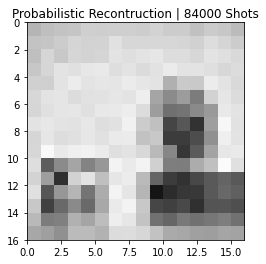

RMSE:  0.0011702419392429146  | MSE:  0.00035058334626893243  | SSIM:  0.9779933379287427
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  84500 Shots:


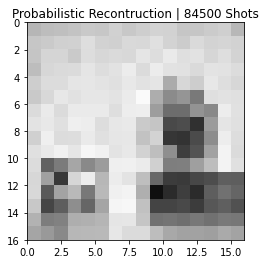

RMSE:  0.0012981491826534433  | MSE:  0.0004314089729084936  | SSIM:  0.9743861983072306
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  85000 Shots:


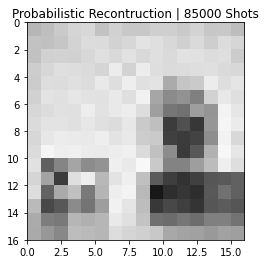

RMSE:  0.0013617696261170932  | MSE:  0.00047473062774146247  | SSIM:  0.9727241154786622
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  85500 Shots:


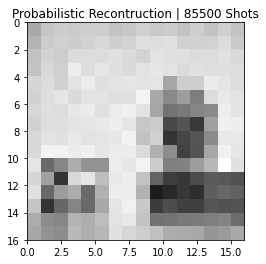

RMSE:  0.001301529755565965  | MSE:  0.00043365880438364185  | SSIM:  0.9749058964434546
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  86000 Shots:


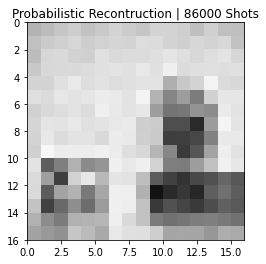

RMSE:  0.0012769164603897744  | MSE:  0.0004174120055844737  | SSIM:  0.9760750477095251
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  86500 Shots:


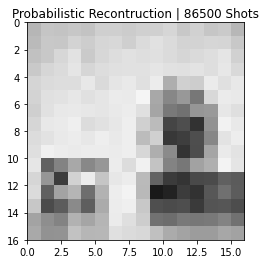

RMSE:  0.0011776357682729793  | MSE:  0.00035502745669526787  | SSIM:  0.978828019015725
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  87000 Shots:


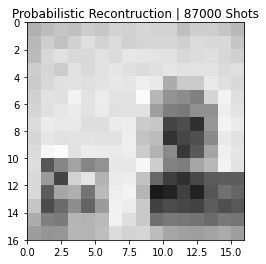

RMSE:  0.0013203342985414035  | MSE:  0.00044628036093563394  | SSIM:  0.9733048922829799
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  87500 Shots:


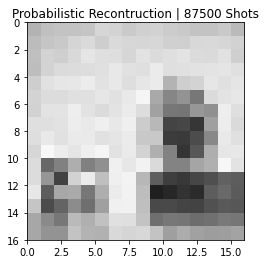

RMSE:  0.0012114978192339445  | MSE:  0.00037573810329820243  | SSIM:  0.9783046533952094
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  88000 Shots:


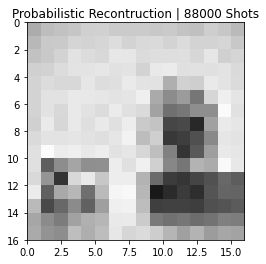

RMSE:  0.0013800013560005162  | MSE:  0.0004875273580961954  | SSIM:  0.9736924273559928
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  88500 Shots:


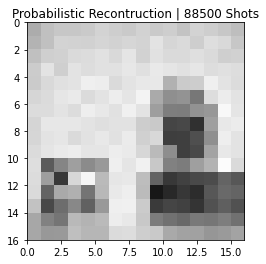

RMSE:  0.0012861193448018321  | MSE:  0.0004234503600828145  | SSIM:  0.97101230853587
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  89000 Shots:


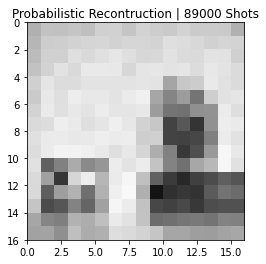

RMSE:  0.0012726551236515306  | MSE:  0.000414630672321662  | SSIM:  0.9776440361803967
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  89500 Shots:


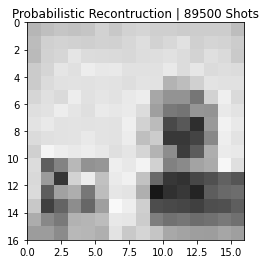

RMSE:  0.0012674541733238933  | MSE:  0.00041124866085789544  | SSIM:  0.9764962474685904
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  90000 Shots:


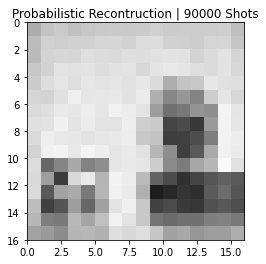

RMSE:  0.0012408851830367012  | MSE:  0.000394187785594887  | SSIM:  0.9813397503641429
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  90500 Shots:


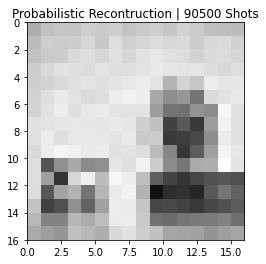

RMSE:  0.0012517040135251187  | MSE:  0.00040109131199357205  | SSIM:  0.9791183459767965
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  91000 Shots:


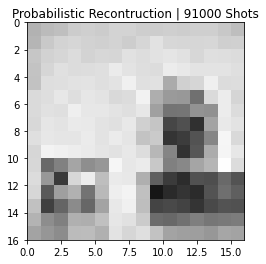

RMSE:  0.0012279448962100677  | MSE:  0.0003860092590408585  | SSIM:  0.9774866208139631
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  91500 Shots:


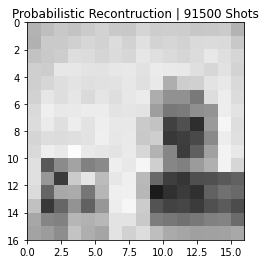

RMSE:  0.0013094787859152697  | MSE:  0.0004389720808351049  | SSIM:  0.9746251265481765
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  92000 Shots:


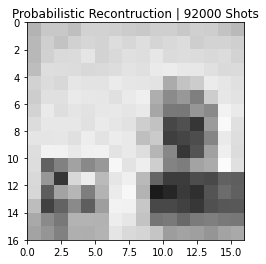

RMSE:  0.0011699701785157339  | MSE:  0.00035042053596573143  | SSIM:  0.9807786097112716
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  92500 Shots:


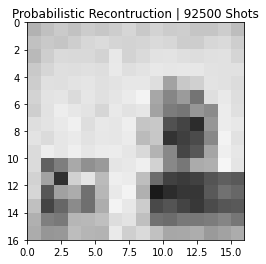

RMSE:  0.0012430372665885902  | MSE:  0.00039555626140877666  | SSIM:  0.9751849082887353
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  93000 Shots:


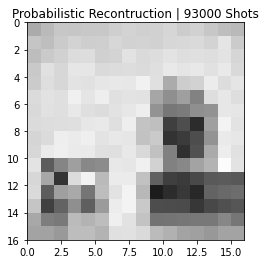

RMSE:  0.001325322139238862  | MSE:  0.00044965856582570847  | SSIM:  0.9721910319831133
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  93500 Shots:


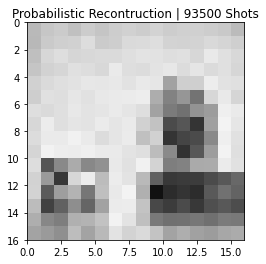

RMSE:  0.001216153711261886  | MSE:  0.000378631641450511  | SSIM:  0.9806430762165228
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  94000 Shots:


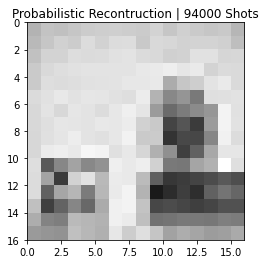

RMSE:  0.001258870166404203  | MSE:  0.0004056970485408116  | SSIM:  0.9813657740245182
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  94500 Shots:


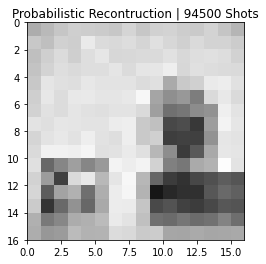

RMSE:  0.0013235980677581483  | MSE:  0.0004484894323131145  | SSIM:  0.9749244467979347
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  95000 Shots:


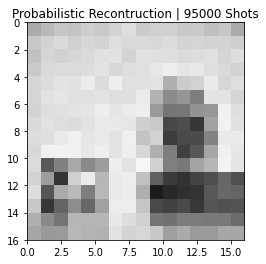

RMSE:  0.0012531396809876863  | MSE:  0.0004020119193768756  | SSIM:  0.9744092100209479
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  95500 Shots:


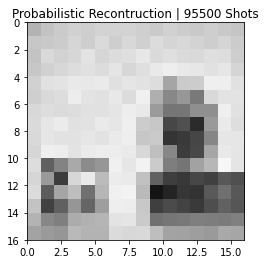

RMSE:  0.0011461054476536647  | MSE:  0.00033627077046820026  | SSIM:  0.978974252739895
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  96000 Shots:


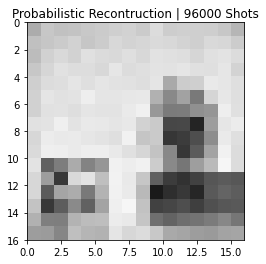

RMSE:  0.0011621291089774176  | MSE:  0.00034573928087875755  | SSIM:  0.9813729404160664
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  96500 Shots:


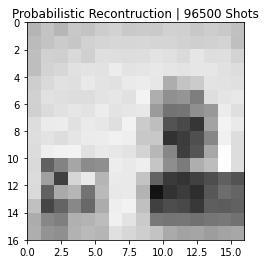

RMSE:  0.001191255013970589  | MSE:  0.0003632866581273775  | SSIM:  0.9809217913512214
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  97000 Shots:


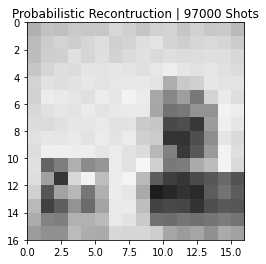

RMSE:  0.0011718346762638534  | MSE:  0.0003515383061745689  | SSIM:  0.9818788218771928
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  97500 Shots:


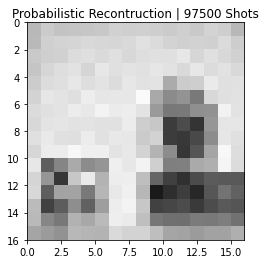

RMSE:  0.0011429492255034509  | MSE:  0.0003344212306122082  | SSIM:  0.9787779633982661
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  98000 Shots:


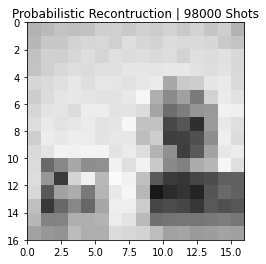

RMSE:  0.0012249816886922712  | MSE:  0.0003841485152336303  | SSIM:  0.9805832632073799
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  98500 Shots:


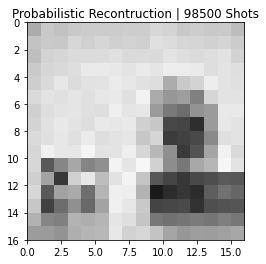

RMSE:  0.001164363884535885  | MSE:  0.0003470702734365428  | SSIM:  0.9788909402760937
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  99000 Shots:


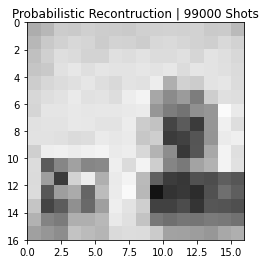

RMSE:  0.0012222147833978812  | MSE:  0.00038241509804962033  | SSIM:  0.9792021000868487
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  99500 Shots:


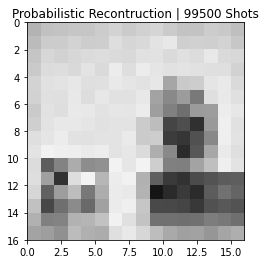

RMSE:  0.0011988580364779113  | MSE:  0.00036793871145668426  | SSIM:  0.9814816602168495
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  100000 Shots:


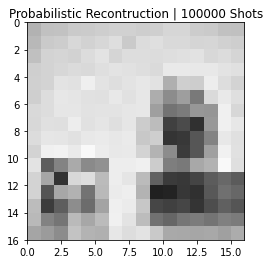

RMSE:  0.0011549638659967304  | MSE:  0.0003414890321300771  | SSIM:  0.9816250082178822
-X-X-X-X-X-X-X-X-X-X-
RMSE Error Values:
[0.02188603578502105, 0.014150221425452242, 0.011325647029365202, 0.00924071740232112, 0.00801783169263792, 0.0073271753374667715, 0.006410445031544842, 0.006506288440787298, 0.005741438674954907, 0.005716123873962828, 0.005288358010087628, 0.004901936088111587, 0.004839064746250657, 0.00465526289977967, 0.004121169910656955, 0.0040086600078122194, 0.0043007748483211445, 0.0041587253648736194, 0.004342092249654368, 0.00371992364022713, 0.0037747110490435123, 0.0035681388619082295, 0.0035231571190646894, 0.003476639243733454, 0.003447483370780114, 0.0034956187330035227, 0.0034025681264938158, 0.00329133643187265, 0.0032614461219102452, 0.0031547346764908358, 0.0030375750202764414, 0.003206758982856756, 0.002968973567399098, 0.0031443108383906403, 0.0027587875697571832, 0.0029301215819669984, 0.0028394580961600318, 0.0027114203995583365, 0.0027159507969678654,

In [39]:
# Now we will see how changing the nuymebrof shots affects these errors:
simulator = Aer.get_backend('aer_simulator')
qc_image_16_transpiled = transpile(qc_image_16, simulator)

shots = np.arange(500, 100001, 500)
rmse_error = []
mse_error = []
ssim_error = []
images = []
for shots_value in shots:
    # Running Quantum Circuit
    result = simulator.run(qc_image_16_transpiled, shots=shots_value).result()
    counts = result.get_counts()
    
    # Recreating the Image from circuit output
    simulator_output = []
    for i in range(256):
        if get_bin(i, 8) in counts:
            simulator_output.append(np.sqrt( ( counts.get(get_bin(i, 8)) / shots_value ) ) )
        else:
            simulator_output.append(0)
        
    np_simulator_output = np.array(simulator_output).reshape((16,16))
    np_simulator_output = normalize(np_simulator_output)
    np_simulator_output_denormalized = denormalize(np_test_image_16x16, np_test_image_16x16_normalized, np_simulator_output, 16)

    images.append(np_simulator_output_denormalized)
    
    #Display Image:
    print("Image recontructed from ", shots_value, "Shots:")
    title_string = "Probabilistic Recontruction | {} Shots".format(shots_value)
    plot_image16x16(np_simulator_output_denormalized, title_string)
    
    #Calculate Errors:
    rmse_simulator = rmse_image_error(np_test_image_16x16, np_simulator_output_denormalized, 16)
    mse_simulator = mse_image_error(np_test_image_16x16, np_simulator_output_denormalized, 16)
    ssim_simulator = ssim(np_test_image_16x16, np_simulator_output_denormalized, data_range=np_simulator_output_denormalized.max() - np_simulator_output_denormalized.min())

    rmse_error.append(rmse_simulator)
    mse_error.append(mse_simulator)
    ssim_error.append(ssim_simulator)
    print("RMSE: ", rmse_simulator, " | MSE: ", mse_simulator, " | SSIM: ", ssim_simulator)
    print("-X-X-X-X-X-X-X-X-X-X-")
    
    
print("RMSE Error Values:")
print(rmse_error)
print("MSE Error Values:")
print(mse_error)
print("SSIM Values:")
print(ssim_error)


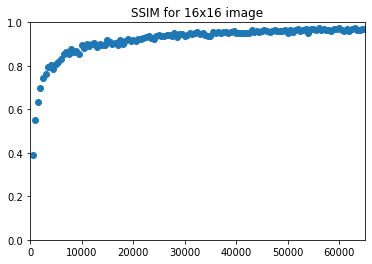

In [40]:
# SSIM Graph
plt.title("SSIM for 16x16 image")
plt.xlim([0, 65000])
plt.ylim([0.0,1.0])
plt.scatter(shots, ssim_error)

plt.show()

In [42]:
# And for 32x32 images
# Let's do the same thing for a larger image; we want to find a relationship between num of shots and nxn image
# Loading our image in the Quantum State
test_image_32x32 = Image.open('clock_test_image_32x32.tif')
np_test_image_32x32 = np.array(test_image_32x32)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_32x32_final = []
for row in np_test_image_32x32:
    for pixel in row:
        test_image_32x32_final.append( pixel[0] / 256)

np_test_image_32x32 = np.array(test_image_32x32_final)
np_test_image_32x32 = np_test_image_32x32.reshape((32,32))

np_test_image_32x32_normalized = normalize(np_test_image_32x32)
print(np_test_image_32x32_normalized)

[[0.02737965 0.02995656 0.0309229  ... 0.03140607 0.03156712 0.02882916]
 [0.02802387 0.03076184 0.03108395 ... 0.03301663 0.03172818 0.03060078]
 [0.02882916 0.03172818 0.03205029 ... 0.03366086 0.03382192 0.03140607]
 ...
 [0.02915127 0.02367534 0.02995656 ... 0.0215816  0.02093738 0.01997104]
 [0.0275407  0.02512485 0.02367534 ... 0.02480274 0.02448063 0.02415851]
 [0.02737965 0.02625225 0.02609119 ... 0.0286681  0.02770176 0.02850704]]


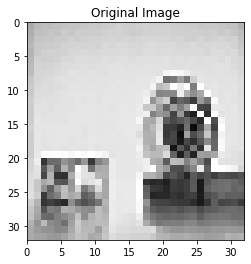

In [43]:
def plot_image32x32(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 32, 32, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image32x32(np_test_image_32x32, "Original Image")   

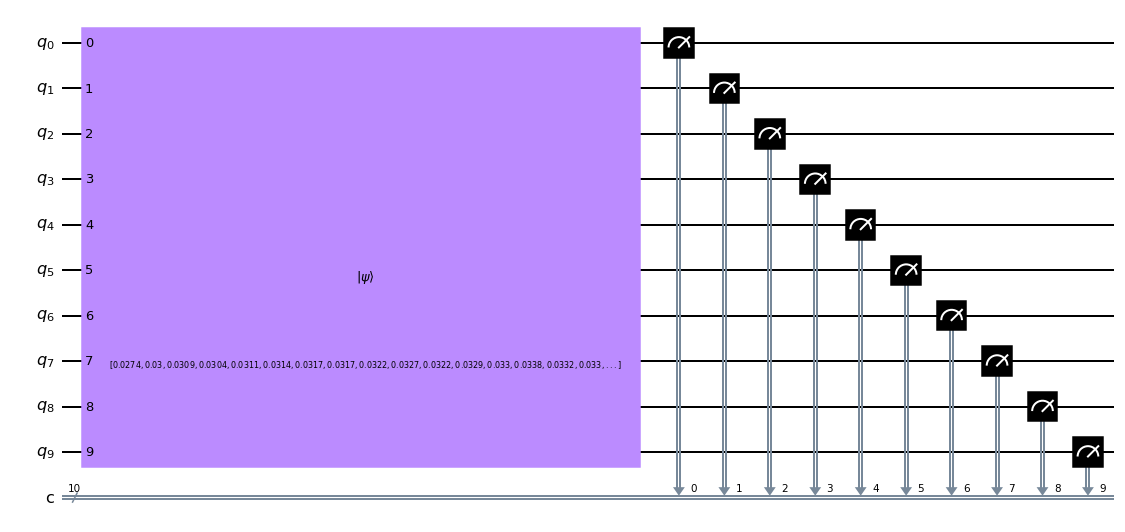

In [45]:
# Our Quantum Circuit that initializes the FRQI image
qc_image_32 = QuantumCircuit(10,10)
qc_image_32.initialize(np_test_image_32x32_normalized.reshape(32**2))
qc_image_32.measure(range(10), range(10))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
#qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])

qc_image_32.draw()

Image recontructed from  500 Shots:


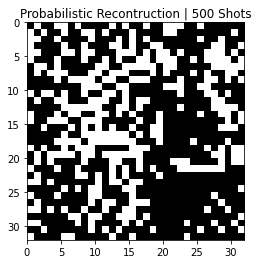

RMSE:  0.044475736842171154  | MSE:  0.5063913389194394  | SSIM:  0.1472028707673966
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  1000 Shots:


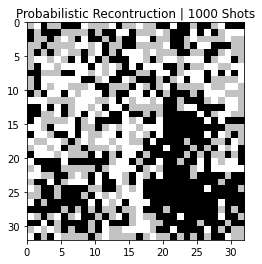

RMSE:  0.03344911830688524  | MSE:  0.28642393997004933  | SSIM:  0.22109597174564127
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  1500 Shots:


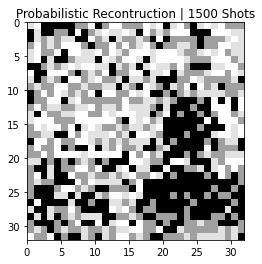

RMSE:  0.02474413975279488  | MSE:  0.15674174773909605  | SSIM:  0.27841369592424653
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  2000 Shots:


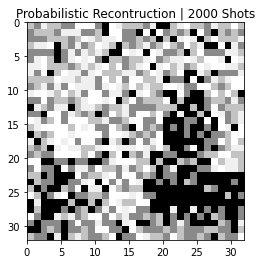

RMSE:  0.01984563869484303  | MSE:  0.10082544005280022  | SSIM:  0.32462000103010435
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  2500 Shots:


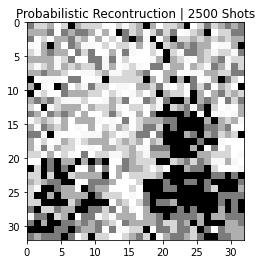

RMSE:  0.016863830781121233  | MSE:  0.07280352988525875  | SSIM:  0.395308227868191
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  3000 Shots:


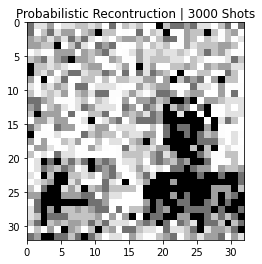

RMSE:  0.016515120151882272  | MSE:  0.06982379356956361  | SSIM:  0.4081743679923336
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  3500 Shots:


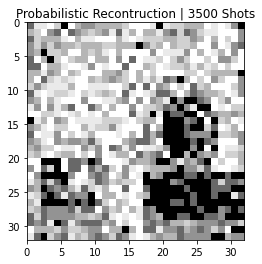

RMSE:  0.01395618075800604  | MSE:  0.04986239522563534  | SSIM:  0.44691083321714703
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  4000 Shots:


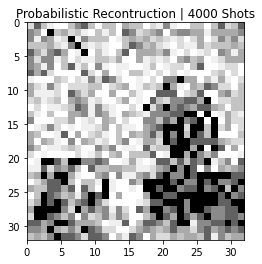

RMSE:  0.013885662395579777  | MSE:  0.04935977476198869  | SSIM:  0.45690376913163144
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  4500 Shots:


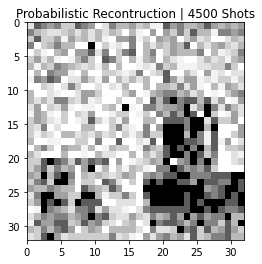

RMSE:  0.013294864588800375  | MSE:  0.04524887665524177  | SSIM:  0.4670378585947531
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  5000 Shots:


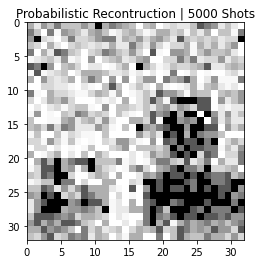

RMSE:  0.012814738618240808  | MSE:  0.042039686618581075  | SSIM:  0.4840774140934935
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  5500 Shots:


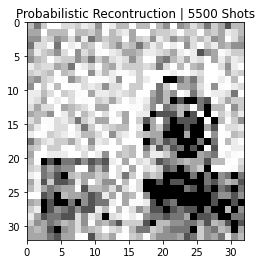

RMSE:  0.010073711047773616  | MSE:  0.025978791494153268  | SSIM:  0.5043069763218319
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  6000 Shots:


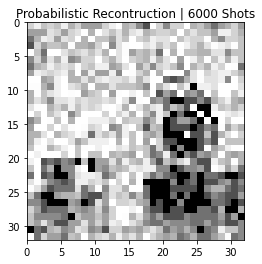

RMSE:  0.00990507210233398  | MSE:  0.025116276058223332  | SSIM:  0.5236810678692438
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  6500 Shots:


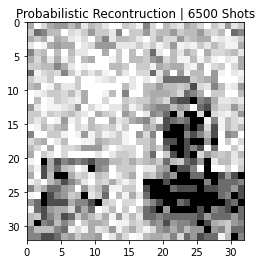

RMSE:  0.009394471593151281  | MSE:  0.02259356070771875  | SSIM:  0.5360762614376532
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  7000 Shots:


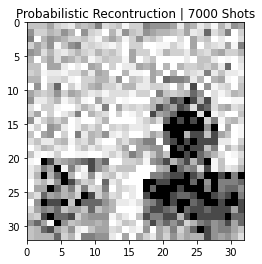

RMSE:  0.009094460006533358  | MSE:  0.021173555919471284  | SSIM:  0.533859641730179
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  7500 Shots:


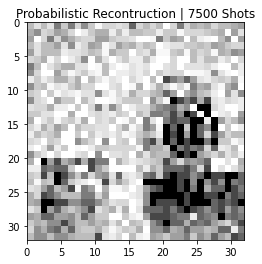

RMSE:  0.008216037607691441  | MSE:  0.017280838136576025  | SSIM:  0.5746469173785822
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  8000 Shots:


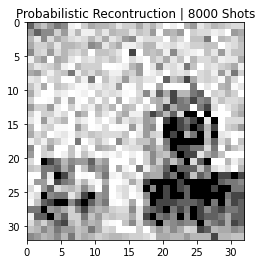

RMSE:  0.008897062966302011  | MSE:  0.02026437873314374  | SSIM:  0.5450064726301502
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  8500 Shots:


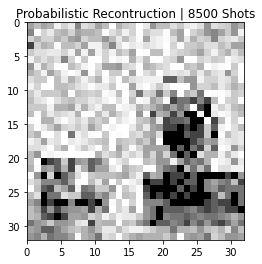

RMSE:  0.008182332391120884  | MSE:  0.01713934421984922  | SSIM:  0.5683999461080179
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  9000 Shots:


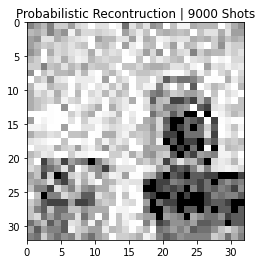

RMSE:  0.008167321438708101  | MSE:  0.017076515707694327  | SSIM:  0.5824523592352375
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  9500 Shots:


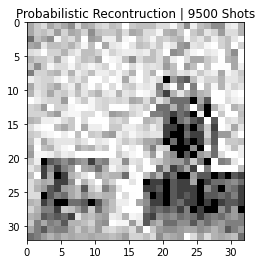

RMSE:  0.0076303696239831235  | MSE:  0.014904970393242714  | SSIM:  0.5807380253401372
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  10000 Shots:


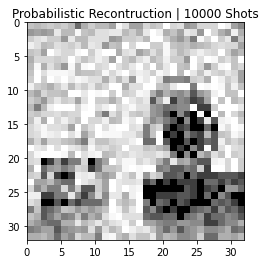

RMSE:  0.007434818429606194  | MSE:  0.01415079042079025  | SSIM:  0.599048443449005
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  10500 Shots:


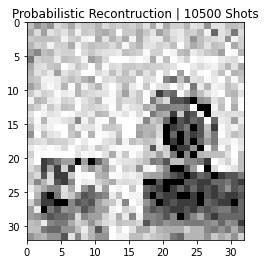

RMSE:  0.0064425006456012195  | MSE:  0.010625488529554465  | SSIM:  0.6213253025501383
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  11000 Shots:


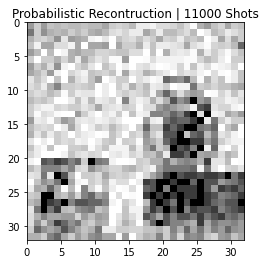

RMSE:  0.007485643657405124  | MSE:  0.014344924407206288  | SSIM:  0.6244889671966469
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  11500 Shots:


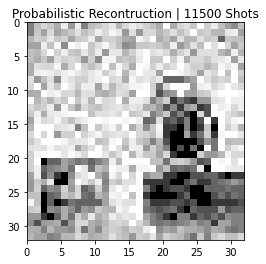

RMSE:  0.007605451229944604  | MSE:  0.014807779433232868  | SSIM:  0.6247895253229535
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  12000 Shots:


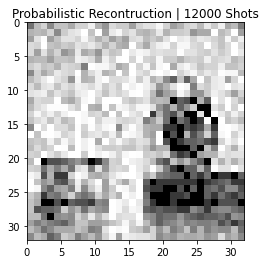

RMSE:  0.007145743578244512  | MSE:  0.013071782729221807  | SSIM:  0.6287265791016903
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  12500 Shots:


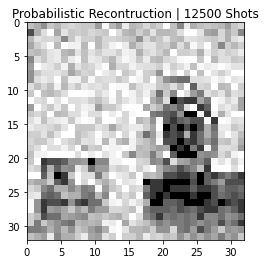

RMSE:  0.006560216307865274  | MSE:  0.01101732812953126  | SSIM:  0.6419847767094518
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  13000 Shots:


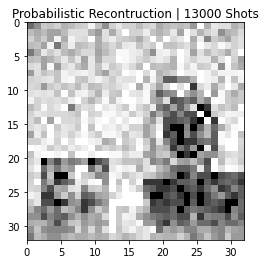

RMSE:  0.006579706584530945  | MSE:  0.011082889917061087  | SSIM:  0.6343317655732379
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  13500 Shots:


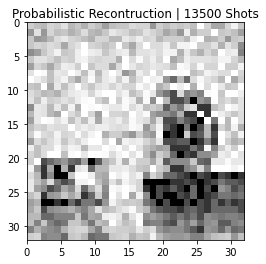

RMSE:  0.006232037446909961  | MSE:  0.009942602429360133  | SSIM:  0.6454949378273741
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  14000 Shots:


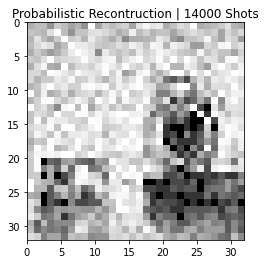

RMSE:  0.00669924462012379  | MSE:  0.01148924889094593  | SSIM:  0.6465183958923949
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  14500 Shots:


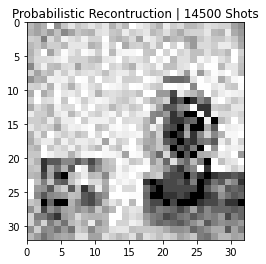

RMSE:  0.006395300766949463  | MSE:  0.010470367206334562  | SSIM:  0.6477153440773373
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  15000 Shots:


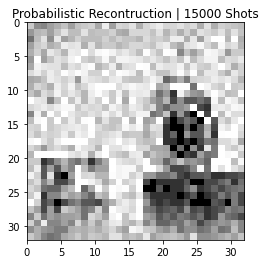

RMSE:  0.00636610077551449  | MSE:  0.010374973205505586  | SSIM:  0.6602383011360949
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  15500 Shots:


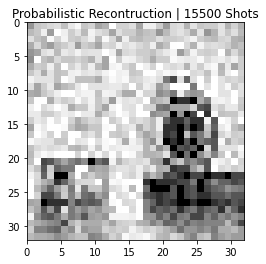

RMSE:  0.006746316416021876  | MSE:  0.01165127300738208  | SSIM:  0.6555585944172746
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  16000 Shots:


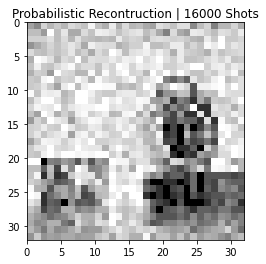

RMSE:  0.006065040467915027  | MSE:  0.009416887264626413  | SSIM:  0.6699808274545951
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  16500 Shots:


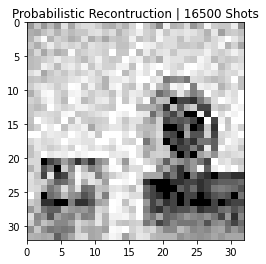

RMSE:  0.005357569025232962  | MSE:  0.007348107740194732  | SSIM:  0.6811782301467695
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  17000 Shots:


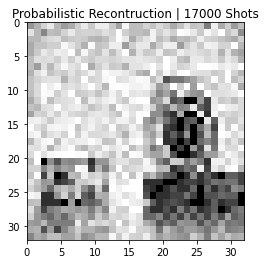

RMSE:  0.0053519434083035364  | MSE:  0.00733268435089502  | SSIM:  0.6761059787240314
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  17500 Shots:


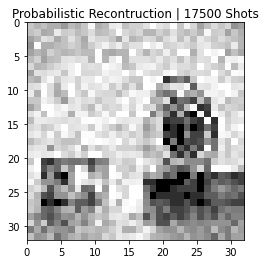

RMSE:  0.005932164977593118  | MSE:  0.009008788818273883  | SSIM:  0.6773001646837549
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  18000 Shots:


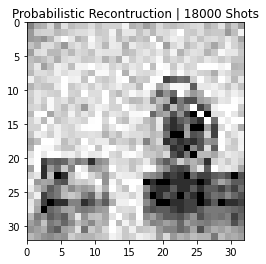

RMSE:  0.005742042857714322  | MSE:  0.008440590382035982  | SSIM:  0.6653816003867903
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  18500 Shots:


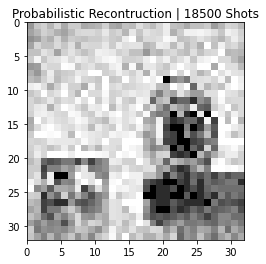

RMSE:  0.005180345777038971  | MSE:  0.006870011486639487  | SSIM:  0.6857864552824134
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  19000 Shots:


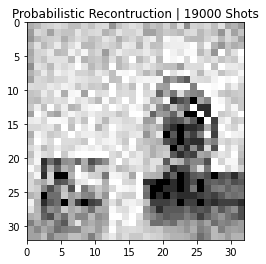

RMSE:  0.005598055410107862  | MSE:  0.008022585439907304  | SSIM:  0.671560543742891
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  19500 Shots:


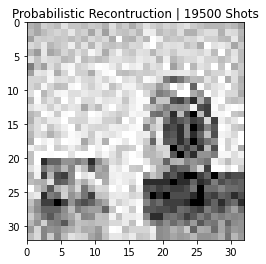

RMSE:  0.005378898092900119  | MSE:  0.007406731441613962  | SSIM:  0.6847486717859607
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  20000 Shots:


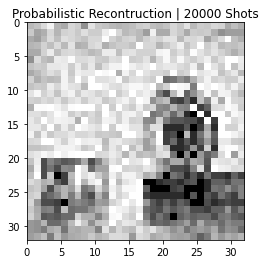

RMSE:  0.005196347939117153  | MSE:  0.006912520167517974  | SSIM:  0.6879847476798927
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  20500 Shots:


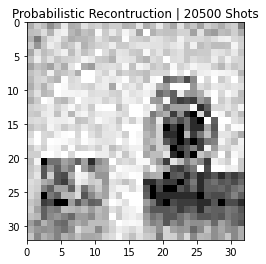

RMSE:  0.005656051405894228  | MSE:  0.008189674881566227  | SSIM:  0.6910701903616993
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  21000 Shots:


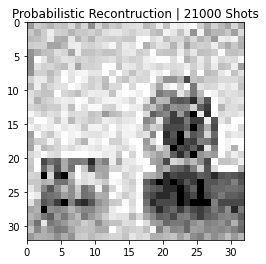

RMSE:  0.005216962873676193  | MSE:  0.0069674756160808355  | SSIM:  0.6959703765030429
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  21500 Shots:


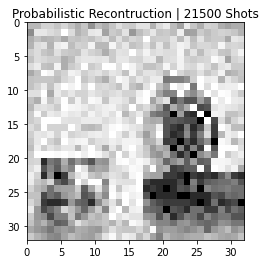

RMSE:  0.005374395501686797  | MSE:  0.0073943365141891275  | SSIM:  0.6949128555330565
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  22000 Shots:


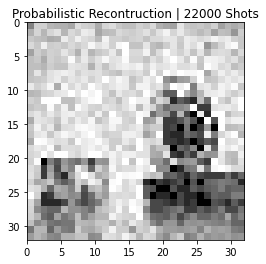

RMSE:  0.004708280631724227  | MSE:  0.005674984065809788  | SSIM:  0.7055706884453973
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  22500 Shots:


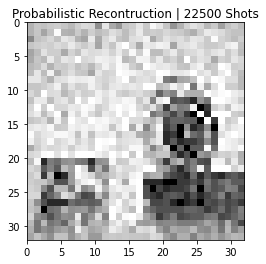

RMSE:  0.0051506673560767005  | MSE:  0.006791519798516263  | SSIM:  0.6990711879821734
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  23000 Shots:


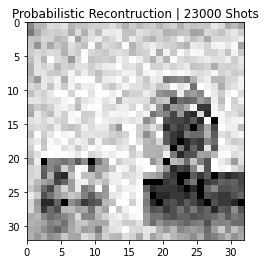

RMSE:  0.0054587709991688336  | MSE:  0.0076283342902698755  | SSIM:  0.6938392358944995
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  23500 Shots:


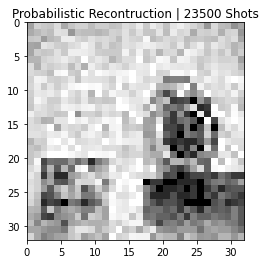

RMSE:  0.005092902510112552  | MSE:  0.006640039930242748  | SSIM:  0.7085280904177053
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  24000 Shots:


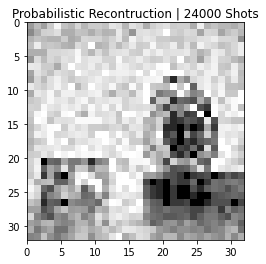

RMSE:  0.004941050611657242  | MSE:  0.006249979173621352  | SSIM:  0.7100397181127346
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  24500 Shots:


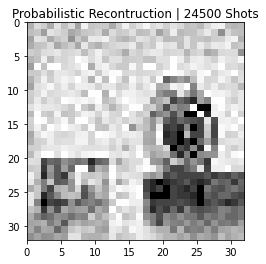

RMSE:  0.0053925323633282505  | MSE:  0.0074443277541228975  | SSIM:  0.7116750632441049
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  25000 Shots:


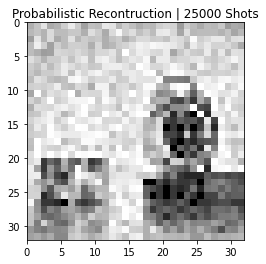

RMSE:  0.005016513997693821  | MSE:  0.006442345648398859  | SSIM:  0.7172682261760468
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  25500 Shots:


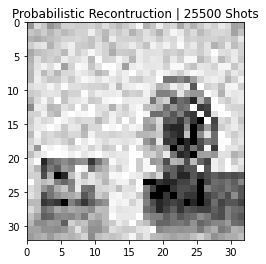

RMSE:  0.004985813879411306  | MSE:  0.006363735050273388  | SSIM:  0.7121068895396797
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  26000 Shots:


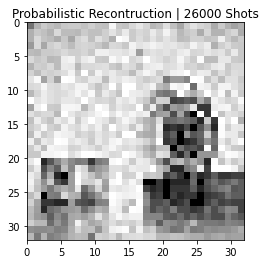

RMSE:  0.0047626815026756975  | MSE:  0.005806882584557886  | SSIM:  0.7186140690793391
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  26500 Shots:


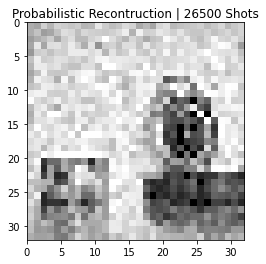

RMSE:  0.005042795654001078  | MSE:  0.0065100257300511125  | SSIM:  0.7182947046549196
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  27000 Shots:


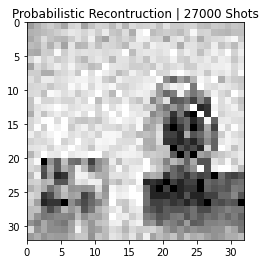

RMSE:  0.004647057330801123  | MSE:  0.00552835630995263  | SSIM:  0.7283276049770151
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  27500 Shots:


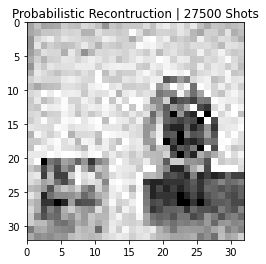

RMSE:  0.004682134430121748  | MSE:  0.005612130002363266  | SSIM:  0.7267951893291124
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  28000 Shots:


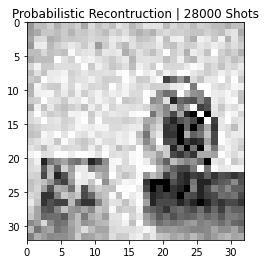

RMSE:  0.004303977031413703  | MSE:  0.004742199881455797  | SSIM:  0.7298342787558619
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  28500 Shots:


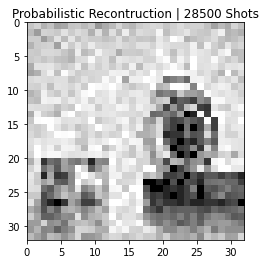

RMSE:  0.004597308754550067  | MSE:  0.005410623432873647  | SSIM:  0.7286354918009302
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  29000 Shots:


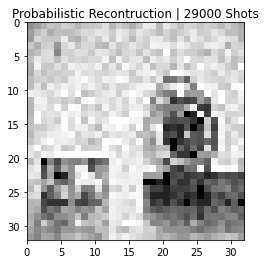

RMSE:  0.004412673233002756  | MSE:  0.004984751375682302  | SSIM:  0.7356555709199469
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  29500 Shots:


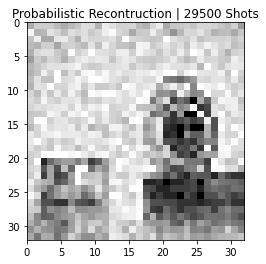

RMSE:  0.004787211753409195  | MSE:  0.00586685347122666  | SSIM:  0.7249942805169463
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  30000 Shots:


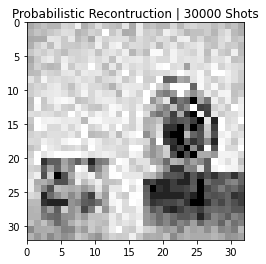

RMSE:  0.004457100160132496  | MSE:  0.005085629910387999  | SSIM:  0.7238023571302835
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  30500 Shots:


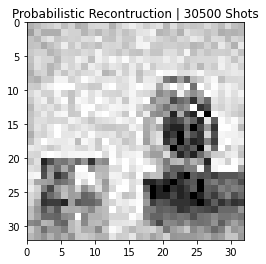

RMSE:  0.0042435682368791045  | MSE:  0.004610015073548602  | SSIM:  0.7340045227651785
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  31000 Shots:


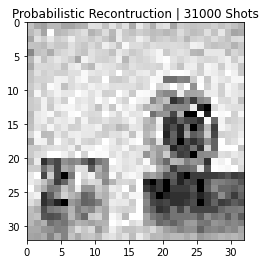

RMSE:  0.004260649202065168  | MSE:  0.0046472016955029895  | SSIM:  0.7428300685439765
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  31500 Shots:


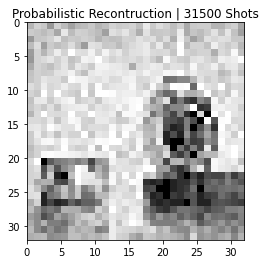

RMSE:  0.004260940378174534  | MSE:  0.004647836904027683  | SSIM:  0.7378466099296522
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  32000 Shots:


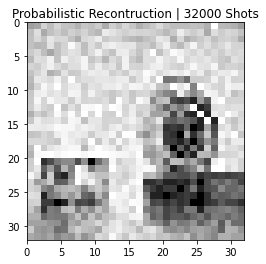

RMSE:  0.004235588536544182  | MSE:  0.004592693824231548  | SSIM:  0.7400217744682493
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  32500 Shots:


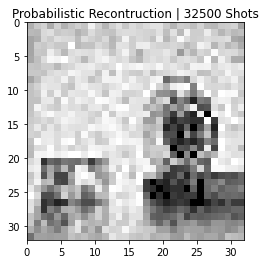

RMSE:  0.0038862209114388746  | MSE:  0.0038662945209612283  | SSIM:  0.7430060786844354
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  33000 Shots:


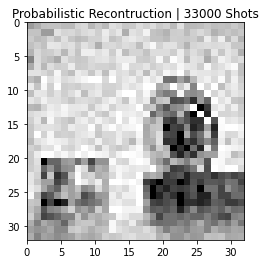

RMSE:  0.0042908074515812435  | MSE:  0.004713223318155552  | SSIM:  0.7399119856536354
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  33500 Shots:


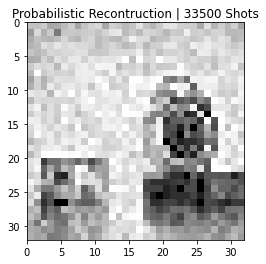

RMSE:  0.004221663553737214  | MSE:  0.004562545449203998  | SSIM:  0.7514836998615055
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  34000 Shots:


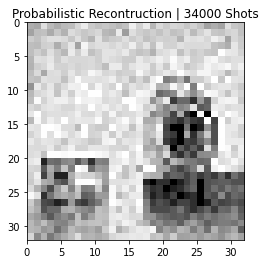

RMSE:  0.004256330054881123  | MSE:  0.004637784457237592  | SSIM:  0.7485301947424193
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  34500 Shots:


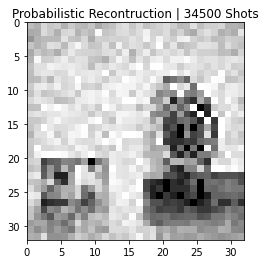

RMSE:  0.004121662909018464  | MSE:  0.0043489549147081065  | SSIM:  0.740184609461328
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  35000 Shots:


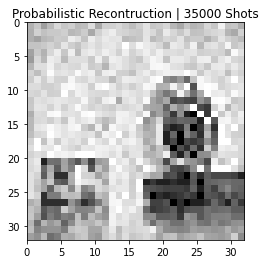

RMSE:  0.004136220461577057  | MSE:  0.004379729844932794  | SSIM:  0.7488880267075602
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  35500 Shots:


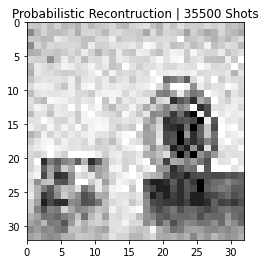

RMSE:  0.004080242205069451  | MSE:  0.004261984371719685  | SSIM:  0.7538278103812452
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  36000 Shots:


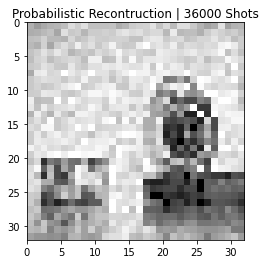

RMSE:  0.004217590506105476  | MSE:  0.004553745837360909  | SSIM:  0.746449120831393
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  36500 Shots:


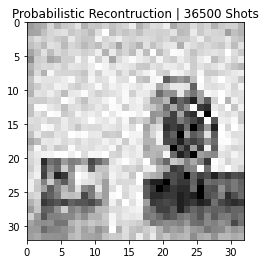

RMSE:  0.004281482945997585  | MSE:  0.004692760631518248  | SSIM:  0.74297496645132
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  37000 Shots:


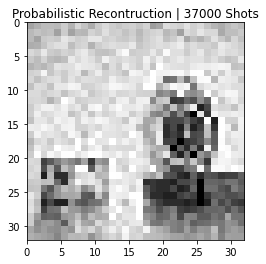

RMSE:  0.003696309129697215  | MSE:  0.003497651502664443  | SSIM:  0.7597282017096507
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  37500 Shots:


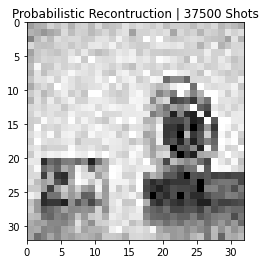

RMSE:  0.003924756434924881  | MSE:  0.003943350546811972  | SSIM:  0.7601041076291017
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  38000 Shots:


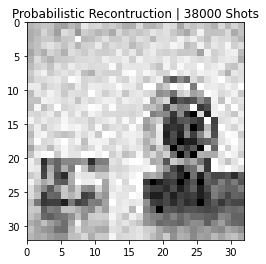

RMSE:  0.003934934101509364  | MSE:  0.003963828834104653  | SSIM:  0.754956425778916
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  38500 Shots:


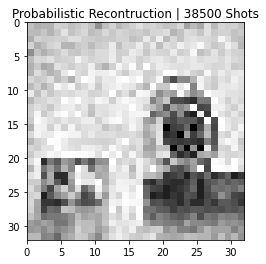

RMSE:  0.004034675828754823  | MSE:  0.004167323915043436  | SSIM:  0.7619911819230466
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  39000 Shots:


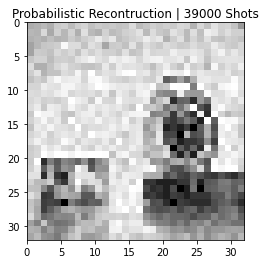

RMSE:  0.003817328074599324  | MSE:  0.0037304303690557906  | SSIM:  0.7674844523807891
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  39500 Shots:


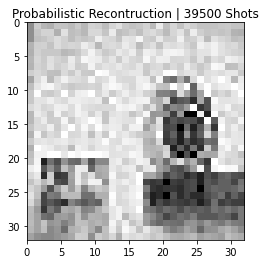

RMSE:  0.003734825030859939  | MSE:  0.003570923010851314  | SSIM:  0.7585572475617637
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  40000 Shots:


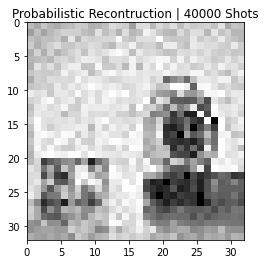

RMSE:  0.0038041861908733013  | MSE:  0.003704789139156766  | SSIM:  0.760494812018813
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  40500 Shots:


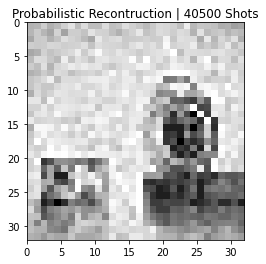

RMSE:  0.003554169542348733  | MSE:  0.0032338230107544067  | SSIM:  0.7738135749623534
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  41000 Shots:


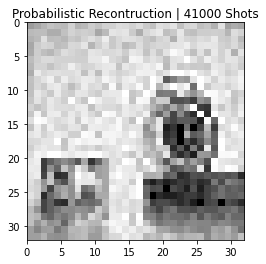

RMSE:  0.003561544047876484  | MSE:  0.0032472565772708887  | SSIM:  0.7665133658825233
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  41500 Shots:


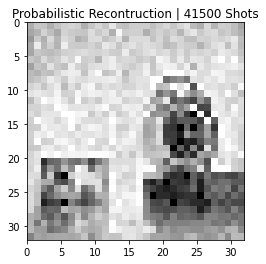

RMSE:  0.004046158088056083  | MSE:  0.004191077190026663  | SSIM:  0.773461938529412
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  42000 Shots:


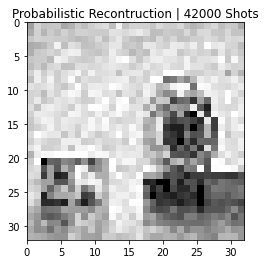

RMSE:  0.00371545398976291  | MSE:  0.0035339771776115524  | SSIM:  0.7617291675179584
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  42500 Shots:


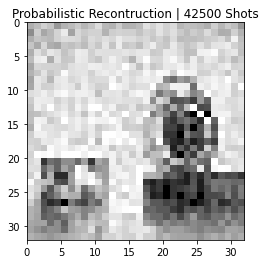

RMSE:  0.0038747817937228707  | MSE:  0.0038435670909353543  | SSIM:  0.7701800767602117
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  43000 Shots:


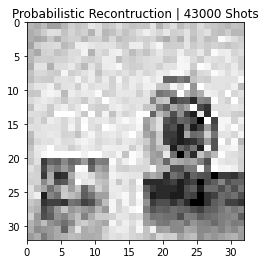

RMSE:  0.0037631103367290293  | MSE:  0.003625215848037598  | SSIM:  0.7674964225222375
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  43500 Shots:


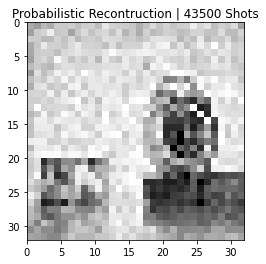

RMSE:  0.0036056046253037256  | MSE:  0.0033280984867869747  | SSIM:  0.7746550583786513
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  44000 Shots:


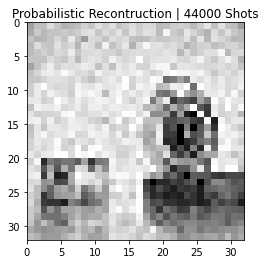

RMSE:  0.003666154732732218  | MSE:  0.0034408167742297187  | SSIM:  0.7744968655317741
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  44500 Shots:


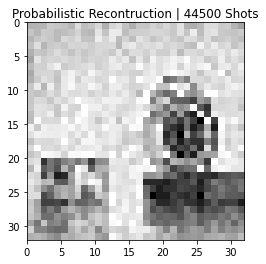

RMSE:  0.0034187903288363463  | MSE:  0.0029921605920115025  | SSIM:  0.7823520204811436
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  45000 Shots:


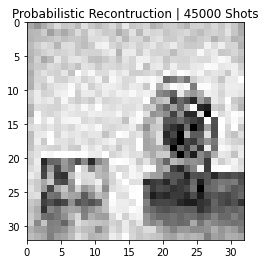

RMSE:  0.0035314836667992592  | MSE:  0.003192672483550705  | SSIM:  0.7828059461704759
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  45500 Shots:


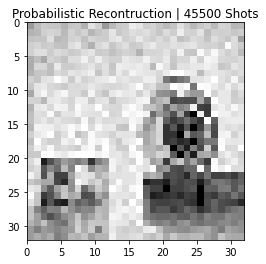

RMSE:  0.0036137439009259575  | MSE:  0.0033431411152587665  | SSIM:  0.7770938340784505
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  46000 Shots:


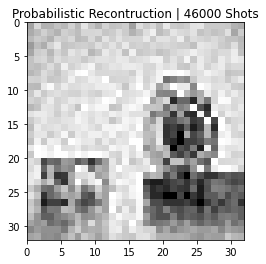

RMSE:  0.0034250748262770695  | MSE:  0.003003171216792806  | SSIM:  0.7874244367532521
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  46500 Shots:


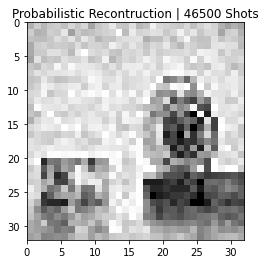

RMSE:  0.0037530235805614486  | MSE:  0.0036058076150400705  | SSIM:  0.7707460386231177
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  47000 Shots:


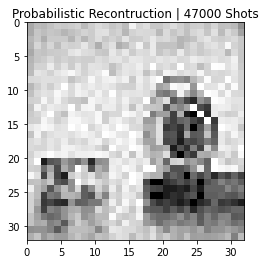

RMSE:  0.0035779159596722597  | MSE:  0.0032771795493062314  | SSIM:  0.7656137862048488
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  47500 Shots:


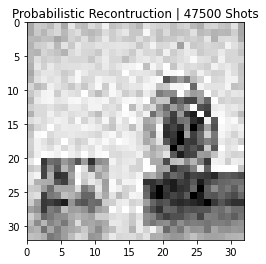

RMSE:  0.003671923439376485  | MSE:  0.0034516535666284636  | SSIM:  0.7750624117197364
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  48000 Shots:


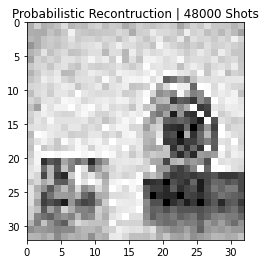

RMSE:  0.0035498971140249984  | MSE:  0.003226052997161731  | SSIM:  0.781638615786744
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  48500 Shots:


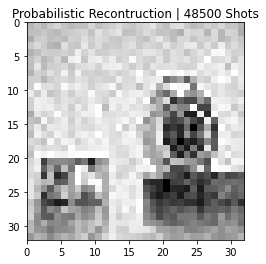

RMSE:  0.003388297920597882  | MSE:  0.00293902407647435  | SSIM:  0.7862092862763101
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  49000 Shots:


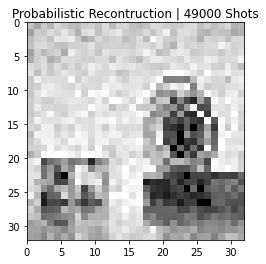

RMSE:  0.00339809632710042  | MSE:  0.002956047013952861  | SSIM:  0.7808229895708602
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  49500 Shots:


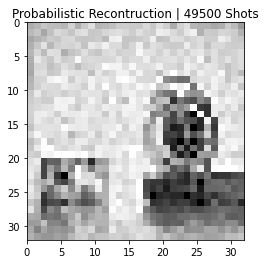

RMSE:  0.0032980795001822144  | MSE:  0.0027845960677176746  | SSIM:  0.7827278729725711
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  50000 Shots:


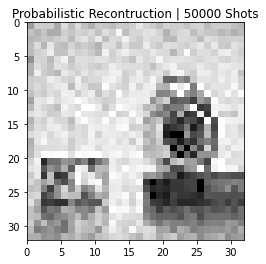

RMSE:  0.003804060273914778  | MSE:  0.0037045438892996034  | SSIM:  0.782393654967301
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  50500 Shots:


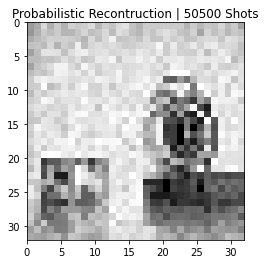

RMSE:  0.003288605664524203  | MSE:  0.002768621367485613  | SSIM:  0.7955031857507505
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  51000 Shots:


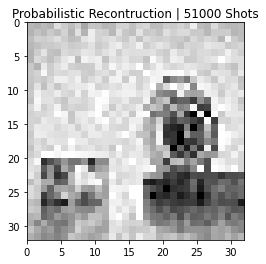

RMSE:  0.0034553682506607876  | MSE:  0.003056529855404695  | SSIM:  0.7820172124360827
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  51500 Shots:


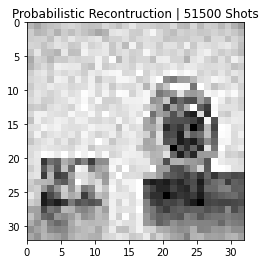

RMSE:  0.003579792287784111  | MSE:  0.0032806176828617207  | SSIM:  0.7811440027915317
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  52000 Shots:


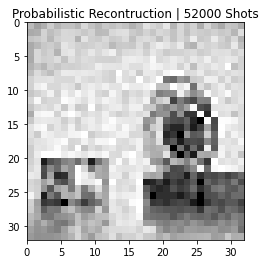

RMSE:  0.0032060410124217344  | MSE:  0.0026313469371725263  | SSIM:  0.8002819715122964
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  52500 Shots:


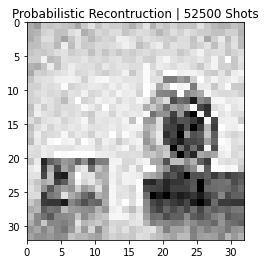

RMSE:  0.003241988608527896  | MSE:  0.0026906854752831084  | SSIM:  0.8039340456041059
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  53000 Shots:


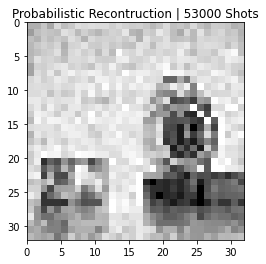

RMSE:  0.003369767656842181  | MSE:  0.0029069655196415083  | SSIM:  0.7970558486366848
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  53500 Shots:


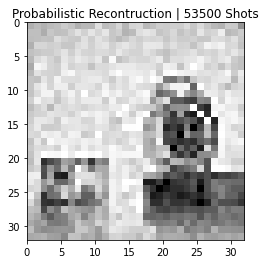

RMSE:  0.003244900545349046  | MSE:  0.0026955211645968732  | SSIM:  0.8000381752494677
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  54000 Shots:


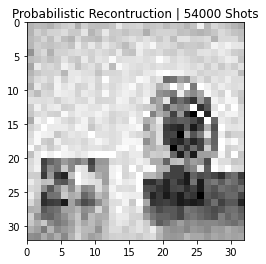

RMSE:  0.003266208123346714  | MSE:  0.002731037569284112  | SSIM:  0.7937508879941694
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  54500 Shots:


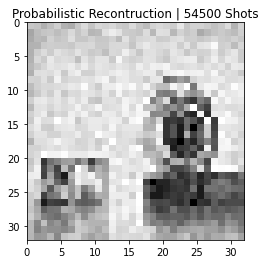

RMSE:  0.002906460950734235  | MSE:  0.0021625639060845955  | SSIM:  0.8120785801497199
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  55000 Shots:


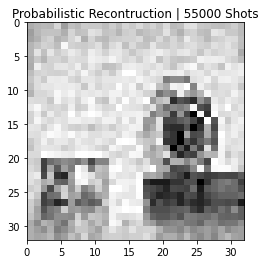

RMSE:  0.0035895301945510507  | MSE:  0.003298490116503988  | SSIM:  0.7810716707205362
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  55500 Shots:


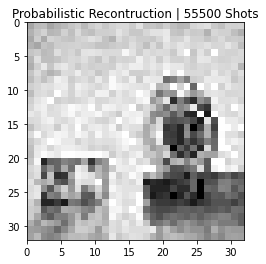

RMSE:  0.003189441561444031  | MSE:  0.0026041695933098335  | SSIM:  0.7999660224946596
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  56000 Shots:


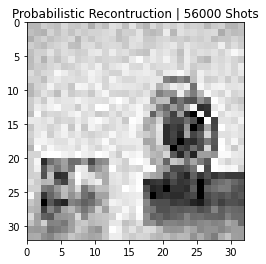

RMSE:  0.0032728412340964704  | MSE:  0.0027421413743621394  | SSIM:  0.7929085253525404
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  56500 Shots:


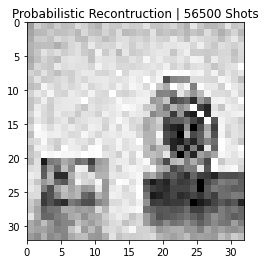

RMSE:  0.0029876023395999265  | MSE:  0.0022849965413332366  | SSIM:  0.8059698321518061
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  57000 Shots:


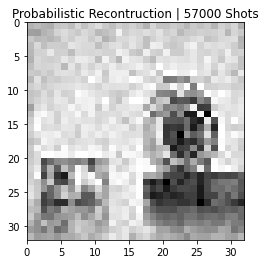

RMSE:  0.0033324369734546977  | MSE:  0.002842914862604264  | SSIM:  0.7973611869021275
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  57500 Shots:


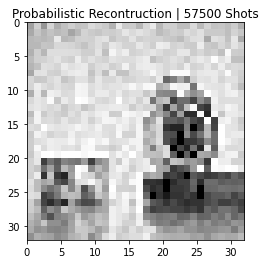

RMSE:  0.003373060329360777  | MSE:  0.002912649212289903  | SSIM:  0.7894955460750956
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  58000 Shots:


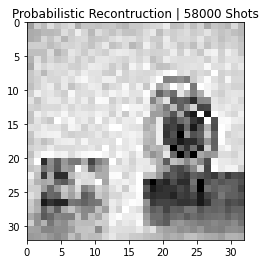

RMSE:  0.00327357320804668  | MSE:  0.0027433680764009038  | SSIM:  0.7899853496001985
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  58500 Shots:


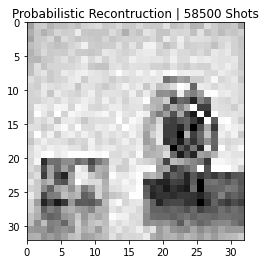

RMSE:  0.0029397695519165655  | MSE:  0.0022124147247041853  | SSIM:  0.8095966110229118
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  59000 Shots:


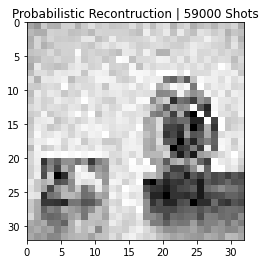

RMSE:  0.0034092955600828843  | MSE:  0.002975563831296222  | SSIM:  0.7856395589350555
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  59500 Shots:


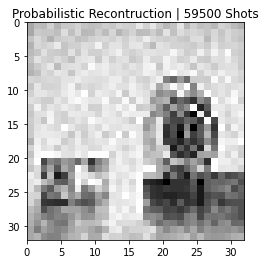

RMSE:  0.0028834629702876704  | MSE:  0.00212847582746117  | SSIM:  0.8012163712050911
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  60000 Shots:


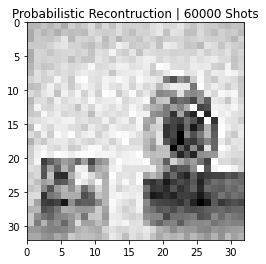

RMSE:  0.003164681699732173  | MSE:  0.0025638938267186473  | SSIM:  0.7991334007205071
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  60500 Shots:


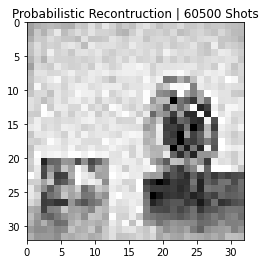

RMSE:  0.0032504655301849946  | MSE:  0.0027047746977077293  | SSIM:  0.8080083261517562
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  61000 Shots:


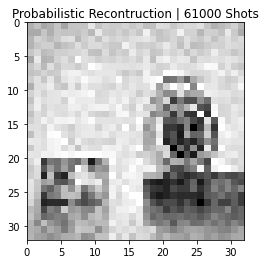

RMSE:  0.0031070531235163866  | MSE:  0.0024713674527623514  | SSIM:  0.8002782314291526
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  61500 Shots:


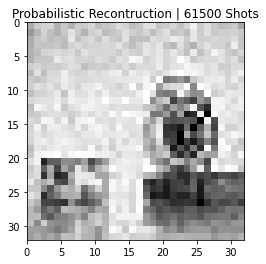

RMSE:  0.0029392515488498965  | MSE:  0.002211635114858628  | SSIM:  0.8163804148477752
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  62000 Shots:


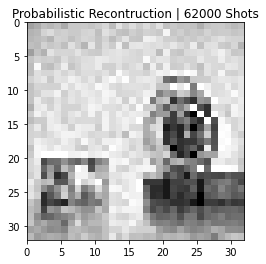

RMSE:  0.0029570266656747672  | MSE:  0.0022384657155869775  | SSIM:  0.8080152353695909
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  62500 Shots:


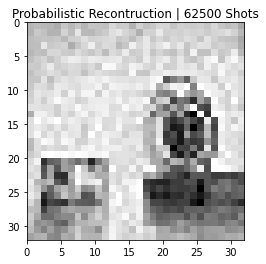

RMSE:  0.0031402831445111884  | MSE:  0.002524512826291476  | SSIM:  0.8020343802161735
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  63000 Shots:


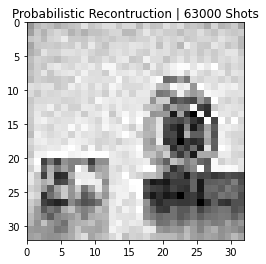

RMSE:  0.002888160847550537  | MSE:  0.0021354171088189024  | SSIM:  0.8194025108019558
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  63500 Shots:


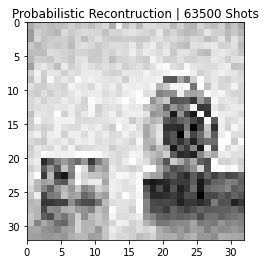

RMSE:  0.002985774426104566  | MSE:  0.002282201324436493  | SSIM:  0.8162396646198293
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  64000 Shots:


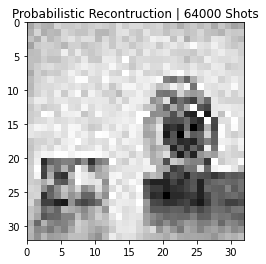

RMSE:  0.003189535073790044  | MSE:  0.0026043223006558362  | SSIM:  0.8087106720281406
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  64500 Shots:


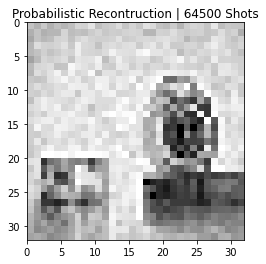

RMSE:  0.003029196442521991  | MSE:  0.0023490639583712983  | SSIM:  0.8036659292909618
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  65000 Shots:


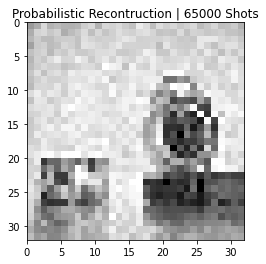

RMSE:  0.002891613499217095  | MSE:  0.0021405257289867606  | SSIM:  0.8132128031729138
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  65500 Shots:


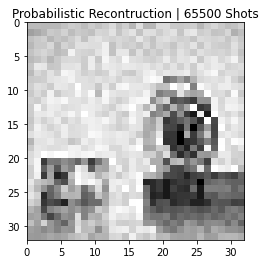

RMSE:  0.0031000102556862385  | MSE:  0.0024601762778521234  | SSIM:  0.8042061575952498
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  66000 Shots:


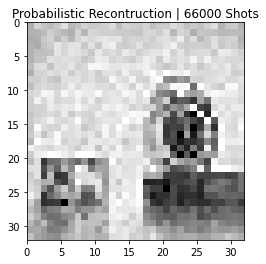

RMSE:  0.003028050617728661  | MSE:  0.002347287179142893  | SSIM:  0.8077626842339064
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  66500 Shots:


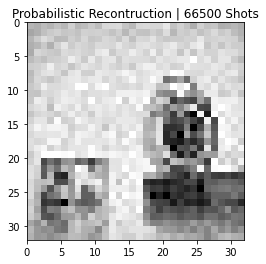

RMSE:  0.0029420135576511603  | MSE:  0.0022157936059912287  | SSIM:  0.8103029411007907
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  67000 Shots:


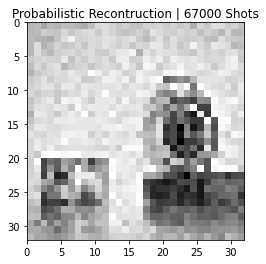

RMSE:  0.0028549038205522956  | MSE:  0.002086521811098648  | SSIM:  0.8179080219300328
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  67500 Shots:


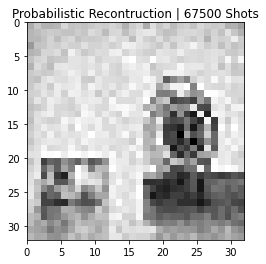

RMSE:  0.002859957471678082  | MSE:  0.002093915325390665  | SSIM:  0.8146859456432846
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  68000 Shots:


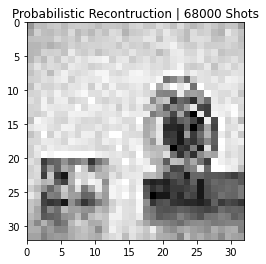

RMSE:  0.002710651898304456  | MSE:  0.0018809942307280773  | SSIM:  0.8281690859863104
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  68500 Shots:


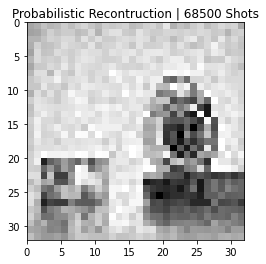

RMSE:  0.0026228694674583167  | MSE:  0.001761137726291219  | SSIM:  0.8234457091192008
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  69000 Shots:


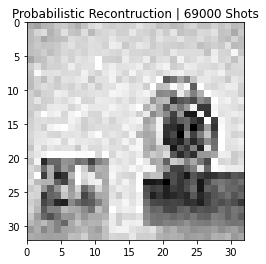

RMSE:  0.0029950129004156574  | MSE:  0.0022963461820559895  | SSIM:  0.818850985534199
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  69500 Shots:


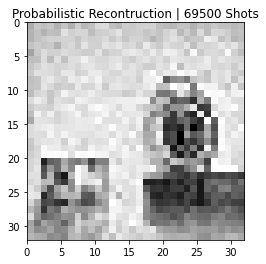

RMSE:  0.0026116869933983933  | MSE:  0.0017461526915805029  | SSIM:  0.8307818129449054
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  70000 Shots:


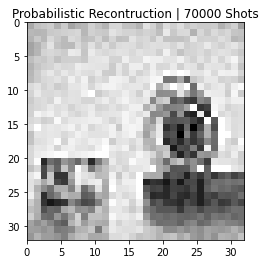

RMSE:  0.0028132921250012886  | MSE:  0.002026140820632132  | SSIM:  0.8241849935599598
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  70500 Shots:


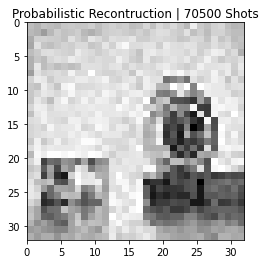

RMSE:  0.002883130436104816  | MSE:  0.0021279849245680505  | SSIM:  0.8226933616780778
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  71000 Shots:


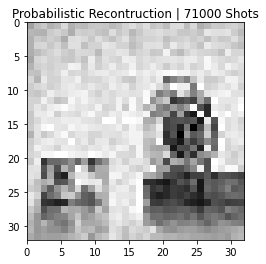

RMSE:  0.003016538322829551  | MSE:  0.0023294728839934257  | SSIM:  0.8191887367226377
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  71500 Shots:


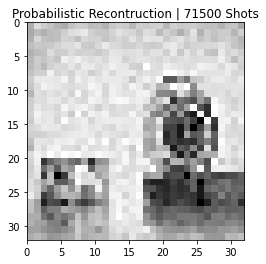

RMSE:  0.002661534562330302  | MSE:  0.0018134441539785604  | SSIM:  0.8288502483316783
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  72000 Shots:


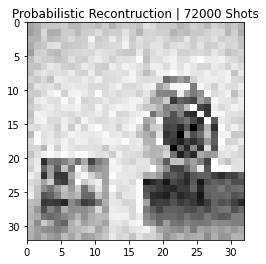

RMSE:  0.0028751377800940283  | MSE:  0.002116202817158148  | SSIM:  0.8144947416651604
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  72500 Shots:


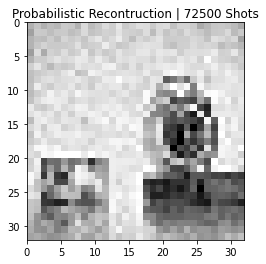

RMSE:  0.0028269263036424085  | MSE:  0.0020458271555136845  | SSIM:  0.8288923000513096
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  73000 Shots:


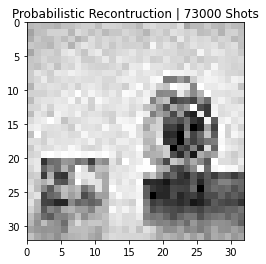

RMSE:  0.0027715798155202227  | MSE:  0.0019665035964925724  | SSIM:  0.8298306247931868
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  73500 Shots:


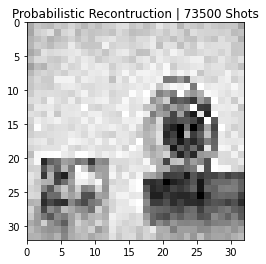

RMSE:  0.0027878569328484417  | MSE:  0.0019896694471759667  | SSIM:  0.8259303855774722
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  74000 Shots:


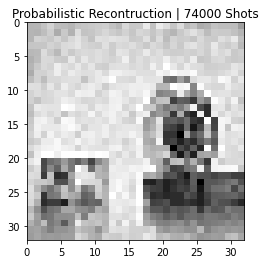

RMSE:  0.0026992303488025345  | MSE:  0.001865176185829543  | SSIM:  0.834532956774792
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  74500 Shots:


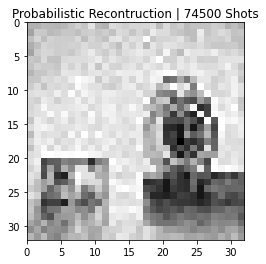

RMSE:  0.0025821741412525023  | MSE:  0.0017069115637127928  | SSIM:  0.8289981979040477
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  75000 Shots:


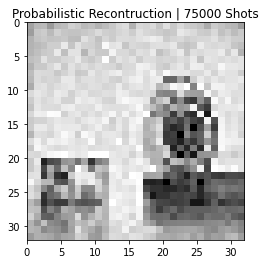

RMSE:  0.0027904929842810337  | MSE:  0.001993433880402347  | SSIM:  0.8245287513446553
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  75500 Shots:


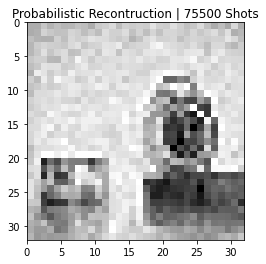

RMSE:  0.0027533890442586998  | MSE:  0.001940774714635222  | SSIM:  0.8321133808384011
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  76000 Shots:


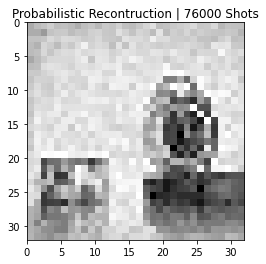

RMSE:  0.002588962088977136  | MSE:  0.0017158975227291795  | SSIM:  0.8459555075387885
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  76500 Shots:


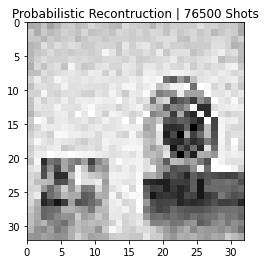

RMSE:  0.002682797321520317  | MSE:  0.0018425347758992865  | SSIM:  0.836601524579588
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  77000 Shots:


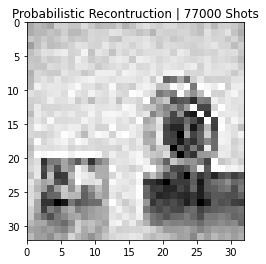

RMSE:  0.002912887668312879  | MSE:  0.0021721381294615653  | SSIM:  0.8189710412702056
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  77500 Shots:


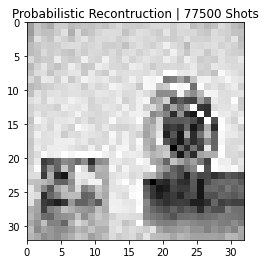

RMSE:  0.0026742965440486573  | MSE:  0.0018308766734107117  | SSIM:  0.8346625979885803
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  78000 Shots:


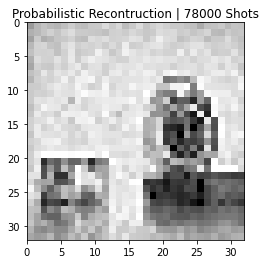

RMSE:  0.002775969086858908  | MSE:  0.0019727371190262476  | SSIM:  0.8298784295879239
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  78500 Shots:


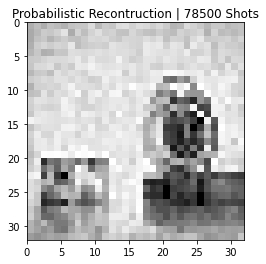

RMSE:  0.002648461240185877  | MSE:  0.0017956728168363294  | SSIM:  0.8388457710327099
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  79000 Shots:


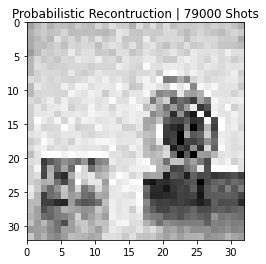

RMSE:  0.0027367375015423527  | MSE:  0.0019173714310011592  | SSIM:  0.8341375701997884
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  79500 Shots:


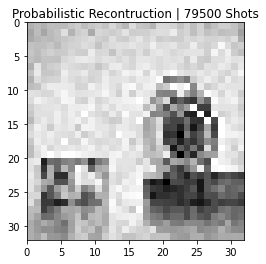

RMSE:  0.002727890962356692  | MSE:  0.0019049956102418738  | SSIM:  0.833146809567958
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  80000 Shots:


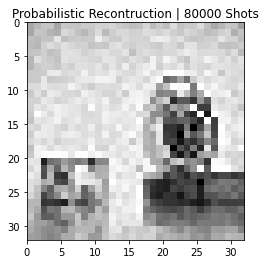

RMSE:  0.002526818754872923  | MSE:  0.0016345121331142528  | SSIM:  0.8423552895071522
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  80500 Shots:


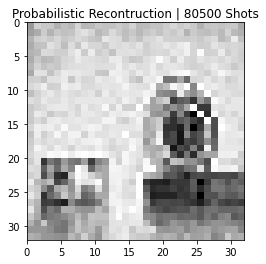

RMSE:  0.0026465441959177666  | MSE:  0.0017930742223221806  | SSIM:  0.83951048594149
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  81000 Shots:


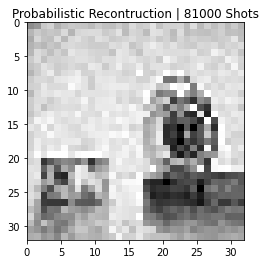

RMSE:  0.00259208485212452  | MSE:  0.0017200393934370289  | SSIM:  0.8404570480724636
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  81500 Shots:


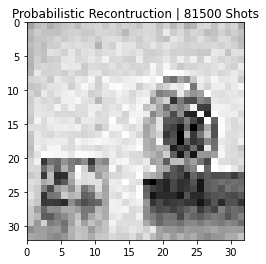

RMSE:  0.0026283926922524106  | MSE:  0.001768562725039584  | SSIM:  0.8245397845747371
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  82000 Shots:


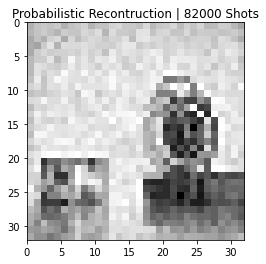

RMSE:  0.002962540703970142  | MSE:  0.002246821740206056  | SSIM:  0.8268643071480367
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  82500 Shots:


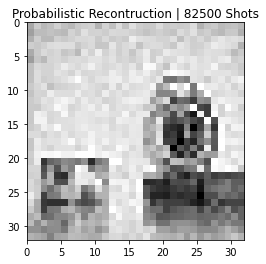

RMSE:  0.0024950106359372505  | MSE:  0.001593619986800641  | SSIM:  0.8453223339664492
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  83000 Shots:


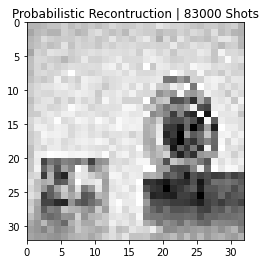

RMSE:  0.0025042006853869567  | MSE:  0.0016053813946092811  | SSIM:  0.8326384068537509
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  83500 Shots:


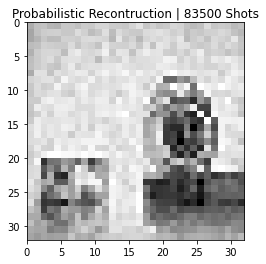

RMSE:  0.0025320976720155457  | MSE:  0.001641348766880396  | SSIM:  0.8338141793584588
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  84000 Shots:


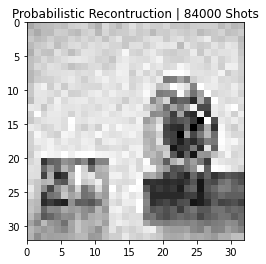

RMSE:  0.002704376525547469  | MSE:  0.0018722950123346432  | SSIM:  0.8368063612665002
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  84500 Shots:


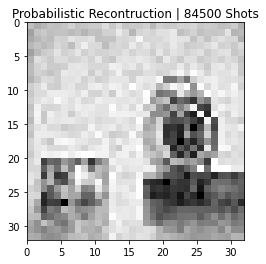

RMSE:  0.0026872795547569516  | MSE:  0.0018486966797861683  | SSIM:  0.8294582931166917
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  85000 Shots:


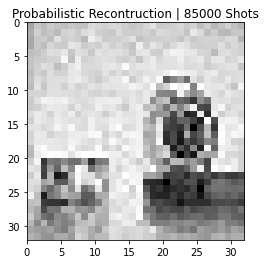

RMSE:  0.002606529600445918  | MSE:  0.001739263118848194  | SSIM:  0.8281190950872501
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  85500 Shots:


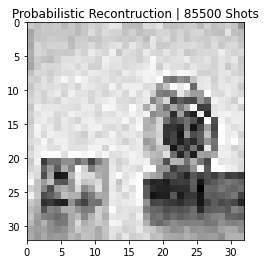

RMSE:  0.0023464181289812713  | MSE:  0.0014094535772190642  | SSIM:  0.854638034494752
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  86000 Shots:


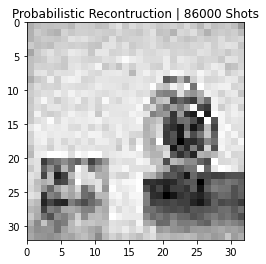

RMSE:  0.0025374561363390264  | MSE:  0.0016483030128242127  | SSIM:  0.8368089599139481
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  86500 Shots:


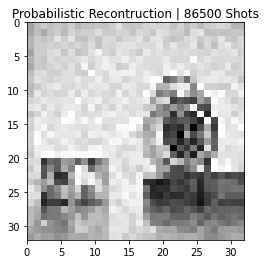

RMSE:  0.0025630524260335467  | MSE:  0.0016817248610806912  | SSIM:  0.8372939809481408
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  87000 Shots:


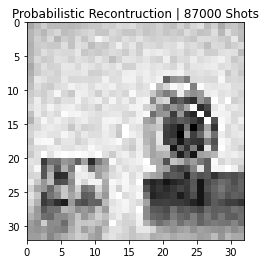

RMSE:  0.002705834475068722  | MSE:  0.0018743142928564292  | SSIM:  0.8337392080154311
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  87500 Shots:


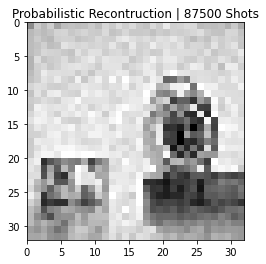

RMSE:  0.002671561154745334  | MSE:  0.001827133184907321  | SSIM:  0.831437428762027
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  88000 Shots:


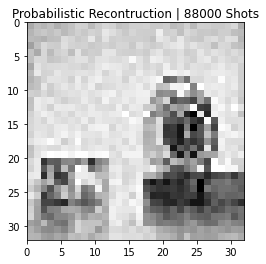

RMSE:  0.002399412909148304  | MSE:  0.0014738386709984071  | SSIM:  0.8614595327213995
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  88500 Shots:


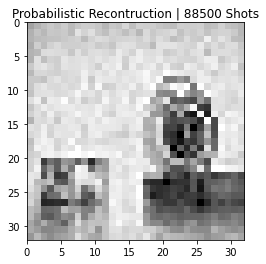

RMSE:  0.0024318706435093964  | MSE:  0.0015139826756512783  | SSIM:  0.8401003773618788
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  89000 Shots:


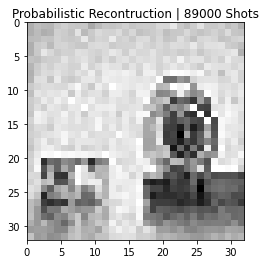

RMSE:  0.0025283442766589996  | MSE:  0.0016364863440164659  | SSIM:  0.8413790838869671
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  89500 Shots:


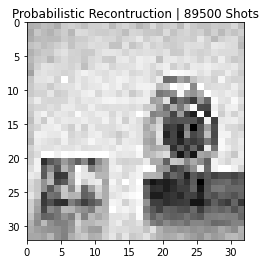

RMSE:  0.00251736107181981  | MSE:  0.0016222993320739287  | SSIM:  0.8447245471459202
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  90000 Shots:


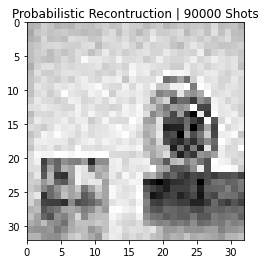

RMSE:  0.0026159089917271844  | MSE:  0.0017518028423677784  | SSIM:  0.8379343816288475
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  90500 Shots:


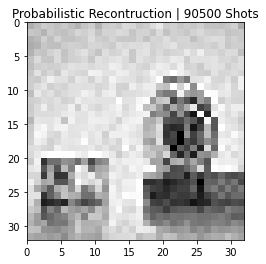

RMSE:  0.002307238030910631  | MSE:  0.0013627769168077738  | SSIM:  0.8552281621965555
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  91000 Shots:


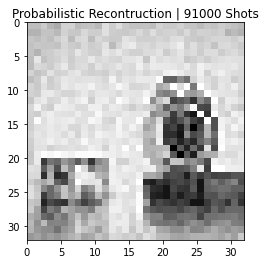

RMSE:  0.0024920944076194515  | MSE:  0.001589896841340965  | SSIM:  0.8543380389052193
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  91500 Shots:


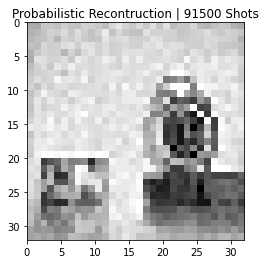

RMSE:  0.002446837081062774  | MSE:  0.0015326749955235316  | SSIM:  0.8499928657582573
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  92000 Shots:


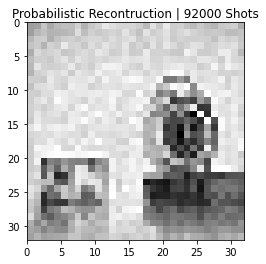

RMSE:  0.0025110604885832315  | MSE:  0.0016141887429949075  | SSIM:  0.8400447067501937
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  92500 Shots:


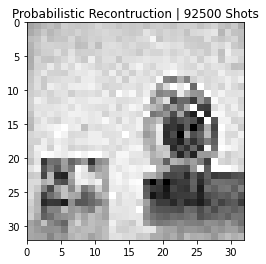

RMSE:  0.0024261052777655914  | MSE:  0.0015068126256133267  | SSIM:  0.8458027819916206
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  93000 Shots:


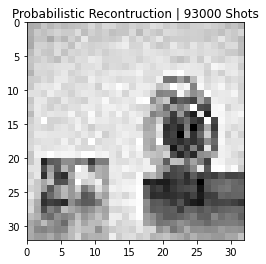

RMSE:  0.00240607340262305  | MSE:  0.0014820324400153756  | SSIM:  0.8497324276168079
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  93500 Shots:


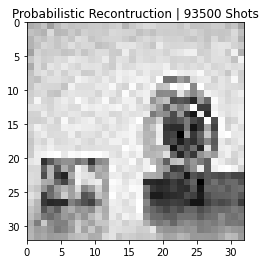

RMSE:  0.0026129119848613018  | MSE:  0.0017477911144017477  | SSIM:  0.8484263171839693
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  94000 Shots:


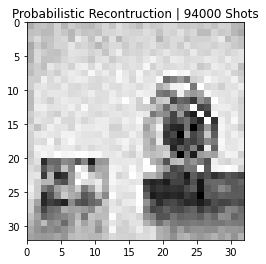

RMSE:  0.0025574614337520703  | MSE:  0.001674395900193074  | SSIM:  0.8506043046648177
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  94500 Shots:


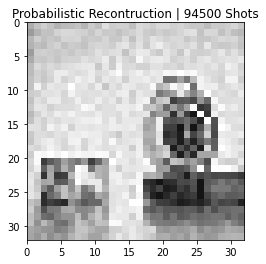

RMSE:  0.0024668174293793208  | MSE:  0.0015578081868517378  | SSIM:  0.842674940915665
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  95000 Shots:


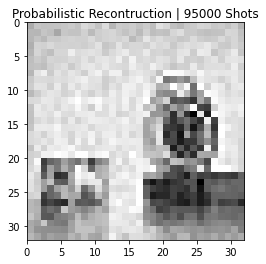

RMSE:  0.002461052510345581  | MSE:  0.0015505355414216413  | SSIM:  0.8394206420916891
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  95500 Shots:


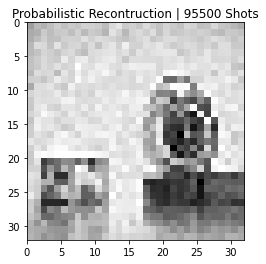

RMSE:  0.002619485595810285  | MSE:  0.0017565964253843367  | SSIM:  0.8401928803368323
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  96000 Shots:


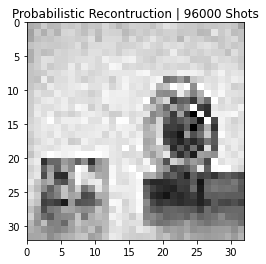

RMSE:  0.0024741380425820176  | MSE:  0.001567067917760404  | SSIM:  0.8470916919446113
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  96500 Shots:


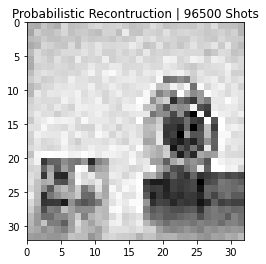

RMSE:  0.0023213149448178248  | MSE:  0.0013794567866968529  | SSIM:  0.8535634477500238
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  97000 Shots:


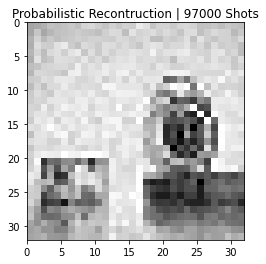

RMSE:  0.0024809905486563766  | MSE:  0.0015757604102457005  | SSIM:  0.8460712919296329
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  97500 Shots:


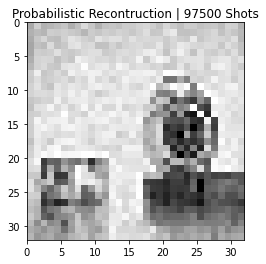

RMSE:  0.0026155591567511866  | MSE:  0.0017513343238310343  | SSIM:  0.8331793870676999
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  98000 Shots:


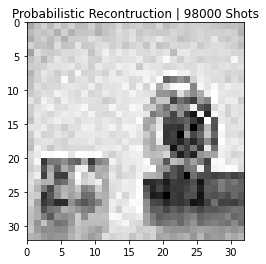

RMSE:  0.0025783708173383437  | MSE:  0.0017018869943557116  | SSIM:  0.8470192263652033
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  98500 Shots:


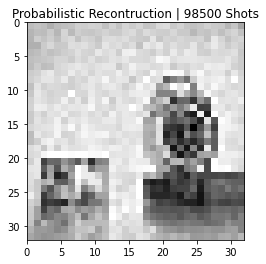

RMSE:  0.002380625084477691  | MSE:  0.0014508482029681699  | SSIM:  0.8478466881387923
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  99000 Shots:


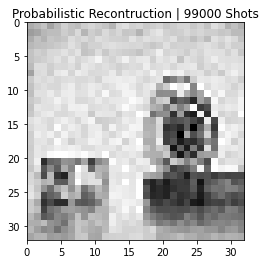

RMSE:  0.0024593654881921337  | MSE:  0.0015484105227546964  | SSIM:  0.8459913661273786
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  99500 Shots:


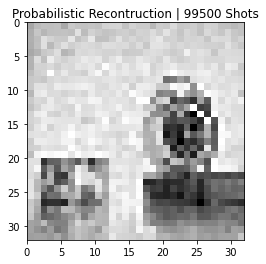

RMSE:  0.0025721142151274414  | MSE:  0.0016936375131291273  | SSIM:  0.8421458390143377
-X-X-X-X-X-X-X-X-X-X-
Image recontructed from  100000 Shots:


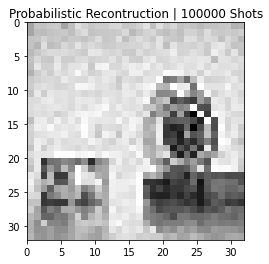

RMSE:  0.0024837315960806274  | MSE:  0.0015792441961905207  | SSIM:  0.8456119791062942
-X-X-X-X-X-X-X-X-X-X-
RMSE Error Values:
[0.044475736842171154, 0.03344911830688524, 0.02474413975279488, 0.01984563869484303, 0.016863830781121233, 0.016515120151882272, 0.01395618075800604, 0.013885662395579777, 0.013294864588800375, 0.012814738618240808, 0.010073711047773616, 0.00990507210233398, 0.009394471593151281, 0.009094460006533358, 0.008216037607691441, 0.008897062966302011, 0.008182332391120884, 0.008167321438708101, 0.0076303696239831235, 0.007434818429606194, 0.0064425006456012195, 0.007485643657405124, 0.007605451229944604, 0.007145743578244512, 0.006560216307865274, 0.006579706584530945, 0.006232037446909961, 0.00669924462012379, 0.006395300766949463, 0.00636610077551449, 0.006746316416021876, 0.006065040467915027, 0.005357569025232962, 0.0053519434083035364, 0.005932164977593118, 0.005742042857714322, 0.005180345777038971, 0.005598055410107862, 0.005378898092900119, 0.0051963479391

In [46]:
# Now we will see how changing the nuymebrof shots affects these errors:
simulator = Aer.get_backend('aer_simulator')
qc_image_32_transpiled = transpile(qc_image_32, simulator)

shots = np.arange(500, 100001, 500)
rmse_error = []
mse_error = []
ssim_error = []
images = []
for shots_value in shots:
    # Running Quantum Circuit
    result = simulator.run(qc_image_32_transpiled, shots=shots_value).result()
    counts = result.get_counts()
    
    # Recreating the Image from circuit output
    simulator_output = []
    for i in range(32**2):
        if get_bin(i, 10) in counts:
            simulator_output.append(np.sqrt( ( counts.get(get_bin(i, 10)) / shots_value ) ) )
        else:
            simulator_output.append(0)
        
    np_simulator_output = np.array(simulator_output).reshape((32,32))
    np_simulator_output = normalize(np_simulator_output)
    np_simulator_output_denormalized = denormalize(np_test_image_32x32, np_test_image_32x32_normalized, np_simulator_output, 32)

    images.append(np_simulator_output_denormalized)
    
    #Display Image:
    print("Image recontructed from ", shots_value, "Shots:")
    title_string = "Probabilistic Recontruction | {} Shots".format(shots_value)
    plot_image32x32(np_simulator_output_denormalized, title_string)
    
    #Calculate Errors:
    rmse_simulator = rmse_image_error(np_test_image_32x32, np_simulator_output_denormalized, 16)
    mse_simulator = mse_image_error(np_test_image_32x32, np_simulator_output_denormalized, 16)
    ssim_simulator = ssim(np_test_image_32x32, np_simulator_output_denormalized, data_range=np_simulator_output_denormalized.max() - np_simulator_output_denormalized.min())

    rmse_error.append(rmse_simulator)
    mse_error.append(mse_simulator)
    ssim_error.append(ssim_simulator)
    print("RMSE: ", rmse_simulator, " | MSE: ", mse_simulator, " | SSIM: ", ssim_simulator)
    print("-X-X-X-X-X-X-X-X-X-X-")
    
    
print("RMSE Error Values:")
print(rmse_error)
print("MSE Error Values:")
print(mse_error)
print("SSIM Values:")
print(ssim_error)


Traceback (most recent call last):
  Input In [47] in <cell line: 1>
    import cv2
ModuleNotFoundError: No module named 'cv2'

Use %tb to get the full traceback.
